# Load Libraries

In [1]:
#!pip install seaborn==0.11.1
#!pip install catboost

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None) #prevents trailing elipses
# pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [3]:
train_df = pd.read_csv("input/train_df_clean_v2.csv",
                       index_col = "id",
                       parse_dates = ["date_activ", "date_end", "date_modif_prod", "date_renewal"])
test_df = pd.read_csv("input/test_df_clean_v2.csv",
                      index_col = "id",
                      parse_dates = ["date_activ", "date_end", "date_modif_prod", "date_renewal"])

# Check for Imbalanced Data

In [4]:
# get percentage of churn data (True vs False)
(train_df.reset_index().groupby(["churn"]).count()["id"] / train_df.shape[0])

churn
0    0.901262
1    0.098738
Name: id, dtype: float64

# Baseline Model

## Train/Validation Split

In [5]:
from sklearn.model_selection import train_test_split

X = train_df.drop(["churn"], axis = 1)
y = train_df["churn"]

ran_state = 42

# split training into train and validation set while keeping the percentage of churns constant
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = ran_state, stratify = y)

## Logistic Regression

AUC Score: 0.5770465299903804
F1 Score: 0.0


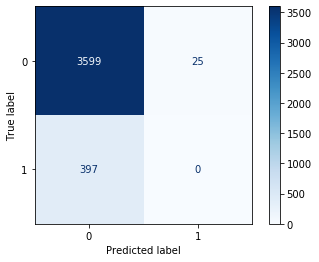

In [6]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

# train model
X_temp = X_train.select_dtypes(exclude = ["object", "datetime64"]).fillna(0)
skf = StratifiedKFold(n_splits = 5, random_state = ran_state)

clf = LogisticRegressionCV(cv = skf, random_state = ran_state, solver = "liblinear")

baseline_model = clf.fit(X_temp, y_train)

# classify validation data
baseline_y_pred = baseline_model.predict(X_val.select_dtypes(exclude = ["object", "datetime64"]).fillna(0))
baseline_y_pred_proba = baseline_model.predict_proba(X_val.select_dtypes(exclude = ["object", "datetime64"]).fillna(0))[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, baseline_y_pred_proba)
f1_sco = f1_score(y_val, baseline_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get confusion matrix
plot_confusion_matrix(baseline_model, X_val.select_dtypes(exclude = ["object", "datetime64"]).fillna(0), y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df = pd.DataFrame(columns = ["model", "AUC Score", "F1 Score"])
results_df.loc[len(results_df)] = ["Baseline Logistic Regression", auc_sco, f1_sco]

## Random Forest

AUC Score: 0.7044615104453379
F1 Score: 0.08076009501187649


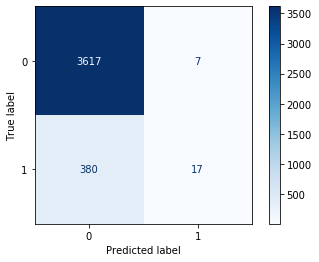

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# train model
rfc = RandomForestClassifier(random_state = ran_state)

rfc_baseline = rfc.fit(X_temp, y_train)

# classify validation data
rfc_baseline_y_pred = rfc_baseline.predict(X_val.select_dtypes(exclude = ["object", "datetime64"]).fillna(0))
rfc_baseline_y_pred_proba = rfc_baseline.predict_proba(X_val.select_dtypes(exclude = ["object", "datetime64"]).fillna(0))[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, rfc_baseline_y_pred_proba)
f1_sco = f1_score(y_val, rfc_baseline_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get confusion matrix
plot_confusion_matrix(rfc_baseline, X_val.select_dtypes(exclude = ["object", "datetime64"]).fillna(0), y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["Baseline Random Forest Classifier", auc_sco, f1_sco]

# Feature Creation

In [8]:
# user defined functions (to go into pipeline)

def median_price (data) :
    """
    Get average for each type of prices.
    """
    col_names = ["price_p1_var", "price_p2_var", "price_p3_var", "price_p1_fix", "price_p2_fix", "price_p3_fix"]
    months = ["_01", "_02", "_03", "_04", "_05", "_06", "_07", "_08", "_09", "_10", "_11", "_12"]
    for i in col_names :
        l = []
        for j in months :
            l.append(i + j)
        avg_var = "avg_" + i
        data[avg_var] = data[l].median(axis = 1)
    return data

def price_change (data) :
    """
    Get price increase between Jan and Dec 2015.
    """
    col_names = ["price_p1_var", "price_p2_var", "price_p3_var", "price_p1_fix", "price_p2_fix", "price_p3_fix"]
    months = ["_01", "_12"]
    for i in col_names :
        l = []
        for j in months :
            l.append(i + j)
        diff_var = "diff_" + i
        data[diff_var] = data[l[1]] - data[l[0]]
    return data

def drop_pricing_hist (data) :
    """
    Drop all pricing history columns
    """
    col_names = ["price_p1_var", "price_p2_var", "price_p3_var", "price_p1_fix", "price_p2_fix", "price_p3_fix"]
    months = ["_01", "_02", "_03", "_04", "_05", "_06", "_07", "_08", "_09", "_10", "_11", "_12"]
    l = []
    for i in col_names :
        for j in months :
            l.append(i + j)
    data.drop(l, axis = 1, inplace = True)
    return data

def days_since (data) :
    """
    Get number of days from/since activation of contract, registered date of end of contract,
    date of first contract of the client, date of last modification of the product and
    date for next contract renewal.
    """
    today = pd.to_datetime('2016/1/1')
    col_names = data.select_dtypes(include = ["datetime"]).columns.tolist()
    for col in col_names :
        new_col = col + "_days_diff"
        data[new_col] = (today - data[col]) / np.timedelta64(1, "D")
    return data

def contract_dur (data) :
    """
    Get the number of day between account activation and end of contract date.
    """
    data["contract_duration"] = (data["date_end"] - data["date_activ"]) / np.timedelta64(1, "D")
    return data

def avg_consumption_by_sector (data) :
    """
    Calculate consumption difference between company and median consumption for companies in the same
    ISIC level 1 and level 2.
    """
    # Calculate consumption difference with avg in ISIC Lv 1
    avg_cons_isic_1l = data.groupby(["isic_1l"]).median()["cons_12m"]
    avg_cons_isic_1l = avg_cons_isic_1l.rename("avg_cons_isic_1l")
    data = data.join(avg_cons_isic_1l, how = "left", on = "isic_1l", sort = False)
    data["cons_diff_avg_isic_1l"] = data["cons_12m"] - data["avg_cons_isic_1l"]
    
    # Calculate consumption difference with avg in ISIC Lv 1 & 2
    data["combined_isic"] = data["isic_1l"] + data["isic_2l"].astype(str)
    avg_cons_combined_isic = data.groupby(["combined_isic"]).median()["cons_12m"]
    avg_cons_combined_isic = avg_cons_combined_isic.rename("avg_cons_combined_isic")
    data = data.join(avg_cons_combined_isic, how = "left", on = "combined_isic", sort = False)
    data["cons_diff_avg_isic_comb"] = data["cons_12m"] - data["avg_cons_combined_isic"]
    
    # Drop temporary columns
    data = data.drop(["combined_isic", "avg_cons_isic_1l", "avg_cons_combined_isic"], axis = 1)
    
    return data

def zip_grouping (data) :
    """
    Retain only the first 2 numbers of the zip code.
    """
    # change zip into string and add "0" to zip codes with only 4 digits
    data["zip"] = data["zip"].astype(str).apply(lambda x: x[:2])
    data["zip"] = data["zip"].astype(int)
    
    return data

def usage_percent (data) :
    data["usage_percent"] = (data["cons_12m"] / 365 / 24) / data["pow_max"]
    data["usage_percent"] = data["usage_percent"].replace(np.inf, 0)
    return data

def add_features (data) :
    data = median_price(data)
    data = price_change(data)
    data = drop_pricing_hist(data)
    data = days_since(data)
    data = contract_dur(data)
    data = avg_consumption_by_sector(data)
    data = zip_grouping(data)
    data = usage_percent(data)
    return data

In [9]:
# add features to train data
X_train = add_features(X_train)

# add features to validation data
X_val = add_features(X_val)

# add features to test data
test_clean = test_df.copy(deep = True)
test_clean = add_features(test_clean)

In [10]:
# percentage customer churn by zip code group
zip_code = X_train.join(pd.DataFrame(y_train), how = "left", sort = False).groupby(["zip"]).mean()["churn"]
zip_code = zip_code.rename("zip_churn")

X_train = X_train.join(zip_code, how = "left", on = "zip", sort = False)
X_val = X_val.join(zip_code, how = "left", on = "zip", sort = False)
test_clean = test_clean.join(zip_code, how = "left", on = "zip", sort = False)

In [11]:
# percentage customer churn by industry codes
ind = X_train.join(pd.DataFrame(y_train), how = "left", sort = False).groupby(["isic_1l", "isic_2l"]).mean()["churn"]
ind = ind.rename("isic_churn")

X_train = X_train.join(ind, how = "left", on = ["isic_1l", "isic_2l"], sort = False)
X_val = X_val.join(ind, how = "left", on = ["isic_1l", "isic_2l"], sort = False)
test_clean = test_clean.join(ind, how = "left", on = ["isic_1l", "isic_2l"], sort = False)

# Apply OneHotEncoder to Categorical Columns

In [12]:
from sklearn.preprocessing import OneHotEncoder

enc_channel = OneHotEncoder(handle_unknown = "ignore", sparse = True)
enc_origin = OneHotEncoder(handle_unknown = "ignore", sparse = True)

# use one hot encoder on categorical columns on train data
train_channel = enc_channel.fit_transform(X_train[["channel_sales"]]).toarray()
train_channel = pd.DataFrame(train_channel,
                             columns = "channel_sales_" + enc_channel.categories_[0].ravel(),
                             index = X_train.index.to_list()
                            ).astype(int)
train_origin = enc_origin.fit_transform(X_train[["origin_up"]]).toarray()
train_origin = pd.DataFrame(train_origin,
                            columns = "origin_up_" + enc_origin.categories_[0].ravel(),
                            index = X_train.index.to_list()
                           ).astype(int)

# concat to dataframe
X_train = pd.concat([X_train, train_channel, train_origin], axis = 1, sort = False)

# drop selected columns
X_train.drop(["channel_sales", "origin_up", "isic_1l", "isic_2l", "zip"], axis = 1, inplace = True)

In [13]:
# use one hot encoder on categorical columns on validation data
val_channel = enc_channel.transform(X_val[["channel_sales"]]).toarray()
val_channel = pd.DataFrame(val_channel,
                            columns = "channel_sales_" + enc_channel.categories_[0].ravel(),
                            index = X_val.index.to_list()
                           ).astype(int)
val_origin = enc_origin.transform(X_val[["origin_up"]]).toarray()
val_origin = pd.DataFrame(val_origin,
                           columns = "origin_up_" + enc_origin.categories_[0].ravel(),
                           index = X_val.index.to_list()
                          ).astype(int)

# concat to dataframe
X_val = pd.concat([X_val, val_channel, val_origin], axis = 1, sort = False)

# drop selected columns
X_val.drop(["channel_sales", "origin_up", "isic_1l", "isic_2l", "zip"], axis = 1, inplace = True)

In [14]:
# use one hot encoder on categorical columns on test data
test_channel = enc_channel.transform(test_clean[["channel_sales"]]).toarray()
test_channel = pd.DataFrame(test_channel,
                            columns = "channel_sales_" + enc_channel.categories_[0].ravel(),
                            index = test_clean.index.to_list()
                           ).astype(int)
test_origin = enc_origin.transform(test_clean[["origin_up"]]).toarray()
test_origin = pd.DataFrame(test_origin,
                           columns = "origin_up_" + enc_origin.categories_[0].ravel(),
                           index = test_clean.index.to_list()
                          ).astype(int)

# concat to dataframe
test_clean = pd.concat([test_clean, test_channel, test_origin], axis = 1, sort = False)

# drop selected columns
test_clean.drop(["channel_sales", "origin_up", "isic_1l", "isic_2l", "zip"], axis = 1, inplace = True)

In [15]:
# keep only int & floats from train dataframe
X_train = X_train.select_dtypes(exclude = ["object", "datetime64"])
X_val = X_val.select_dtypes(exclude = ["object", "datetime64"])
test_clean = test_clean.select_dtypes(exclude = ["object", "datetime64"])

In [16]:
# check for nulls
X_train.isnull().sum().sum()

0

In [17]:
# check for nulls
val_nulls = X_val.isnull().sum()
val_nulls[val_nulls > 0]

zip_churn    4
dtype: int64

In [18]:
# fill NA
X_val["zip_churn"] = X_val["zip_churn"].fillna(X_val["zip_churn"].median())
X_val["isic_churn"] = X_val["isic_churn"].fillna(X_val["isic_churn"].median())

In [19]:
# check for nulls
test_nulls = test_clean.isnull().sum()
test_nulls[test_nulls > 0]

zip_churn     1
isic_churn    1
dtype: int64

In [20]:
# fill NA
test_clean["zip_churn"] = test_clean["zip_churn"].fillna(test_clean["zip_churn"].median())
test_clean["isic_churn"] = test_clean["isic_churn"].fillna(test_clean["isic_churn"].median())

In [21]:
X_train.shape

(12062, 47)

In [22]:
X_train.columns.to_list()

['cons_12m',
 'cons_gas_12m',
 'cons_last_month',
 'has_gas',
 'imp_cons',
 'margin_gross_pow_ele',
 'margin_net_pow_ele',
 'nb_prod_act',
 'net_margin',
 'num_years_antig',
 'pow_max',
 'avg_price_p1_var',
 'avg_price_p2_var',
 'avg_price_p3_var',
 'avg_price_p1_fix',
 'avg_price_p2_fix',
 'avg_price_p3_fix',
 'diff_price_p1_var',
 'diff_price_p2_var',
 'diff_price_p3_var',
 'diff_price_p1_fix',
 'diff_price_p2_fix',
 'diff_price_p3_fix',
 'date_activ_days_diff',
 'date_end_days_diff',
 'date_modif_prod_days_diff',
 'date_renewal_days_diff',
 'contract_duration',
 'cons_diff_avg_isic_1l',
 'cons_diff_avg_isic_comb',
 'usage_percent',
 'zip_churn',
 'isic_churn',
 'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu',
 'channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci',
 'channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa',
 'channel_sales_foosdfpfkusacimwkcsosbicdxkicaua',
 'channel_sales_lmkebamcaaclubfxadlmueccxoimlema',
 'channel_sales_other',
 'channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds'

# Correlation Matrix

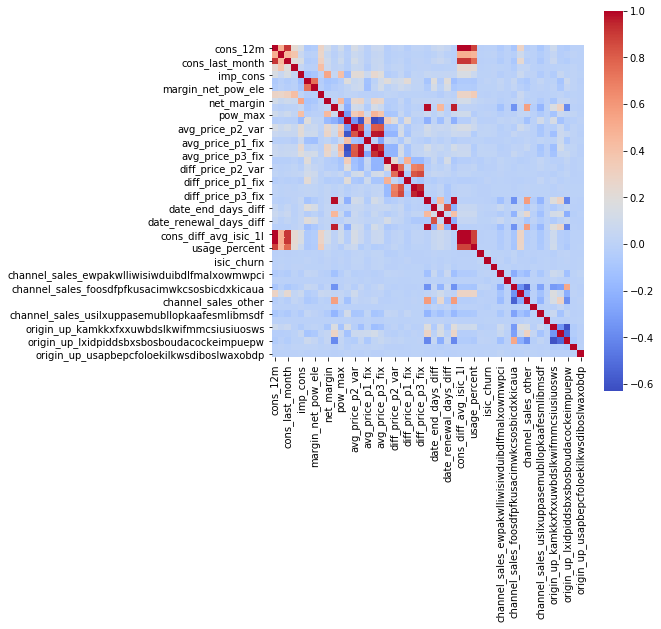

In [23]:
import seaborn as sns

plt.figure(figsize=(7, 7))
sns.heatmap(X_train.corr(), annot=False, cmap = "coolwarm", square = True)
# sns.color_palette("coolwarm") #, as_cmap=True)
plt.show()

# Model After Feature Creations

## Make User Defined Functions

In [24]:
from sklearn.metrics import roc_curve, auc
import itertools

def eval_pred_threshold (y_pred_proba, actual, threshold) :
    df = pd.DataFrame(y_pred_proba, columns = ["Churn Probability"])
    df["Churn Actual"] = actual
    df["Manual Predict"] = df["Churn Probability"]
    df["Manual Predict"] = df["Manual Predict"].apply(lambda x : 1 if (x >= threshold) else 0)
    
    f1_sco = f1_score(df["Churn Actual"], df["Manual Predict"])
    print("F1 Score with probability of", threshold, " :", f1_sco)
    
    plot_manual_confusion_matrix(df, threshold)
    
#     return df

def plot_manual_confusion_matrix (data, threshold, target_names = ["0", "1"], cmap = plt.cm.Blues) :
    # create matrix
    true_0 = data[(data["Churn Actual"] == 0) &
                         (data["Manual Predict"] == 0)]["Manual Predict"].count()
    false_1 = data[(data["Churn Actual"] == 0) &
                          (data["Manual Predict"] == 1)]["Manual Predict"].count()
    false_0 = data[(data["Churn Actual"] == 1) &
                          (data["Manual Predict"] == 0)]["Manual Predict"].count()
    true_1 = data[(data["Churn Actual"] == 1) &
                         (data["Manual Predict"] == 1)]["Manual Predict"].count()
    cm = np.array([[true_0, false_1],
                   [false_0, true_1]])
    
    # plot matrix
    title = "Confusion Matrix with " + str(threshold) + " Threshold"
    plt.figure(figsize = (6, 4))
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment = "center",
                 color = "white" if (cm[i, j] > cm.max() / 2) else "black"
                )
    
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()
    
def plot_roc_curve (pred, actual = y_val) :
    false_pos_rate, true_pos_rate, thres = roc_curve(actual, pred)
    rocauc = auc(false_pos_rate, true_pos_rate)
    
    plt.title("ROC")
    plt.plot(false_pos_rate, true_pos_rate, 'b', label = "AUC = %0.2f"% rocauc)
    plt.legend(loc = "lower right")
    plt.plot([0,1], [0,1], "r")
    plt.xlim([0, 1.1])
    plt.ylim([0, 1.1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show

## Logistic Regression

AUC Score: 0.6222058651809099
F1 Score: 0.0


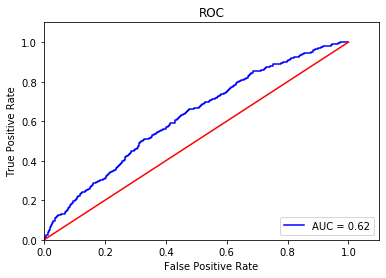

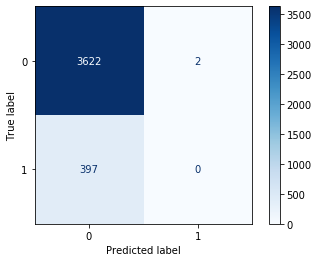

In [25]:
clean_model = clf.fit(X_train, y_train)

# classify validation data
clean_y_pred = clean_model.predict(X_val)
clean_y_pred_proba = clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, clean_y_pred_proba)
f1_sco = f1_score(y_val, clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["Logistic Regression w/ Feature Creation", auc_sco, f1_sco]

# AdaBoost Classifier

AUC Score: 0.7413903114417736
F1 Score: 0.2365988909426987


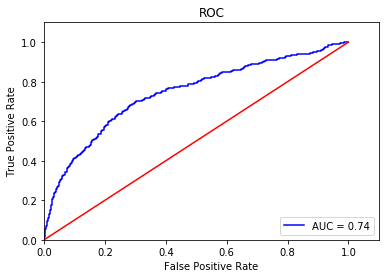

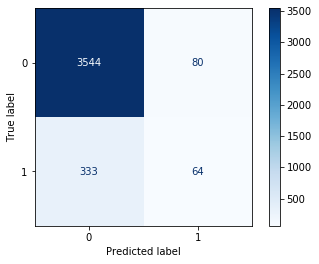

In [26]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators = 1000, random_state = ran_state)

abc_clean_model = abc.fit(X_train, y_train)

# classify validation data
abc_clean_y_pred = abc_clean_model.predict(X_val)
abc_clean_y_pred_proba = abc_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, abc_clean_y_pred_proba)
f1_sco = f1_score(y_val, abc_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(abc_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(abc_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["ABC w/ Feature Creation", auc_sco, f1_sco]

F1 Score with probaility of 0.65  : 0.0


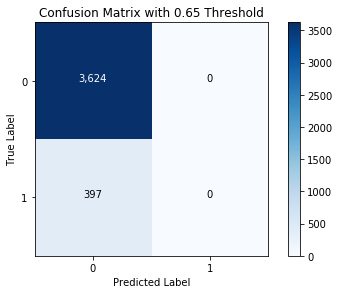

Test data predictions min churn probability: 0.4732226244664333
Test data predictions max churn probability: 0.5047872602663837
Number of churns predicted above threshold: 0


In [27]:
# set threshold for churn prediction
threshold = 0.65

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(abc_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = abc_clean_model.predict(test_clean)
y_pred_proba = abc_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

## Random Forest

AUC Score: 0.7578982962728188
F1 Score: 0.1042654028436019


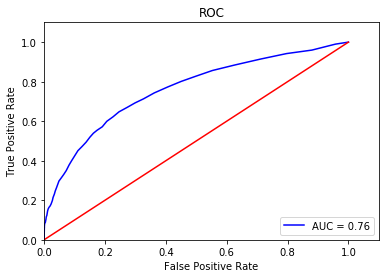

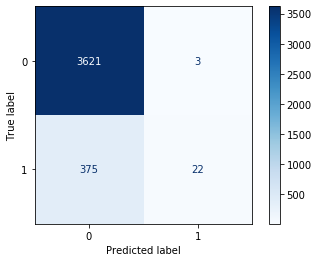

In [28]:
rfc_clean_model = rfc.fit(X_train, y_train)

# classify validation data
rfc_clean_y_pred = rfc_clean_model.predict(X_val)
rfc_clean_y_pred_proba = rfc_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, rfc_clean_y_pred_proba)
f1_sco = f1_score(y_val, rfc_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(rfc_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(rfc_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["Random Forest Classifier w/ Feature Creation", auc_sco, f1_sco]

F1 Score with probaility of 0.65  : 0.024875621890547265


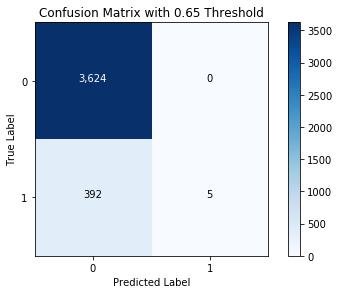

Test data predictions min churn probability: 0.0
Test data predictions max churn probability: 0.96
Number of churns predicted above threshold: 6


In [29]:
# set threshold for churn prediction
threshold = 0.65

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(rfc_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = rfc_clean_model.predict(test_clean)
y_pred_proba = rfc_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

# LGBM Classifier

Training until validation scores don't improve for 40 rounds.
Early stopping, best iteration is:
[294]	valid_0's auc: 0.779294
AUC Score: 0.7792939318620338
F1 Score: 0.358187134502924


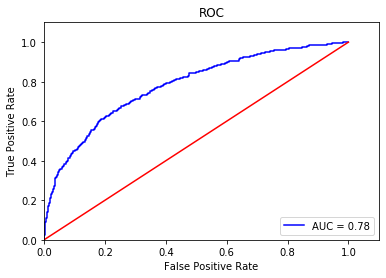

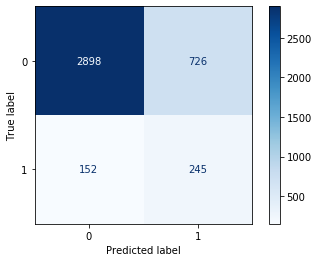

In [30]:
import lightgbm as lgb

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'eval_metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.01,
    'verbose': 0,
    'max_dept':-1,
    "num_iterations": 1000,
    "n_estimators": 1000,
    'seed': ran_state
}

lgbm = lgb.LGBMClassifier(**parameters)

lgbm_clean_model = lgbm.fit(X_train, y_train,
                            eval_set = [(X_val, y_val)],
                            eval_metric = 'auc', # possible to change to f1 score?
                            early_stopping_rounds = 40,
                            verbose = -1
                           )

# classify validation data
lgbm_clean_y_pred = lgbm_clean_model.predict(X_val)
lgbm_clean_y_pred_proba = lgbm_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, lgbm_clean_y_pred_proba)
f1_sco = f1_score(y_val, lgbm_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(lgbm_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(lgbm_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["LGBM Classifier w/ Feature Creation", auc_sco, f1_sco]

F1 Score with probaility of 0.65  : 0.3804755944931164


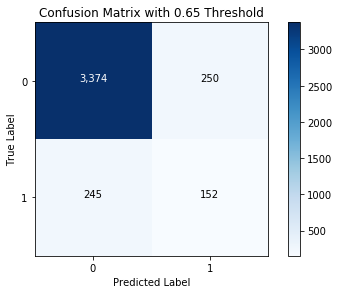

Test data predictions min churn probability: 0.05056653396570674
Test data predictions max churn probability: 0.8509990358006317
Number of churns predicted above threshold: 357


In [31]:
# set threshold for churn prediction
threshold = 0.65

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(lgbm_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = lgbm_clean_model.predict(test_clean)
y_pred_proba = lgbm_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

## AdaBoost Classifier - LGBM Parameters

AUC Score: 0.7424363743529007
F1 Score: 0.3558823529411765


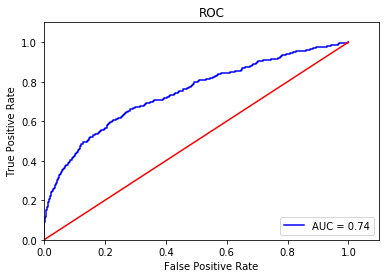

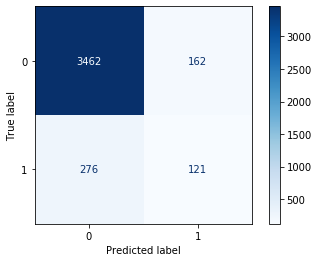

In [32]:
abc_lgbm = AdaBoostClassifier(base_estimator = lgbm_clean_model, random_state = ran_state)

abc_lgbm_clean_model = abc_lgbm.fit(X_train, y_train)

# classify validation data
abc_lgbm_clean_y_pred = abc_lgbm_clean_model.predict(X_val)
abc_lgbm_clean_y_pred_proba = abc_lgbm_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, abc_lgbm_clean_y_pred_proba)
f1_sco = f1_score(y_val, abc_lgbm_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(abc_lgbm_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(abc_lgbm_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["ABC w/ LGMB & Feature Creation", auc_sco, f1_sco]

F1 Score with probaility of 0.65  : 0.0


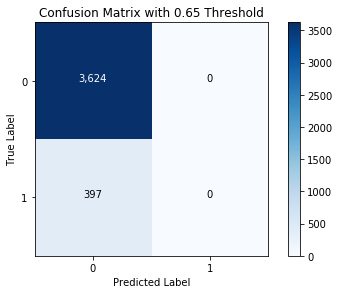

Test data predictions min churn probability: 0.36471233955727256
Test data predictions max churn probability: 0.6006306115040096
Number of churns predicted above threshold: 0


In [33]:
# set threshold for churn prediction
threshold = 0.65

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(abc_lgbm_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = abc_lgbm_clean_model.predict(test_clean)
y_pred_proba = abc_lgbm_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

# CatBoost Classifier

AUC Score: 0.7827796498017694
F1 Score: 0.24897959183673468


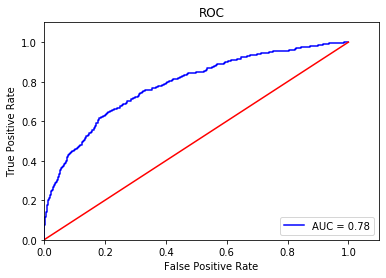

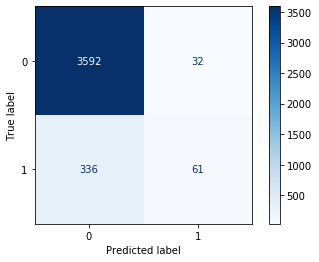

In [34]:
from catboost import CatBoostClassifier, Pool

cb = CatBoostClassifier(verbose = False)

pool = Pool(X_train, y_train, feature_names = list(X_train.columns))

cb_clean_model = cb.fit(pool)

# classify validation data
cb_clean_y_pred = cb_clean_model.predict(X_val)
cb_clean_y_pred_proba = cb_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, cb_clean_y_pred_proba)
f1_sco = f1_score(y_val, cb_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(cb_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(cb_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["Catboost w/ Feature Creation", auc_sco, f1_sco]

F1 Score with probaility of 0.63  : 0.1590909090909091


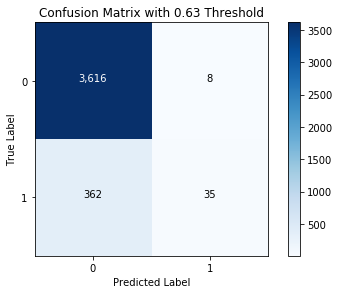

Test data predictions min churn probability: 0.00014571447053256755
Test data predictions max churn probability: 0.9480679907027538
Number of churns predicted above threshold: 46


In [35]:
# set threshold for churn prediction
threshold = 0.63

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(cb_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = cb_clean_model.predict(test_clean)
y_pred_proba = cb_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

## AdaBoost Classifier - CatBoost Parameter

AUC Score: 0.7585276716655267
F1 Score: 0.24340770791075053


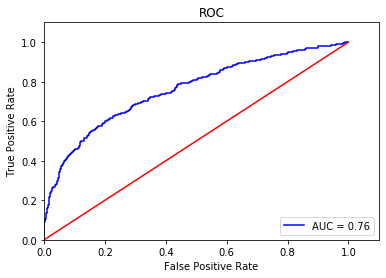

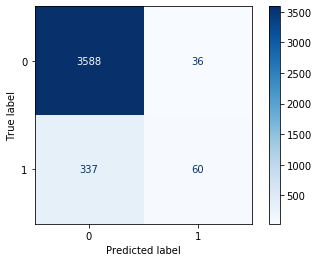

In [36]:
abc_cb = AdaBoostClassifier(base_estimator = cb_clean_model, random_state = ran_state)

abc_cb_clean_model = abc_cb.fit(X_train, y_train)

# classify validation data
abc_cb_clean_y_pred = abc_cb_clean_model.predict(X_val)
abc_cb_clean_y_pred_proba = abc_cb_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, abc_cb_clean_y_pred_proba)
f1_sco = f1_score(y_val, abc_cb_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(abc_cb_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(abc_cb_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["ABC w/ CatBoost & Feature Creation", auc_sco, f1_sco]

F1 Score with probaility of 0.6  : 0.1643835616438356


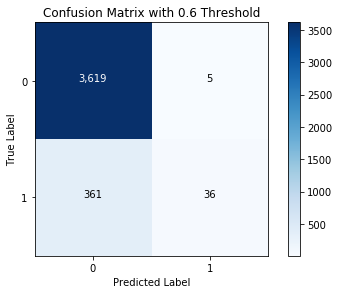

Test data predictions min churn probability: 0.003413374008140229
Test data predictions max churn probability: 0.9136623977857273
Number of churns predicted above threshold: 37


In [37]:
# set threshold for churn prediction
threshold = 0.60

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(abc_cb_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = abc_cb_clean_model.predict(test_clean)
y_pred_proba = abc_cb_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

# Class Balancing

In [38]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

smt = SMOTETomek(random_state = ran_state,
                 smote = SMOTE(sampling_strategy = "minority"),
                 tomek = TomekLinks(sampling_strategy = "majority")
                )

print("Original dataset distribution:", y.value_counts())

X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

print("Resampled dataset churn percentage:", y_resampled.value_counts())

Original dataset distribution: 0    14495
1     1588
Name: churn, dtype: int64
Resampled dataset churn percentage: 1    10871
0    10669
Name: churn, dtype: int64


# Logistic Regression

AUC Score: 0.6277274092114701
F1 Score: 0.2095709570957096


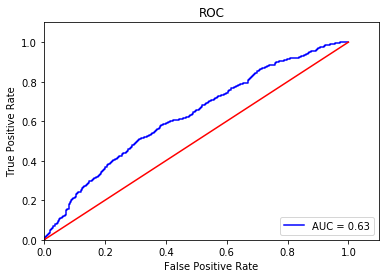

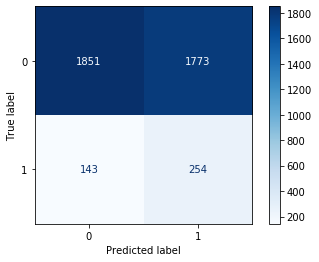

In [39]:
rsm_clean_model = clf.fit(X_resampled, y_resampled)

# classify validation data
rsm_clean_y_pred = rsm_clean_model.predict(X_val)
rsm_clean_y_pred_proba = rsm_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, rsm_clean_y_pred_proba)
f1_sco = f1_score(y_val, rsm_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(rsm_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(rsm_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["Logistic Regression w/ Class Rebalancing", auc_sco, f1_sco]

F1 Score with probaility of 0.65  : 0.10469314079422383


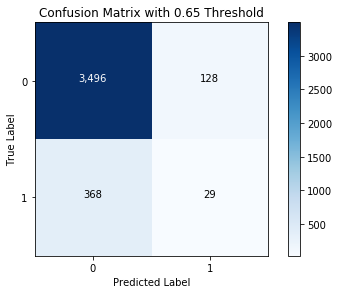

Test data predictions min churn probability: 0.0034697169514959596
Test data predictions max churn probability: 0.9677301246959719
Number of churns predicted above threshold: 133


In [40]:
# set threshold for churn prediction
threshold = 0.65

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(rsm_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = rsm_clean_model.predict(test_clean)
y_pred_proba = rsm_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

## AdaBoost Classifier

AUC Score: 0.7376119739102874
F1 Score: 0.26917057902973396


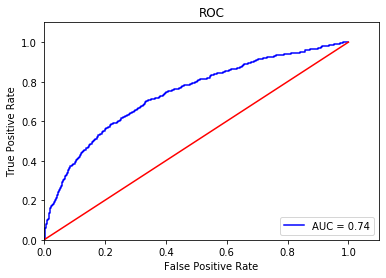

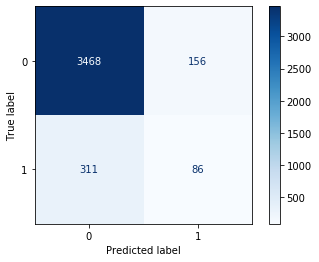

In [41]:
abc = AdaBoostClassifier(n_estimators = 1000, random_state = ran_state)

abc_rsm_clean_model = abc.fit(X_resampled, y_resampled)

# classify validation data
abc_rsm_clean_y_pred = abc_rsm_clean_model.predict(X_val)
abc_rsm_clean_y_pred_proba = abc_rsm_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, abc_rsm_clean_y_pred_proba)
f1_sco = f1_score(y_val, abc_rsm_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(abc_rsm_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(abc_rsm_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["ABC w/ Class Rebalancing", auc_sco, f1_sco]

F1 Score with probaility of 0.65  : 0.0


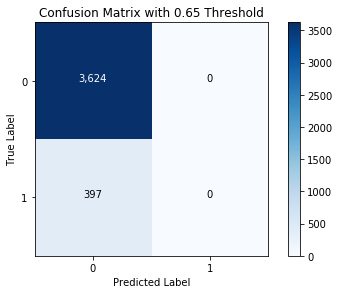

Test data predictions min churn probability: 0.46863602434245205
Test data predictions max churn probability: 0.5054147859754532
Number of churns predicted above threshold: 0


In [42]:
# set threshold for churn prediction
threshold = 0.65

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(abc_rsm_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = abc_rsm_clean_model.predict(test_clean)
y_pred_proba = abc_rsm_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

## Random Forest

AUC Score: 0.7553484744857958
F1 Score: 0.2440944881889764


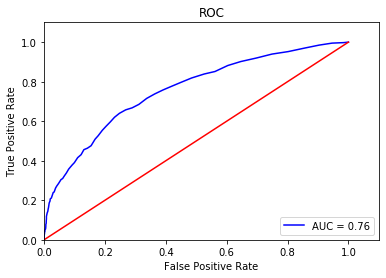

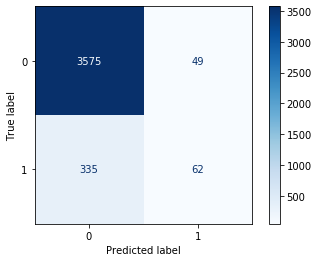

In [43]:
# train model
rfc_rsm_clean_model = rfc.fit(X_resampled, y_resampled)

# classify validation data
rsm_rfc_clean_y_pred = rfc_rsm_clean_model.predict(X_val)
rsm_rfc_clean_y_pred_proba = rfc_rsm_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, rsm_rfc_clean_y_pred_proba)
f1_sco = f1_score(y_val, rsm_rfc_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(rsm_rfc_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(rfc_rsm_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["Random Forest Classifier w/ Class Rebalancing", auc_sco, f1_sco]

F1 Score with probaility of 0.65  : 0.08920187793427231


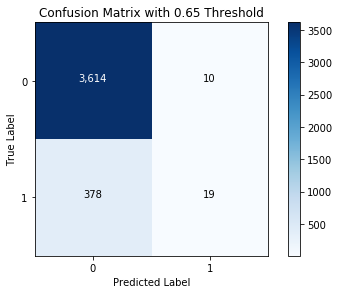

Test data predictions min churn probability: 0.0
Test data predictions max churn probability: 1.0
Number of churns predicted above threshold: 32


In [44]:
# set threshold for churn prediction
threshold = 0.65

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(rsm_rfc_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = rfc_rsm_clean_model.predict(test_clean)
y_pred_proba = rfc_rsm_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

## AdaBoost Classifier - Random Forest Parameters

AUC Score: 0.7594701708731602
F1 Score: 0.22709163346613548


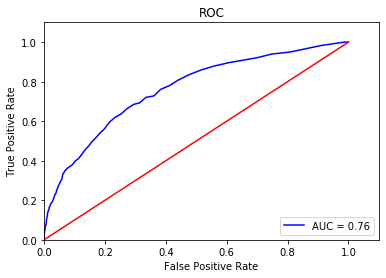

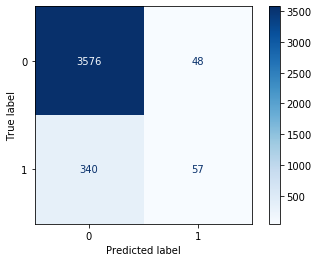

In [45]:
abc_rf = AdaBoostClassifier(base_estimator = rfc_rsm_clean_model, random_state = ran_state)

abc_rf_rsm_clean_model = abc_rf.fit(X_resampled, y_resampled)

# classify validation data
abc_rf_rsm_clean_y_pred = abc_rf_rsm_clean_model.predict(X_val)
abc_rf_rsm_clean_y_pred_proba = abc_rf_rsm_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, abc_rf_rsm_clean_y_pred_proba)
f1_sco = f1_score(y_val, abc_rf_rsm_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(abc_rf_rsm_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(abc_rf_rsm_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["ABC w/ Random Forest & Class Rebalancing", auc_sco, f1_sco]

F1 Score with probaility of 0.65  : 0.10672853828306264


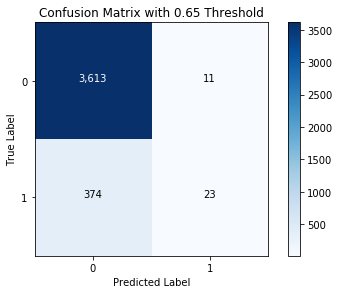

Test data predictions min churn probability: 2.220446049250318e-16
Test data predictions max churn probability: 0.98
Number of churns predicted above threshold: 27


In [46]:
# set threshold for churn prediction
threshold = 0.65

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(abc_rf_rsm_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = abc_rf_rsm_clean_model.predict(test_clean)
y_pred_proba = abc_rf_rsm_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

## LGBM Classifier

Training until validation scores don't improve for 40 rounds.
Early stopping, best iteration is:
[180]	valid_0's auc: 0.756214
AUC Score: 0.7562138222096185
F1 Score: 0.27241379310344827


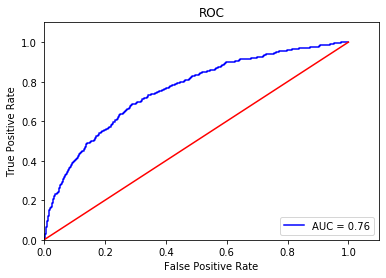

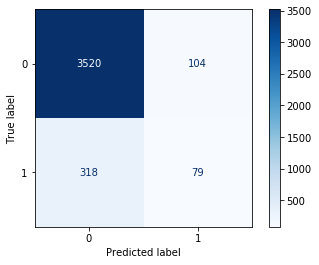

In [47]:
lgbm_rsm_clean_model = lgbm.fit(X_resampled, y_resampled,
                            eval_set = [(X_val, y_val)],
                            eval_metric = 'auc', # possible to change to f1 score?
                            early_stopping_rounds = 40,
                            verbose = -1
                           )

# classify validation data
lgbm_rsm_clean_y_pred = lgbm_rsm_clean_model.predict(X_val)
lgbm_rsm_clean_y_pred_proba = lgbm_rsm_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, lgbm_rsm_clean_y_pred_proba)
f1_sco = f1_score(y_val, lgbm_rsm_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(lgbm_rsm_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(lgbm_rsm_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["LGBM Classifier w/ Class Rebalancing", auc_sco, f1_sco]

F1 Score with probaility of 0.65  : 0.0387409200968523


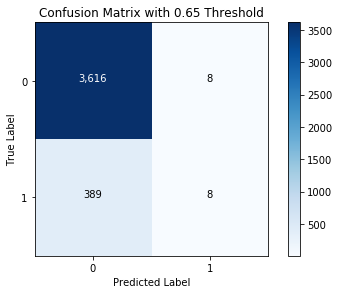

Test data predictions min churn probability: 0.11732559828501328
Test data predictions max churn probability: 0.8021147630112315
Number of churns predicted above threshold: 14


In [48]:
# set threshold for churn prediction
threshold = 0.65

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(lgbm_rsm_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = lgbm_rsm_clean_model.predict(test_clean)
y_pred_proba = lgbm_rsm_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

## AdaBoost Classifier - LGBM Parameters

AUC Score: 0.7377294387820352
F1 Score: 0.3076923076923077


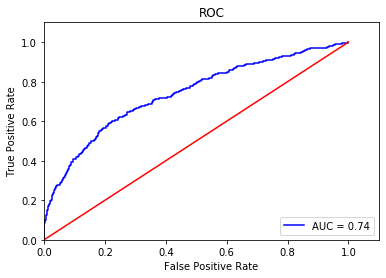

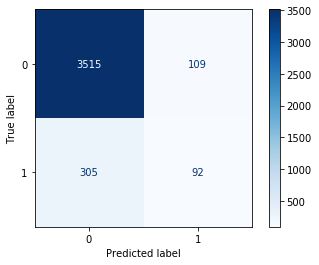

In [49]:
abc_lgbm = AdaBoostClassifier(base_estimator = lgbm_rsm_clean_model, random_state = ran_state)

abc_lgbm_rsm_clean_model = abc_lgbm.fit(X_resampled, y_resampled)

# classify validation data
abc_lgbm_rsm_clean_y_pred = abc_lgbm_rsm_clean_model.predict(X_val)
abc_lgbm_rsm_clean_y_pred_proba = abc_lgbm_rsm_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, abc_lgbm_rsm_clean_y_pred_proba)
f1_sco = f1_score(y_val, abc_lgbm_rsm_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(abc_lgbm_rsm_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(abc_lgbm_rsm_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["ABC w/ LGBM & Class Rebalancing", auc_sco, f1_sco]

F1 Score with probaility of 0.65  : 0.0


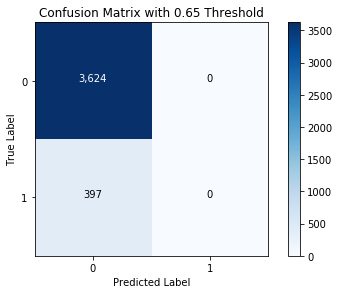

Test data predictions min churn probability: 0.32322014676595434
Test data predictions max churn probability: 0.6210306813482768
Number of churns predicted above threshold: 0


In [50]:
# set threshold for churn prediction
threshold = 0.65

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(abc_lgbm_rsm_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = abc_lgbm_rsm_clean_model.predict(test_clean)
y_pred_proba = abc_lgbm_rsm_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

## CatBoost Classifier

AUC Score: 0.7624936749684444
F1 Score: 0.3068592057761733


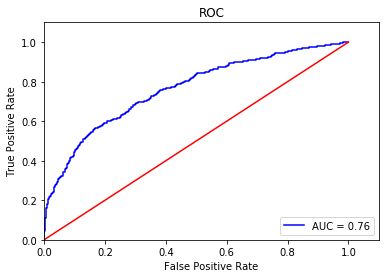

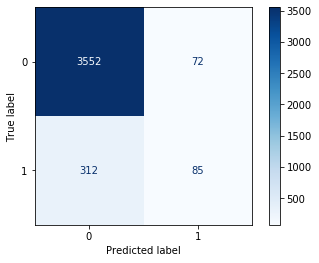

In [51]:
cb_rsm_clean_model = cb.fit(X_resampled, y_resampled)

# classify validation data
cb_rsm_clean_y_pred = cb_rsm_clean_model.predict(X_val)
cb_rsm_clean_y_pred_proba = cb_rsm_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, cb_rsm_clean_y_pred_proba)
f1_sco = f1_score(y_val, cb_rsm_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(cb_rsm_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(cb_rsm_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["Catboost w/ Class Rebalancing", auc_sco, f1_sco]

F1 Score with probaility of 0.7  : 0.15730337078651685


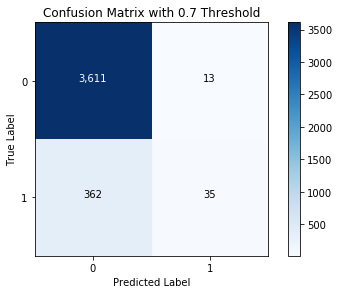

Test data predictions min churn probability: 0.00015574100461358868
Test data predictions max churn probability: 0.9950564648849074
Number of churns predicted above threshold: 52


In [52]:
# set threshold for churn prediction
threshold = 0.7

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(cb_rsm_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = cb_rsm_clean_model.predict(test_clean)
y_pred_proba = cb_rsm_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

## AdaBoost Classifier - CatBoost Parameter

AUC Score: 0.7377294387820352
F1 Score: 0.3076923076923077


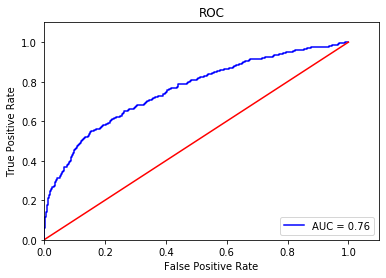

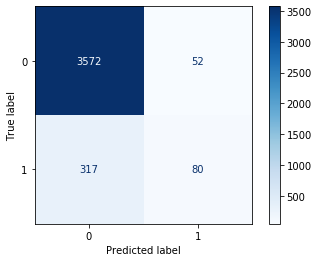

In [53]:
abc_cb_rsm = AdaBoostClassifier(base_estimator = cb_rsm_clean_model, random_state = ran_state)

abc_cb_rsm_clean_model = abc_cb_rsm.fit(X_resampled, y_resampled)

# classify validation data
abc_cb_rsm_clean_y_pred = abc_cb_rsm_clean_model.predict(X_val)
abc_cb_rsm_clean_y_pred_proba = abc_cb_rsm_clean_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, abc_lgbm_rsm_clean_y_pred_proba)
f1_sco = f1_score(y_val, abc_lgbm_rsm_clean_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(abc_cb_rsm_clean_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(abc_cb_rsm_clean_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["ABC w/ Catboost & Class Rebalancing", auc_sco, f1_sco]

F1 Score with probaility of 0.65  : 0.15765765765765766


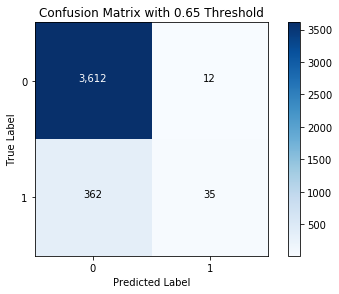

Test data predictions min churn probability: 0.00141716084432371
Test data predictions max churn probability: 0.9712890565825375
Number of churns predicted above threshold: 43


In [54]:
# set threshold for churn prediction
threshold = 0.65

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(abc_cb_rsm_clean_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = abc_cb_rsm_clean_model.predict(test_clean)
y_pred_proba = abc_cb_rsm_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

In [55]:
results_df

,model,AUC Score,F1 Score
0,Baseline Logistic Regression,0.577047,0.000000
1,Baseline Random Forest Classifier,0.704462,0.080760
2,Logistic Regression w/ Feature Creation,0.622206,0.000000
3,ABC w/ Feature Creation,0.741390,0.236599
4,Random Forest Classifier w/ Feature Creation,0.757898,0.104265
5,LGBM Classifier w/ Feature Creation,0.779294,0.358187
6,ABC w/ LGMB & Feature Creation,0.742436,0.355882
7,Catboost w/ Feature Creation,0.782780,0.248980
8,ABC w/ CatBoost & Feature Creation,0.758528,0.243408
9,Logistic Regression w/ Class Rebalancing,0.627727,0.209571


Considering the AUC Score and the probability of false positives vs true positives for churner prediction, we will choose to tune the hyperparameters of Catboost w/ Feature Creation and ABC w/ CatBoost & Feature Creation models.

# Hyperparameter Tuning

## Catboost w/ Feature Creation

In [115]:
from sklearn.model_selection import GridSearchCV

grid_params = {"depth": [3, 6, 10, 25],
               "learning_rate": [0.001, 0.03, 0.15],
               "l2_leaf_reg": [1, 5, 10],
               "iterations": [500]
              }

cb = CatBoostClassifier(random_seed = ran_state)

cb_model = GridSearchCV(cb, grid_params, scoring = "roc_auc", n_jobs = -1, refit = True, cv = 5, verbose = 0)

cb_model.fit(X_train, y_train)

print("Best AUC score:", cb_model.best_score_)

0:	learn: 0.6666916	total: 15.6ms	remaining: 7.78s
1:	learn: 0.6374319	total: 24.8ms	remaining: 6.18s
2:	learn: 0.6100546	total: 35ms	remaining: 5.8s
3:	learn: 0.5869956	total: 45ms	remaining: 5.57s
4:	learn: 0.5638964	total: 54.1ms	remaining: 5.36s
5:	learn: 0.5448792	total: 63.2ms	remaining: 5.21s
6:	learn: 0.5244903	total: 78.7ms	remaining: 5.54s
7:	learn: 0.5048600	total: 94.5ms	remaining: 5.81s
8:	learn: 0.4891428	total: 105ms	remaining: 5.7s
9:	learn: 0.4734228	total: 117ms	remaining: 5.73s
10:	learn: 0.4587558	total: 129ms	remaining: 5.72s
11:	learn: 0.4472486	total: 139ms	remaining: 5.65s
12:	learn: 0.4349107	total: 149ms	remaining: 5.57s
13:	learn: 0.4235093	total: 159ms	remaining: 5.53s
14:	learn: 0.4148694	total: 171ms	remaining: 5.52s
15:	learn: 0.4038750	total: 186ms	remaining: 5.64s
16:	learn: 0.3939019	total: 196ms	remaining: 5.56s
17:	learn: 0.3855787	total: 205ms	remaining: 5.49s
18:	learn: 0.3795558	total: 217ms	remaining: 5.49s
19:	learn: 0.3716933	total: 230ms	remai

162:	learn: 0.2415985	total: 1.72s	remaining: 3.56s
163:	learn: 0.2414272	total: 1.73s	remaining: 3.54s
164:	learn: 0.2412304	total: 1.74s	remaining: 3.53s
165:	learn: 0.2411450	total: 1.75s	remaining: 3.52s
166:	learn: 0.2409505	total: 1.76s	remaining: 3.51s
167:	learn: 0.2407903	total: 1.77s	remaining: 3.5s
168:	learn: 0.2405352	total: 1.78s	remaining: 3.48s
169:	learn: 0.2403871	total: 1.79s	remaining: 3.47s
170:	learn: 0.2402334	total: 1.8s	remaining: 3.46s
171:	learn: 0.2401022	total: 1.81s	remaining: 3.44s
172:	learn: 0.2398662	total: 1.82s	remaining: 3.43s
173:	learn: 0.2397895	total: 1.82s	remaining: 3.42s
174:	learn: 0.2396189	total: 1.84s	remaining: 3.41s
175:	learn: 0.2393077	total: 1.85s	remaining: 3.4s
176:	learn: 0.2391313	total: 1.86s	remaining: 3.39s
177:	learn: 0.2387737	total: 1.87s	remaining: 3.38s
178:	learn: 0.2386270	total: 1.88s	remaining: 3.36s
179:	learn: 0.2384484	total: 1.89s	remaining: 3.35s
180:	learn: 0.2383374	total: 1.9s	remaining: 3.34s
181:	learn: 0.23

337:	learn: 0.2152843	total: 3.45s	remaining: 1.65s
338:	learn: 0.2151669	total: 3.46s	remaining: 1.64s
339:	learn: 0.2150015	total: 3.47s	remaining: 1.63s
340:	learn: 0.2149129	total: 3.48s	remaining: 1.62s
341:	learn: 0.2148155	total: 3.49s	remaining: 1.61s
342:	learn: 0.2145752	total: 3.5s	remaining: 1.6s
343:	learn: 0.2144717	total: 3.51s	remaining: 1.59s
344:	learn: 0.2142926	total: 3.52s	remaining: 1.58s
345:	learn: 0.2141181	total: 3.53s	remaining: 1.57s
346:	learn: 0.2139690	total: 3.54s	remaining: 1.56s
347:	learn: 0.2139006	total: 3.55s	remaining: 1.55s
348:	learn: 0.2137434	total: 3.56s	remaining: 1.54s
349:	learn: 0.2135433	total: 3.57s	remaining: 1.53s
350:	learn: 0.2133368	total: 3.58s	remaining: 1.52s
351:	learn: 0.2131823	total: 3.58s	remaining: 1.51s
352:	learn: 0.2130333	total: 3.59s	remaining: 1.5s
353:	learn: 0.2129282	total: 3.6s	remaining: 1.49s
354:	learn: 0.2128305	total: 3.61s	remaining: 1.48s
355:	learn: 0.2126188	total: 3.62s	remaining: 1.47s
356:	learn: 0.21

AUC Score: 0.777936482782013
F1 Score: 0.19130434782608696


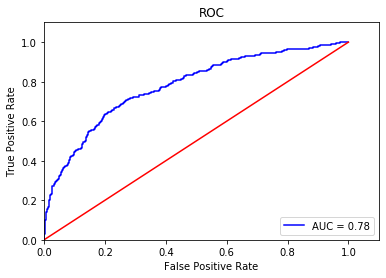

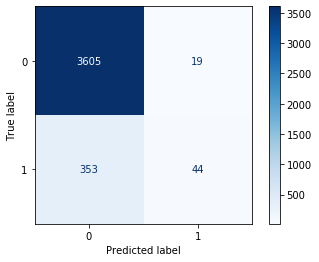

In [116]:
# classify validation data
cb_y_pred = cb_model.best_estimator_.predict(X_val)
cb_y_pred_proba = cb_model.best_estimator_.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, cb_y_pred_proba)
f1_sco = f1_score(y_val, cb_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# plot ROC Curve
plot_roc_curve(cb_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(cb_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["Catboost w/ Feature Creation", auc_sco, f1_sco]

F1 Score with proability of 0.65  : 0.053268765133171914


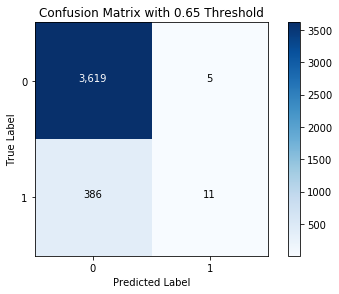

Test data predictions min churn probability: 0.000378451488022594
Test data predictions max churn probability: 0.8768542277526785
Number of churns predicted above threshold: 24


In [117]:
# set threshold for churn prediction
threshold = 0.65

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(cb_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = cb_model.best_estimator_.predict(test_clean)
y_pred_proba = cb_model.best_estimator_.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

In [119]:
cb_model.best_estimator_._get_params()

{'random_seed': 42,
 'depth': 6,
 'loss_function': 'Logloss',
 'iterations': 500,
 'l2_leaf_reg': 1,
 'learning_rate': 0.03}

## AdaBoost Classifier w/ CatBoost Parameter

0:	learn: 0.6584875	total: 11.1ms	remaining: 5.56s
1:	learn: 0.6266643	total: 25ms	remaining: 6.24s
2:	learn: 0.5986184	total: 34.3ms	remaining: 5.68s
3:	learn: 0.5730216	total: 44.6ms	remaining: 5.52s
4:	learn: 0.5493680	total: 53.9ms	remaining: 5.33s
5:	learn: 0.5280635	total: 63.1ms	remaining: 5.19s
6:	learn: 0.5076135	total: 75.3ms	remaining: 5.3s
7:	learn: 0.4893561	total: 85.5ms	remaining: 5.26s
8:	learn: 0.4720443	total: 94.8ms	remaining: 5.17s
9:	learn: 0.4563119	total: 104ms	remaining: 5.1s
10:	learn: 0.4420313	total: 113ms	remaining: 5.04s
11:	learn: 0.4287511	total: 123ms	remaining: 5s
12:	learn: 0.4168144	total: 132ms	remaining: 4.96s
13:	learn: 0.4067633	total: 142ms	remaining: 4.92s
14:	learn: 0.3962984	total: 152ms	remaining: 4.91s
15:	learn: 0.3875657	total: 161ms	remaining: 4.88s
16:	learn: 0.3796432	total: 171ms	remaining: 4.86s
17:	learn: 0.3712736	total: 181ms	remaining: 4.84s
18:	learn: 0.3634413	total: 192ms	remaining: 4.86s
19:	learn: 0.3572370	total: 201ms	remai

174:	learn: 0.2313880	total: 1.75s	remaining: 3.25s
175:	learn: 0.2312059	total: 1.76s	remaining: 3.24s
176:	learn: 0.2310110	total: 1.77s	remaining: 3.24s
177:	learn: 0.2308289	total: 1.78s	remaining: 3.23s
178:	learn: 0.2306101	total: 1.79s	remaining: 3.22s
179:	learn: 0.2304839	total: 1.8s	remaining: 3.21s
180:	learn: 0.2302313	total: 1.81s	remaining: 3.2s
181:	learn: 0.2301168	total: 1.82s	remaining: 3.19s
182:	learn: 0.2299633	total: 1.83s	remaining: 3.17s
183:	learn: 0.2298591	total: 1.84s	remaining: 3.16s
184:	learn: 0.2295175	total: 1.85s	remaining: 3.15s
185:	learn: 0.2293624	total: 1.86s	remaining: 3.14s
186:	learn: 0.2291704	total: 1.87s	remaining: 3.13s
187:	learn: 0.2290076	total: 1.88s	remaining: 3.12s
188:	learn: 0.2288741	total: 1.89s	remaining: 3.11s
189:	learn: 0.2286335	total: 1.9s	remaining: 3.1s
190:	learn: 0.2284922	total: 1.91s	remaining: 3.09s
191:	learn: 0.2283872	total: 1.92s	remaining: 3.08s
192:	learn: 0.2282013	total: 1.93s	remaining: 3.07s
193:	learn: 0.22

335:	learn: 0.2052089	total: 3.34s	remaining: 1.63s
336:	learn: 0.2050640	total: 3.35s	remaining: 1.62s
337:	learn: 0.2049163	total: 3.36s	remaining: 1.61s
338:	learn: 0.2048201	total: 3.37s	remaining: 1.6s
339:	learn: 0.2046667	total: 3.38s	remaining: 1.59s
340:	learn: 0.2044996	total: 3.39s	remaining: 1.58s
341:	learn: 0.2043945	total: 3.4s	remaining: 1.57s
342:	learn: 0.2042905	total: 3.41s	remaining: 1.56s
343:	learn: 0.2041257	total: 3.42s	remaining: 1.55s
344:	learn: 0.2039865	total: 3.43s	remaining: 1.54s
345:	learn: 0.2038654	total: 3.44s	remaining: 1.53s
346:	learn: 0.2037215	total: 3.45s	remaining: 1.52s
347:	learn: 0.2036101	total: 3.46s	remaining: 1.51s
348:	learn: 0.2035303	total: 3.47s	remaining: 1.5s
349:	learn: 0.2033048	total: 3.48s	remaining: 1.49s
350:	learn: 0.2032148	total: 3.49s	remaining: 1.48s
351:	learn: 0.2031565	total: 3.5s	remaining: 1.47s
352:	learn: 0.2030233	total: 3.51s	remaining: 1.46s
353:	learn: 0.2029166	total: 3.52s	remaining: 1.45s
354:	learn: 0.20

0:	learn: 0.6905948	total: 13.9ms	remaining: 6.93s
1:	learn: 0.6881288	total: 23.1ms	remaining: 5.75s
2:	learn: 0.6857921	total: 32.7ms	remaining: 5.42s
3:	learn: 0.6842023	total: 44.9ms	remaining: 5.57s
4:	learn: 0.6821944	total: 55.4ms	remaining: 5.49s
5:	learn: 0.6801825	total: 64.8ms	remaining: 5.33s
6:	learn: 0.6785023	total: 74.8ms	remaining: 5.27s
7:	learn: 0.6769747	total: 85ms	remaining: 5.22s
8:	learn: 0.6758382	total: 93.5ms	remaining: 5.1s
9:	learn: 0.6740387	total: 104ms	remaining: 5.09s
10:	learn: 0.6726113	total: 113ms	remaining: 5.02s
11:	learn: 0.6703384	total: 123ms	remaining: 4.99s
12:	learn: 0.6689401	total: 137ms	remaining: 5.15s
13:	learn: 0.6673822	total: 147ms	remaining: 5.1s
14:	learn: 0.6661947	total: 156ms	remaining: 5.04s
15:	learn: 0.6649358	total: 166ms	remaining: 5.03s
16:	learn: 0.6634764	total: 175ms	remaining: 4.98s
17:	learn: 0.6625685	total: 184ms	remaining: 4.93s
18:	learn: 0.6614675	total: 194ms	remaining: 4.91s
19:	learn: 0.6601214	total: 203ms	re

161:	learn: 0.5496431	total: 1.64s	remaining: 3.43s
162:	learn: 0.5488708	total: 1.65s	remaining: 3.42s
163:	learn: 0.5484544	total: 1.66s	remaining: 3.41s
164:	learn: 0.5477786	total: 1.67s	remaining: 3.4s
165:	learn: 0.5471770	total: 1.68s	remaining: 3.39s
166:	learn: 0.5468057	total: 1.69s	remaining: 3.37s
167:	learn: 0.5461197	total: 1.7s	remaining: 3.36s
168:	learn: 0.5453351	total: 1.71s	remaining: 3.36s
169:	learn: 0.5445644	total: 1.73s	remaining: 3.36s
170:	learn: 0.5441147	total: 1.74s	remaining: 3.34s
171:	learn: 0.5435332	total: 1.75s	remaining: 3.33s
172:	learn: 0.5428545	total: 1.76s	remaining: 3.32s
173:	learn: 0.5422921	total: 1.77s	remaining: 3.31s
174:	learn: 0.5417694	total: 1.78s	remaining: 3.3s
175:	learn: 0.5412701	total: 1.79s	remaining: 3.29s
176:	learn: 0.5408266	total: 1.8s	remaining: 3.28s
177:	learn: 0.5400014	total: 1.81s	remaining: 3.27s
178:	learn: 0.5392505	total: 1.82s	remaining: 3.26s
179:	learn: 0.5386625	total: 1.83s	remaining: 3.25s
180:	learn: 0.53

331:	learn: 0.4587071	total: 3.37s	remaining: 1.7s
332:	learn: 0.4583214	total: 3.38s	remaining: 1.69s
333:	learn: 0.4579711	total: 3.39s	remaining: 1.68s
334:	learn: 0.4575151	total: 3.4s	remaining: 1.67s
335:	learn: 0.4571129	total: 3.41s	remaining: 1.66s
336:	learn: 0.4567107	total: 3.42s	remaining: 1.65s
337:	learn: 0.4562170	total: 3.43s	remaining: 1.64s
338:	learn: 0.4558893	total: 3.44s	remaining: 1.63s
339:	learn: 0.4552034	total: 3.44s	remaining: 1.62s
340:	learn: 0.4547311	total: 3.46s	remaining: 1.61s
341:	learn: 0.4542952	total: 3.46s	remaining: 1.6s
342:	learn: 0.4538676	total: 3.47s	remaining: 1.59s
343:	learn: 0.4533622	total: 3.48s	remaining: 1.58s
344:	learn: 0.4529829	total: 3.49s	remaining: 1.57s
345:	learn: 0.4525322	total: 3.5s	remaining: 1.56s
346:	learn: 0.4521416	total: 3.51s	remaining: 1.55s
347:	learn: 0.4517089	total: 3.52s	remaining: 1.54s
348:	learn: 0.4511587	total: 3.53s	remaining: 1.53s
349:	learn: 0.4508856	total: 3.54s	remaining: 1.52s
350:	learn: 0.45

0:	learn: 0.6922741	total: 9.96ms	remaining: 4.97s
1:	learn: 0.6916839	total: 20.7ms	remaining: 5.17s
2:	learn: 0.6909555	total: 32.9ms	remaining: 5.45s
3:	learn: 0.6903731	total: 43.3ms	remaining: 5.37s
4:	learn: 0.6894596	total: 53.1ms	remaining: 5.25s
5:	learn: 0.6887991	total: 63.8ms	remaining: 5.25s
6:	learn: 0.6878503	total: 72.7ms	remaining: 5.12s
7:	learn: 0.6870894	total: 83ms	remaining: 5.1s
8:	learn: 0.6867957	total: 91.8ms	remaining: 5.01s
9:	learn: 0.6862079	total: 101ms	remaining: 4.96s
10:	learn: 0.6858449	total: 111ms	remaining: 4.94s
11:	learn: 0.6852000	total: 120ms	remaining: 4.89s
12:	learn: 0.6844924	total: 131ms	remaining: 4.92s
13:	learn: 0.6840333	total: 141ms	remaining: 4.89s
14:	learn: 0.6834965	total: 151ms	remaining: 4.87s
15:	learn: 0.6830677	total: 162ms	remaining: 4.89s
16:	learn: 0.6825424	total: 171ms	remaining: 4.86s
17:	learn: 0.6813502	total: 181ms	remaining: 4.85s
18:	learn: 0.6804450	total: 192ms	remaining: 4.85s
19:	learn: 0.6793988	total: 201ms	r

170:	learn: 0.5831743	total: 1.73s	remaining: 3.33s
171:	learn: 0.5825424	total: 1.74s	remaining: 3.33s
172:	learn: 0.5817415	total: 1.75s	remaining: 3.31s
173:	learn: 0.5813694	total: 1.76s	remaining: 3.3s
174:	learn: 0.5809046	total: 1.77s	remaining: 3.29s
175:	learn: 0.5800871	total: 1.78s	remaining: 3.28s
176:	learn: 0.5796175	total: 1.79s	remaining: 3.28s
177:	learn: 0.5788982	total: 1.81s	remaining: 3.27s
178:	learn: 0.5780183	total: 1.82s	remaining: 3.26s
179:	learn: 0.5777287	total: 1.83s	remaining: 3.25s
180:	learn: 0.5771435	total: 1.84s	remaining: 3.24s
181:	learn: 0.5765278	total: 1.85s	remaining: 3.23s
182:	learn: 0.5760842	total: 1.86s	remaining: 3.22s
183:	learn: 0.5757373	total: 1.87s	remaining: 3.21s
184:	learn: 0.5752351	total: 1.88s	remaining: 3.19s
185:	learn: 0.5747637	total: 1.89s	remaining: 3.18s
186:	learn: 0.5742219	total: 1.9s	remaining: 3.17s
187:	learn: 0.5733859	total: 1.91s	remaining: 3.16s
188:	learn: 0.5728409	total: 1.92s	remaining: 3.15s
189:	learn: 0.

332:	learn: 0.5014113	total: 3.34s	remaining: 1.68s
333:	learn: 0.5009794	total: 3.35s	remaining: 1.67s
334:	learn: 0.5005653	total: 3.36s	remaining: 1.66s
335:	learn: 0.5000079	total: 3.38s	remaining: 1.65s
336:	learn: 0.4996350	total: 3.38s	remaining: 1.64s
337:	learn: 0.4989584	total: 3.39s	remaining: 1.63s
338:	learn: 0.4984977	total: 3.4s	remaining: 1.62s
339:	learn: 0.4983072	total: 3.41s	remaining: 1.61s
340:	learn: 0.4979033	total: 3.42s	remaining: 1.59s
341:	learn: 0.4974464	total: 3.43s	remaining: 1.58s
342:	learn: 0.4969821	total: 3.44s	remaining: 1.57s
343:	learn: 0.4966073	total: 3.45s	remaining: 1.56s
344:	learn: 0.4962447	total: 3.46s	remaining: 1.55s
345:	learn: 0.4958481	total: 3.47s	remaining: 1.54s
346:	learn: 0.4955292	total: 3.48s	remaining: 1.53s
347:	learn: 0.4950438	total: 3.49s	remaining: 1.52s
348:	learn: 0.4944908	total: 3.5s	remaining: 1.51s
349:	learn: 0.4938589	total: 3.51s	remaining: 1.5s
350:	learn: 0.4932965	total: 3.52s	remaining: 1.49s
351:	learn: 0.4

0:	learn: 0.6926846	total: 11ms	remaining: 5.47s
1:	learn: 0.6922189	total: 20.2ms	remaining: 5.02s
2:	learn: 0.6916592	total: 28.8ms	remaining: 4.78s
3:	learn: 0.6912897	total: 38.4ms	remaining: 4.76s
4:	learn: 0.6907522	total: 48.1ms	remaining: 4.76s
5:	learn: 0.6899782	total: 56.9ms	remaining: 4.69s
6:	learn: 0.6893657	total: 66.1ms	remaining: 4.65s
7:	learn: 0.6886758	total: 75ms	remaining: 4.61s
8:	learn: 0.6880857	total: 84.6ms	remaining: 4.62s
9:	learn: 0.6876628	total: 93.9ms	remaining: 4.6s
10:	learn: 0.6873440	total: 103ms	remaining: 4.56s
11:	learn: 0.6869227	total: 112ms	remaining: 4.55s
12:	learn: 0.6864968	total: 123ms	remaining: 4.61s
13:	learn: 0.6860494	total: 134ms	remaining: 4.65s
14:	learn: 0.6855189	total: 145ms	remaining: 4.68s
15:	learn: 0.6849551	total: 154ms	remaining: 4.67s
16:	learn: 0.6843471	total: 163ms	remaining: 4.64s
17:	learn: 0.6835073	total: 173ms	remaining: 4.64s
18:	learn: 0.6830060	total: 183ms	remaining: 4.64s
19:	learn: 0.6821693	total: 193ms	re

161:	learn: 0.5980857	total: 1.65s	remaining: 3.43s
162:	learn: 0.5976343	total: 1.66s	remaining: 3.42s
163:	learn: 0.5973610	total: 1.66s	remaining: 3.41s
164:	learn: 0.5969259	total: 1.67s	remaining: 3.4s
165:	learn: 0.5963829	total: 1.68s	remaining: 3.39s
166:	learn: 0.5959074	total: 1.69s	remaining: 3.38s
167:	learn: 0.5952305	total: 1.7s	remaining: 3.37s
168:	learn: 0.5944397	total: 1.71s	remaining: 3.35s
169:	learn: 0.5938504	total: 1.72s	remaining: 3.34s
170:	learn: 0.5932502	total: 1.73s	remaining: 3.33s
171:	learn: 0.5927034	total: 1.74s	remaining: 3.32s
172:	learn: 0.5920810	total: 1.75s	remaining: 3.31s
173:	learn: 0.5913685	total: 1.76s	remaining: 3.3s
174:	learn: 0.5909115	total: 1.77s	remaining: 3.29s
175:	learn: 0.5903087	total: 1.78s	remaining: 3.28s
176:	learn: 0.5897134	total: 1.79s	remaining: 3.27s
177:	learn: 0.5887840	total: 1.8s	remaining: 3.26s
178:	learn: 0.5882109	total: 1.81s	remaining: 3.25s
179:	learn: 0.5879983	total: 1.82s	remaining: 3.24s
180:	learn: 0.58

332:	learn: 0.5142384	total: 3.36s	remaining: 1.69s
333:	learn: 0.5138144	total: 3.37s	remaining: 1.68s
334:	learn: 0.5134663	total: 3.38s	remaining: 1.67s
335:	learn: 0.5131000	total: 3.4s	remaining: 1.66s
336:	learn: 0.5127450	total: 3.4s	remaining: 1.65s
337:	learn: 0.5121176	total: 3.42s	remaining: 1.64s
338:	learn: 0.5114312	total: 3.43s	remaining: 1.63s
339:	learn: 0.5109742	total: 3.44s	remaining: 1.62s
340:	learn: 0.5106793	total: 3.44s	remaining: 1.61s
341:	learn: 0.5103326	total: 3.45s	remaining: 1.59s
342:	learn: 0.5099377	total: 3.46s	remaining: 1.58s
343:	learn: 0.5096341	total: 3.47s	remaining: 1.57s
344:	learn: 0.5092827	total: 3.48s	remaining: 1.56s
345:	learn: 0.5089029	total: 3.49s	remaining: 1.55s
346:	learn: 0.5084514	total: 3.5s	remaining: 1.54s
347:	learn: 0.5079621	total: 3.51s	remaining: 1.53s
348:	learn: 0.5074817	total: 3.52s	remaining: 1.52s
349:	learn: 0.5070937	total: 3.53s	remaining: 1.51s
350:	learn: 0.5065264	total: 3.54s	remaining: 1.5s
351:	learn: 0.50

0:	learn: 0.6928932	total: 10.1ms	remaining: 5.06s
1:	learn: 0.6921259	total: 24.1ms	remaining: 5.99s
2:	learn: 0.6914162	total: 33ms	remaining: 5.47s
3:	learn: 0.6908890	total: 47.9ms	remaining: 5.94s
4:	learn: 0.6905349	total: 62.2ms	remaining: 6.15s
5:	learn: 0.6899637	total: 71.9ms	remaining: 5.92s
6:	learn: 0.6892307	total: 81.1ms	remaining: 5.71s
7:	learn: 0.6886575	total: 90.2ms	remaining: 5.54s
8:	learn: 0.6881624	total: 99.9ms	remaining: 5.45s
9:	learn: 0.6877698	total: 109ms	remaining: 5.33s
10:	learn: 0.6874486	total: 119ms	remaining: 5.28s
11:	learn: 0.6870844	total: 129ms	remaining: 5.23s
12:	learn: 0.6865653	total: 138ms	remaining: 5.17s
13:	learn: 0.6862602	total: 147ms	remaining: 5.12s
14:	learn: 0.6856504	total: 157ms	remaining: 5.09s
15:	learn: 0.6852959	total: 166ms	remaining: 5.04s
16:	learn: 0.6847815	total: 176ms	remaining: 5s
17:	learn: 0.6839876	total: 185ms	remaining: 4.96s
18:	learn: 0.6833406	total: 196ms	remaining: 4.96s
19:	learn: 0.6828183	total: 205ms	rem

170:	learn: 0.5983440	total: 1.73s	remaining: 3.33s
171:	learn: 0.5979708	total: 1.74s	remaining: 3.32s
172:	learn: 0.5973037	total: 1.75s	remaining: 3.31s
173:	learn: 0.5969113	total: 1.76s	remaining: 3.3s
174:	learn: 0.5963904	total: 1.77s	remaining: 3.29s
175:	learn: 0.5956856	total: 1.78s	remaining: 3.28s
176:	learn: 0.5953079	total: 1.79s	remaining: 3.26s
177:	learn: 0.5946491	total: 1.8s	remaining: 3.25s
178:	learn: 0.5941223	total: 1.81s	remaining: 3.24s
179:	learn: 0.5935514	total: 1.82s	remaining: 3.23s
180:	learn: 0.5931837	total: 1.83s	remaining: 3.22s
181:	learn: 0.5925384	total: 1.84s	remaining: 3.21s
182:	learn: 0.5920289	total: 1.85s	remaining: 3.2s
183:	learn: 0.5916912	total: 1.86s	remaining: 3.19s
184:	learn: 0.5913377	total: 1.86s	remaining: 3.18s
185:	learn: 0.5908992	total: 1.88s	remaining: 3.17s
186:	learn: 0.5905488	total: 1.89s	remaining: 3.17s
187:	learn: 0.5900588	total: 1.9s	remaining: 3.16s
188:	learn: 0.5892256	total: 1.91s	remaining: 3.15s
189:	learn: 0.58

338:	learn: 0.5169493	total: 3.45s	remaining: 1.64s
339:	learn: 0.5165797	total: 3.46s	remaining: 1.63s
340:	learn: 0.5162733	total: 3.47s	remaining: 1.62s
341:	learn: 0.5159654	total: 3.48s	remaining: 1.61s
342:	learn: 0.5154916	total: 3.5s	remaining: 1.6s
343:	learn: 0.5150992	total: 3.5s	remaining: 1.59s
344:	learn: 0.5148508	total: 3.52s	remaining: 1.58s
345:	learn: 0.5144437	total: 3.52s	remaining: 1.57s
346:	learn: 0.5142494	total: 3.53s	remaining: 1.56s
347:	learn: 0.5137246	total: 3.54s	remaining: 1.55s
348:	learn: 0.5132105	total: 3.55s	remaining: 1.54s
349:	learn: 0.5125398	total: 3.56s	remaining: 1.53s
350:	learn: 0.5119576	total: 3.58s	remaining: 1.52s
351:	learn: 0.5114287	total: 3.58s	remaining: 1.51s
352:	learn: 0.5111195	total: 3.6s	remaining: 1.5s
353:	learn: 0.5108005	total: 3.6s	remaining: 1.49s
354:	learn: 0.5101429	total: 3.61s	remaining: 1.48s
355:	learn: 0.5096483	total: 3.62s	remaining: 1.47s
356:	learn: 0.5091736	total: 3.63s	remaining: 1.46s
357:	learn: 0.5087

497:	learn: 0.4522322	total: 5.13s	remaining: 20.6ms
498:	learn: 0.4517172	total: 5.14s	remaining: 10.3ms
499:	learn: 0.4514641	total: 5.15s	remaining: 0us
0:	learn: 0.6926226	total: 10.6ms	remaining: 5.3s
1:	learn: 0.6922247	total: 19.6ms	remaining: 4.89s
2:	learn: 0.6916518	total: 29.8ms	remaining: 4.94s
3:	learn: 0.6906716	total: 40.5ms	remaining: 5.02s
4:	learn: 0.6904209	total: 49.9ms	remaining: 4.94s
5:	learn: 0.6899183	total: 60.7ms	remaining: 5s
6:	learn: 0.6892341	total: 70ms	remaining: 4.93s
7:	learn: 0.6886620	total: 81.1ms	remaining: 4.99s
8:	learn: 0.6880951	total: 91.4ms	remaining: 4.99s
9:	learn: 0.6877138	total: 101ms	remaining: 4.93s
10:	learn: 0.6871287	total: 110ms	remaining: 4.91s
11:	learn: 0.6867722	total: 122ms	remaining: 4.97s
12:	learn: 0.6862805	total: 132ms	remaining: 4.94s
13:	learn: 0.6859363	total: 141ms	remaining: 4.9s
14:	learn: 0.6852713	total: 155ms	remaining: 5s
15:	learn: 0.6848678	total: 170ms	remaining: 5.15s
16:	learn: 0.6843622	total: 181ms	remai

170:	learn: 0.5983823	total: 1.77s	remaining: 3.41s
171:	learn: 0.5979131	total: 1.78s	remaining: 3.4s
172:	learn: 0.5973785	total: 1.79s	remaining: 3.39s
173:	learn: 0.5970144	total: 1.8s	remaining: 3.37s
174:	learn: 0.5965719	total: 1.81s	remaining: 3.37s
175:	learn: 0.5958697	total: 1.82s	remaining: 3.35s
176:	learn: 0.5953504	total: 1.83s	remaining: 3.34s
177:	learn: 0.5947140	total: 1.84s	remaining: 3.34s
178:	learn: 0.5940077	total: 1.86s	remaining: 3.33s
179:	learn: 0.5935867	total: 1.87s	remaining: 3.32s
180:	learn: 0.5930432	total: 1.88s	remaining: 3.31s
181:	learn: 0.5924095	total: 1.89s	remaining: 3.3s
182:	learn: 0.5919346	total: 1.9s	remaining: 3.28s
183:	learn: 0.5916176	total: 1.91s	remaining: 3.27s
184:	learn: 0.5909639	total: 1.92s	remaining: 3.26s
185:	learn: 0.5905259	total: 1.93s	remaining: 3.25s
186:	learn: 0.5899674	total: 1.94s	remaining: 3.24s
187:	learn: 0.5894918	total: 1.95s	remaining: 3.23s
188:	learn: 0.5886634	total: 1.96s	remaining: 3.23s
189:	learn: 0.58

338:	learn: 0.5158914	total: 3.49s	remaining: 1.66s
339:	learn: 0.5154724	total: 3.5s	remaining: 1.65s
340:	learn: 0.5151991	total: 3.51s	remaining: 1.64s
341:	learn: 0.5148269	total: 3.52s	remaining: 1.63s
342:	learn: 0.5144436	total: 3.53s	remaining: 1.62s
343:	learn: 0.5141435	total: 3.54s	remaining: 1.61s
344:	learn: 0.5137284	total: 3.55s	remaining: 1.6s
345:	learn: 0.5134786	total: 3.56s	remaining: 1.59s
346:	learn: 0.5131081	total: 3.57s	remaining: 1.58s
347:	learn: 0.5126850	total: 3.58s	remaining: 1.56s
348:	learn: 0.5122228	total: 3.6s	remaining: 1.55s
349:	learn: 0.5115674	total: 3.61s	remaining: 1.55s
350:	learn: 0.5109452	total: 3.62s	remaining: 1.53s
351:	learn: 0.5103777	total: 3.63s	remaining: 1.52s
352:	learn: 0.5100616	total: 3.64s	remaining: 1.51s
353:	learn: 0.5097016	total: 3.65s	remaining: 1.5s
354:	learn: 0.5090553	total: 3.66s	remaining: 1.49s
355:	learn: 0.5085136	total: 3.67s	remaining: 1.48s
356:	learn: 0.5080353	total: 3.68s	remaining: 1.47s
357:	learn: 0.50

0:	learn: 0.6926485	total: 10.1ms	remaining: 5.06s
1:	learn: 0.6920742	total: 19.6ms	remaining: 4.88s
2:	learn: 0.6913001	total: 28.8ms	remaining: 4.77s
3:	learn: 0.6904692	total: 38.7ms	remaining: 4.8s
4:	learn: 0.6900086	total: 48.4ms	remaining: 4.79s
5:	learn: 0.6893610	total: 57.7ms	remaining: 4.75s
6:	learn: 0.6887023	total: 69.3ms	remaining: 4.88s
7:	learn: 0.6878816	total: 82.5ms	remaining: 5.07s
8:	learn: 0.6874340	total: 94.5ms	remaining: 5.16s
9:	learn: 0.6867709	total: 106ms	remaining: 5.17s
10:	learn: 0.6856792	total: 116ms	remaining: 5.14s
11:	learn: 0.6851584	total: 125ms	remaining: 5.09s
12:	learn: 0.6844655	total: 134ms	remaining: 5.03s
13:	learn: 0.6839013	total: 144ms	remaining: 4.99s
14:	learn: 0.6834173	total: 154ms	remaining: 4.97s
15:	learn: 0.6830516	total: 163ms	remaining: 4.92s
16:	learn: 0.6825320	total: 172ms	remaining: 4.89s
17:	learn: 0.6817622	total: 182ms	remaining: 4.88s
18:	learn: 0.6811922	total: 193ms	remaining: 4.87s
19:	learn: 0.6805041	total: 203ms

170:	learn: 0.5963125	total: 1.73s	remaining: 3.33s
171:	learn: 0.5958548	total: 1.74s	remaining: 3.32s
172:	learn: 0.5953035	total: 1.75s	remaining: 3.31s
173:	learn: 0.5948618	total: 1.76s	remaining: 3.3s
174:	learn: 0.5943421	total: 1.77s	remaining: 3.29s
175:	learn: 0.5935236	total: 1.78s	remaining: 3.28s
176:	learn: 0.5931082	total: 1.79s	remaining: 3.26s
177:	learn: 0.5922253	total: 1.8s	remaining: 3.26s
178:	learn: 0.5916521	total: 1.82s	remaining: 3.26s
179:	learn: 0.5911294	total: 1.83s	remaining: 3.25s
180:	learn: 0.5906950	total: 1.84s	remaining: 3.24s
181:	learn: 0.5900643	total: 1.85s	remaining: 3.23s
182:	learn: 0.5895668	total: 1.86s	remaining: 3.22s
183:	learn: 0.5892021	total: 1.87s	remaining: 3.21s
184:	learn: 0.5884271	total: 1.88s	remaining: 3.19s
185:	learn: 0.5879382	total: 1.89s	remaining: 3.18s
186:	learn: 0.5872846	total: 1.9s	remaining: 3.17s
187:	learn: 0.5867502	total: 1.91s	remaining: 3.17s
188:	learn: 0.5860832	total: 1.92s	remaining: 3.16s
189:	learn: 0.5

334:	learn: 0.5179213	total: 3.4s	remaining: 1.68s
335:	learn: 0.5176811	total: 3.42s	remaining: 1.67s
336:	learn: 0.5173060	total: 3.42s	remaining: 1.66s
337:	learn: 0.5166388	total: 3.44s	remaining: 1.65s
338:	learn: 0.5161744	total: 3.44s	remaining: 1.64s
339:	learn: 0.5157674	total: 3.45s	remaining: 1.63s
340:	learn: 0.5153252	total: 3.46s	remaining: 1.61s
341:	learn: 0.5149620	total: 3.48s	remaining: 1.61s
342:	learn: 0.5145448	total: 3.49s	remaining: 1.59s
343:	learn: 0.5141611	total: 3.5s	remaining: 1.59s
344:	learn: 0.5137253	total: 3.51s	remaining: 1.58s
345:	learn: 0.5134558	total: 3.52s	remaining: 1.57s
346:	learn: 0.5132309	total: 3.53s	remaining: 1.55s
347:	learn: 0.5128299	total: 3.54s	remaining: 1.55s
348:	learn: 0.5122667	total: 3.55s	remaining: 1.53s
349:	learn: 0.5120023	total: 3.56s	remaining: 1.52s
350:	learn: 0.5114915	total: 3.57s	remaining: 1.51s
351:	learn: 0.5112321	total: 3.58s	remaining: 1.5s
352:	learn: 0.5107856	total: 3.59s	remaining: 1.5s
353:	learn: 0.51

0:	learn: 0.6926349	total: 11ms	remaining: 5.49s
1:	learn: 0.6919849	total: 21.4ms	remaining: 5.32s
2:	learn: 0.6911034	total: 31.7ms	remaining: 5.25s
3:	learn: 0.6901773	total: 41.1ms	remaining: 5.1s
4:	learn: 0.6897522	total: 51.3ms	remaining: 5.07s
5:	learn: 0.6891349	total: 61.2ms	remaining: 5.04s
6:	learn: 0.6885154	total: 70.7ms	remaining: 4.98s
7:	learn: 0.6880644	total: 80ms	remaining: 4.92s
8:	learn: 0.6875011	total: 90.1ms	remaining: 4.91s
9:	learn: 0.6868909	total: 101ms	remaining: 4.93s
10:	learn: 0.6858874	total: 111ms	remaining: 4.92s
11:	learn: 0.6852606	total: 120ms	remaining: 4.86s
12:	learn: 0.6847162	total: 130ms	remaining: 4.86s
13:	learn: 0.6842678	total: 139ms	remaining: 4.84s
14:	learn: 0.6834414	total: 149ms	remaining: 4.82s
15:	learn: 0.6828508	total: 159ms	remaining: 4.8s
16:	learn: 0.6822615	total: 168ms	remaining: 4.77s
17:	learn: 0.6815397	total: 177ms	remaining: 4.75s
18:	learn: 0.6810049	total: 187ms	remaining: 4.74s
19:	learn: 0.6804811	total: 199ms	rema

161:	learn: 0.6020693	total: 1.72s	remaining: 3.59s
162:	learn: 0.6017026	total: 1.73s	remaining: 3.58s
163:	learn: 0.6011339	total: 1.74s	remaining: 3.58s
164:	learn: 0.6005667	total: 1.75s	remaining: 3.56s
165:	learn: 0.6003259	total: 1.76s	remaining: 3.55s
166:	learn: 0.5996804	total: 1.78s	remaining: 3.54s
167:	learn: 0.5990670	total: 1.79s	remaining: 3.54s
168:	learn: 0.5986826	total: 1.8s	remaining: 3.53s
169:	learn: 0.5982572	total: 1.81s	remaining: 3.52s
170:	learn: 0.5976250	total: 1.82s	remaining: 3.51s
171:	learn: 0.5969133	total: 1.83s	remaining: 3.5s
172:	learn: 0.5962464	total: 1.84s	remaining: 3.49s
173:	learn: 0.5959649	total: 1.85s	remaining: 3.47s
174:	learn: 0.5949054	total: 1.86s	remaining: 3.46s
175:	learn: 0.5944494	total: 1.88s	remaining: 3.45s
176:	learn: 0.5940995	total: 1.89s	remaining: 3.44s
177:	learn: 0.5934531	total: 1.9s	remaining: 3.43s
178:	learn: 0.5930202	total: 1.91s	remaining: 3.42s
179:	learn: 0.5926263	total: 1.92s	remaining: 3.41s
180:	learn: 0.5

324:	learn: 0.5228458	total: 3.4s	remaining: 1.83s
325:	learn: 0.5223973	total: 3.41s	remaining: 1.82s
326:	learn: 0.5219355	total: 3.42s	remaining: 1.81s
327:	learn: 0.5216457	total: 3.44s	remaining: 1.8s
328:	learn: 0.5211497	total: 3.44s	remaining: 1.79s
329:	learn: 0.5205667	total: 3.46s	remaining: 1.78s
330:	learn: 0.5199441	total: 3.46s	remaining: 1.77s
331:	learn: 0.5194137	total: 3.48s	remaining: 1.76s
332:	learn: 0.5189311	total: 3.48s	remaining: 1.75s
333:	learn: 0.5185413	total: 3.49s	remaining: 1.74s
334:	learn: 0.5180850	total: 3.5s	remaining: 1.73s
335:	learn: 0.5177002	total: 3.51s	remaining: 1.72s
336:	learn: 0.5174259	total: 3.52s	remaining: 1.7s
337:	learn: 0.5169635	total: 3.54s	remaining: 1.7s
338:	learn: 0.5165333	total: 3.55s	remaining: 1.69s
339:	learn: 0.5160879	total: 3.56s	remaining: 1.68s
340:	learn: 0.5155888	total: 3.57s	remaining: 1.67s
341:	learn: 0.5152477	total: 3.58s	remaining: 1.66s
342:	learn: 0.5147604	total: 3.59s	remaining: 1.64s
343:	learn: 0.514

492:	learn: 0.4541748	total: 5.12s	remaining: 72.8ms
493:	learn: 0.4538971	total: 5.13s	remaining: 62.4ms
494:	learn: 0.4535620	total: 5.14s	remaining: 51.9ms
495:	learn: 0.4531385	total: 5.15s	remaining: 41.6ms
496:	learn: 0.4528254	total: 5.16s	remaining: 31.2ms
497:	learn: 0.4524265	total: 5.17s	remaining: 20.8ms
498:	learn: 0.4521656	total: 5.18s	remaining: 10.4ms
499:	learn: 0.4517687	total: 5.19s	remaining: 0us
0:	learn: 0.6921714	total: 10.8ms	remaining: 5.41s
1:	learn: 0.6916309	total: 20ms	remaining: 4.97s
2:	learn: 0.6908767	total: 29.9ms	remaining: 4.95s
3:	learn: 0.6900343	total: 39.6ms	remaining: 4.91s
4:	learn: 0.6892710	total: 49.2ms	remaining: 4.87s
5:	learn: 0.6886377	total: 58.7ms	remaining: 4.83s
6:	learn: 0.6880374	total: 68.5ms	remaining: 4.82s
7:	learn: 0.6875712	total: 77.9ms	remaining: 4.79s
8:	learn: 0.6871350	total: 91.3ms	remaining: 4.98s
9:	learn: 0.6866809	total: 105ms	remaining: 5.13s
10:	learn: 0.6857081	total: 115ms	remaining: 5.1s
11:	learn: 0.6850347	t

166:	learn: 0.6012727	total: 1.7s	remaining: 3.39s
167:	learn: 0.6008534	total: 1.71s	remaining: 3.38s
168:	learn: 0.5999946	total: 1.72s	remaining: 3.37s
169:	learn: 0.5993801	total: 1.73s	remaining: 3.36s
170:	learn: 0.5987916	total: 1.74s	remaining: 3.35s
171:	learn: 0.5983474	total: 1.75s	remaining: 3.34s
172:	learn: 0.5978311	total: 1.76s	remaining: 3.32s
173:	learn: 0.5971938	total: 1.77s	remaining: 3.32s
174:	learn: 0.5966256	total: 1.78s	remaining: 3.31s
175:	learn: 0.5961066	total: 1.79s	remaining: 3.29s
176:	learn: 0.5955894	total: 1.8s	remaining: 3.29s
177:	learn: 0.5951017	total: 1.81s	remaining: 3.28s
178:	learn: 0.5946596	total: 1.82s	remaining: 3.27s
179:	learn: 0.5939781	total: 1.83s	remaining: 3.26s
180:	learn: 0.5936212	total: 1.84s	remaining: 3.25s
181:	learn: 0.5930555	total: 1.85s	remaining: 3.24s
182:	learn: 0.5922674	total: 1.86s	remaining: 3.23s
183:	learn: 0.5916222	total: 1.88s	remaining: 3.23s
184:	learn: 0.5910710	total: 1.89s	remaining: 3.21s
185:	learn: 0.

335:	learn: 0.5205781	total: 3.51s	remaining: 1.71s
336:	learn: 0.5202470	total: 3.52s	remaining: 1.7s
337:	learn: 0.5196893	total: 3.53s	remaining: 1.69s
338:	learn: 0.5194292	total: 3.54s	remaining: 1.68s
339:	learn: 0.5190846	total: 3.55s	remaining: 1.67s
340:	learn: 0.5185117	total: 3.56s	remaining: 1.66s
341:	learn: 0.5181507	total: 3.57s	remaining: 1.65s
342:	learn: 0.5175562	total: 3.58s	remaining: 1.64s
343:	learn: 0.5173845	total: 3.59s	remaining: 1.63s
344:	learn: 0.5168068	total: 3.6s	remaining: 1.62s
345:	learn: 0.5162912	total: 3.61s	remaining: 1.6s
346:	learn: 0.5158431	total: 3.62s	remaining: 1.59s
347:	learn: 0.5154975	total: 3.63s	remaining: 1.58s
348:	learn: 0.5150791	total: 3.64s	remaining: 1.57s
349:	learn: 0.5144157	total: 3.65s	remaining: 1.56s
350:	learn: 0.5139247	total: 3.66s	remaining: 1.55s
351:	learn: 0.5135190	total: 3.67s	remaining: 1.54s
352:	learn: 0.5131943	total: 3.68s	remaining: 1.53s
353:	learn: 0.5126129	total: 3.69s	remaining: 1.52s
354:	learn: 0.5

0:	learn: 0.6920168	total: 11.1ms	remaining: 5.55s
1:	learn: 0.6914860	total: 21.1ms	remaining: 5.26s
2:	learn: 0.6908878	total: 38.5ms	remaining: 6.37s
3:	learn: 0.6903663	total: 48.7ms	remaining: 6.03s
4:	learn: 0.6899451	total: 57.7ms	remaining: 5.71s
5:	learn: 0.6890944	total: 68ms	remaining: 5.6s
6:	learn: 0.6884968	total: 76.9ms	remaining: 5.41s
7:	learn: 0.6879887	total: 87.1ms	remaining: 5.36s
8:	learn: 0.6875738	total: 96.9ms	remaining: 5.29s
9:	learn: 0.6869414	total: 106ms	remaining: 5.21s
10:	learn: 0.6859626	total: 116ms	remaining: 5.17s
11:	learn: 0.6853531	total: 126ms	remaining: 5.13s
12:	learn: 0.6846975	total: 135ms	remaining: 5.05s
13:	learn: 0.6838578	total: 145ms	remaining: 5.02s
14:	learn: 0.6833354	total: 154ms	remaining: 4.99s
15:	learn: 0.6830132	total: 164ms	remaining: 4.97s
16:	learn: 0.6824375	total: 174ms	remaining: 4.94s
17:	learn: 0.6817610	total: 183ms	remaining: 4.91s
18:	learn: 0.6812014	total: 193ms	remaining: 4.9s
19:	learn: 0.6808490	total: 211ms	re

165:	learn: 0.6004660	total: 1.69s	remaining: 3.4s
166:	learn: 0.5998834	total: 1.7s	remaining: 3.39s
167:	learn: 0.5992613	total: 1.71s	remaining: 3.38s
168:	learn: 0.5988689	total: 1.72s	remaining: 3.37s
169:	learn: 0.5983389	total: 1.73s	remaining: 3.36s
170:	learn: 0.5977178	total: 1.74s	remaining: 3.35s
171:	learn: 0.5970600	total: 1.75s	remaining: 3.33s
172:	learn: 0.5964440	total: 1.76s	remaining: 3.32s
173:	learn: 0.5960850	total: 1.77s	remaining: 3.31s
174:	learn: 0.5954699	total: 1.78s	remaining: 3.3s
175:	learn: 0.5949235	total: 1.79s	remaining: 3.29s
176:	learn: 0.5944833	total: 1.79s	remaining: 3.28s
177:	learn: 0.5937995	total: 1.8s	remaining: 3.27s
178:	learn: 0.5933833	total: 1.82s	remaining: 3.26s
179:	learn: 0.5926979	total: 1.83s	remaining: 3.25s
180:	learn: 0.5922588	total: 1.84s	remaining: 3.24s
181:	learn: 0.5917110	total: 1.85s	remaining: 3.23s
182:	learn: 0.5912076	total: 1.86s	remaining: 3.22s
183:	learn: 0.5908946	total: 1.87s	remaining: 3.21s
184:	learn: 0.59

335:	learn: 0.5173540	total: 3.42s	remaining: 1.67s
336:	learn: 0.5170539	total: 3.43s	remaining: 1.66s
337:	learn: 0.5164612	total: 3.44s	remaining: 1.65s
338:	learn: 0.5161253	total: 3.45s	remaining: 1.64s
339:	learn: 0.5156576	total: 3.46s	remaining: 1.63s
340:	learn: 0.5151673	total: 3.47s	remaining: 1.62s
341:	learn: 0.5148596	total: 3.48s	remaining: 1.61s
342:	learn: 0.5144312	total: 3.49s	remaining: 1.6s
343:	learn: 0.5141106	total: 3.5s	remaining: 1.59s
344:	learn: 0.5134740	total: 3.51s	remaining: 1.58s
345:	learn: 0.5131910	total: 3.52s	remaining: 1.57s
346:	learn: 0.5128141	total: 3.53s	remaining: 1.56s
347:	learn: 0.5123059	total: 3.54s	remaining: 1.54s
348:	learn: 0.5118702	total: 3.55s	remaining: 1.53s
349:	learn: 0.5114686	total: 3.56s	remaining: 1.52s
350:	learn: 0.5110251	total: 3.57s	remaining: 1.51s
351:	learn: 0.5105463	total: 3.58s	remaining: 1.5s
352:	learn: 0.5100355	total: 3.59s	remaining: 1.49s
353:	learn: 0.5096378	total: 3.6s	remaining: 1.48s
354:	learn: 0.50

0:	learn: 0.6922135	total: 11.4ms	remaining: 5.67s
1:	learn: 0.6917882	total: 21.6ms	remaining: 5.37s
2:	learn: 0.6909747	total: 31.7ms	remaining: 5.25s
3:	learn: 0.6904810	total: 41.7ms	remaining: 5.17s
4:	learn: 0.6897188	total: 50.5ms	remaining: 5s
5:	learn: 0.6887532	total: 61.8ms	remaining: 5.09s
6:	learn: 0.6881552	total: 72ms	remaining: 5.07s
7:	learn: 0.6877478	total: 81.4ms	remaining: 5s
8:	learn: 0.6871228	total: 91.6ms	remaining: 5s
9:	learn: 0.6865878	total: 101ms	remaining: 4.96s
10:	learn: 0.6857851	total: 111ms	remaining: 4.92s
11:	learn: 0.6851947	total: 120ms	remaining: 4.87s
12:	learn: 0.6847969	total: 128ms	remaining: 4.81s
13:	learn: 0.6839913	total: 145ms	remaining: 5.02s
14:	learn: 0.6835277	total: 155ms	remaining: 5s
15:	learn: 0.6829359	total: 164ms	remaining: 4.97s
16:	learn: 0.6824469	total: 174ms	remaining: 4.95s
17:	learn: 0.6817977	total: 184ms	remaining: 4.92s
18:	learn: 0.6812612	total: 193ms	remaining: 4.89s
19:	learn: 0.6808509	total: 203ms	remaining: 4

166:	learn: 0.6005862	total: 1.7s	remaining: 3.4s
167:	learn: 0.5999661	total: 1.71s	remaining: 3.39s
168:	learn: 0.5995931	total: 1.72s	remaining: 3.38s
169:	learn: 0.5991249	total: 1.73s	remaining: 3.36s
170:	learn: 0.5987031	total: 1.74s	remaining: 3.35s
171:	learn: 0.5981122	total: 1.75s	remaining: 3.34s
172:	learn: 0.5975219	total: 1.76s	remaining: 3.33s
173:	learn: 0.5971445	total: 1.77s	remaining: 3.32s
174:	learn: 0.5964516	total: 1.78s	remaining: 3.31s
175:	learn: 0.5958291	total: 1.79s	remaining: 3.3s
176:	learn: 0.5954284	total: 1.8s	remaining: 3.29s
177:	learn: 0.5950484	total: 1.81s	remaining: 3.28s
178:	learn: 0.5946421	total: 1.82s	remaining: 3.27s
179:	learn: 0.5941675	total: 1.83s	remaining: 3.25s
180:	learn: 0.5935800	total: 1.84s	remaining: 3.24s
181:	learn: 0.5930718	total: 1.85s	remaining: 3.23s
182:	learn: 0.5925651	total: 1.86s	remaining: 3.22s
183:	learn: 0.5922709	total: 1.87s	remaining: 3.21s
184:	learn: 0.5918145	total: 1.88s	remaining: 3.21s
185:	learn: 0.59

337:	learn: 0.5177572	total: 3.43s	remaining: 1.64s
338:	learn: 0.5173543	total: 3.44s	remaining: 1.64s
339:	learn: 0.5170442	total: 3.45s	remaining: 1.63s
340:	learn: 0.5166236	total: 3.46s	remaining: 1.61s
341:	learn: 0.5163052	total: 3.47s	remaining: 1.6s
342:	learn: 0.5158750	total: 3.48s	remaining: 1.59s
343:	learn: 0.5155413	total: 3.49s	remaining: 1.58s
344:	learn: 0.5148757	total: 3.5s	remaining: 1.57s
345:	learn: 0.5145145	total: 3.51s	remaining: 1.56s
346:	learn: 0.5142038	total: 3.52s	remaining: 1.55s
347:	learn: 0.5137378	total: 3.53s	remaining: 1.54s
348:	learn: 0.5133058	total: 3.54s	remaining: 1.53s
349:	learn: 0.5129023	total: 3.55s	remaining: 1.52s
350:	learn: 0.5124762	total: 3.56s	remaining: 1.51s
351:	learn: 0.5121979	total: 3.57s	remaining: 1.5s
352:	learn: 0.5119359	total: 3.58s	remaining: 1.49s
353:	learn: 0.5114532	total: 3.59s	remaining: 1.48s
354:	learn: 0.5109334	total: 3.6s	remaining: 1.47s
355:	learn: 0.5105015	total: 3.62s	remaining: 1.46s
356:	learn: 0.50

0:	learn: 0.6922677	total: 11.2ms	remaining: 5.6s
1:	learn: 0.6916260	total: 20.8ms	remaining: 5.17s
2:	learn: 0.6908740	total: 29.7ms	remaining: 4.92s
3:	learn: 0.6904591	total: 39.3ms	remaining: 4.87s
4:	learn: 0.6895857	total: 48.4ms	remaining: 4.79s
5:	learn: 0.6890248	total: 58.1ms	remaining: 4.79s
6:	learn: 0.6883577	total: 67.7ms	remaining: 4.77s
7:	learn: 0.6877284	total: 77ms	remaining: 4.73s
8:	learn: 0.6872304	total: 86.2ms	remaining: 4.71s
9:	learn: 0.6866029	total: 95.3ms	remaining: 4.67s
10:	learn: 0.6859267	total: 105ms	remaining: 4.69s
11:	learn: 0.6852585	total: 115ms	remaining: 4.66s
12:	learn: 0.6848233	total: 125ms	remaining: 4.67s
13:	learn: 0.6843484	total: 138ms	remaining: 4.77s
14:	learn: 0.6837026	total: 147ms	remaining: 4.76s
15:	learn: 0.6833944	total: 156ms	remaining: 4.73s
16:	learn: 0.6827915	total: 166ms	remaining: 4.73s
17:	learn: 0.6821654	total: 176ms	remaining: 4.71s
18:	learn: 0.6815681	total: 185ms	remaining: 4.69s
19:	learn: 0.6812246	total: 195ms	

166:	learn: 0.6039023	total: 1.67s	remaining: 3.34s
167:	learn: 0.6033988	total: 1.69s	remaining: 3.33s
168:	learn: 0.6029572	total: 1.69s	remaining: 3.32s
169:	learn: 0.6024894	total: 1.7s	remaining: 3.31s
170:	learn: 0.6020785	total: 1.71s	remaining: 3.3s
171:	learn: 0.6014366	total: 1.72s	remaining: 3.29s
172:	learn: 0.6007668	total: 1.73s	remaining: 3.28s
173:	learn: 0.6004182	total: 1.74s	remaining: 3.27s
174:	learn: 0.5998145	total: 1.75s	remaining: 3.25s
175:	learn: 0.5992168	total: 1.76s	remaining: 3.24s
176:	learn: 0.5989707	total: 1.77s	remaining: 3.24s
177:	learn: 0.5984247	total: 1.79s	remaining: 3.23s
178:	learn: 0.5979449	total: 1.79s	remaining: 3.22s
179:	learn: 0.5973983	total: 1.8s	remaining: 3.21s
180:	learn: 0.5968319	total: 1.81s	remaining: 3.2s
181:	learn: 0.5962880	total: 1.82s	remaining: 3.19s
182:	learn: 0.5957055	total: 1.83s	remaining: 3.17s
183:	learn: 0.5953642	total: 1.84s	remaining: 3.16s
184:	learn: 0.5949110	total: 1.85s	remaining: 3.15s
185:	learn: 0.59

341:	learn: 0.5190815	total: 3.41s	remaining: 1.58s
342:	learn: 0.5184099	total: 3.42s	remaining: 1.56s
343:	learn: 0.5179811	total: 3.43s	remaining: 1.56s
344:	learn: 0.5173264	total: 3.44s	remaining: 1.54s
345:	learn: 0.5170644	total: 3.45s	remaining: 1.53s
346:	learn: 0.5166329	total: 3.46s	remaining: 1.52s
347:	learn: 0.5161394	total: 3.47s	remaining: 1.51s
348:	learn: 0.5157135	total: 3.48s	remaining: 1.51s
349:	learn: 0.5153348	total: 3.49s	remaining: 1.5s
350:	learn: 0.5147846	total: 3.5s	remaining: 1.49s
351:	learn: 0.5142643	total: 3.51s	remaining: 1.48s
352:	learn: 0.5138992	total: 3.52s	remaining: 1.47s
353:	learn: 0.5134925	total: 3.53s	remaining: 1.46s
354:	learn: 0.5128273	total: 3.55s	remaining: 1.45s
355:	learn: 0.5124638	total: 3.56s	remaining: 1.44s
356:	learn: 0.5120801	total: 3.56s	remaining: 1.43s
357:	learn: 0.5114441	total: 3.58s	remaining: 1.42s
358:	learn: 0.5110638	total: 3.58s	remaining: 1.41s
359:	learn: 0.5104015	total: 3.6s	remaining: 1.4s
360:	learn: 0.51

1:	learn: 0.6922024	total: 19.1ms	remaining: 4.75s
2:	learn: 0.6914039	total: 28.7ms	remaining: 4.76s
3:	learn: 0.6906142	total: 38.5ms	remaining: 4.78s
4:	learn: 0.6902049	total: 48.2ms	remaining: 4.77s
5:	learn: 0.6892912	total: 57.6ms	remaining: 4.75s
6:	learn: 0.6886300	total: 66.8ms	remaining: 4.7s
7:	learn: 0.6880288	total: 77ms	remaining: 4.74s
8:	learn: 0.6874330	total: 86.6ms	remaining: 4.72s
9:	learn: 0.6867889	total: 96.3ms	remaining: 4.72s
10:	learn: 0.6860347	total: 106ms	remaining: 4.72s
11:	learn: 0.6851635	total: 120ms	remaining: 4.89s
12:	learn: 0.6845304	total: 131ms	remaining: 4.89s
13:	learn: 0.6842074	total: 142ms	remaining: 4.93s
14:	learn: 0.6836168	total: 152ms	remaining: 4.91s
15:	learn: 0.6832697	total: 161ms	remaining: 4.88s
16:	learn: 0.6827828	total: 172ms	remaining: 4.88s
17:	learn: 0.6821350	total: 181ms	remaining: 4.86s
18:	learn: 0.6817706	total: 191ms	remaining: 4.83s
19:	learn: 0.6809514	total: 201ms	remaining: 4.82s
20:	learn: 0.6803159	total: 210ms	

173:	learn: 0.5984333	total: 1.75s	remaining: 3.27s
174:	learn: 0.5978368	total: 1.76s	remaining: 3.27s
175:	learn: 0.5973364	total: 1.77s	remaining: 3.26s
176:	learn: 0.5969589	total: 1.78s	remaining: 3.25s
177:	learn: 0.5965606	total: 1.79s	remaining: 3.24s
178:	learn: 0.5959460	total: 1.8s	remaining: 3.23s
179:	learn: 0.5954863	total: 1.81s	remaining: 3.22s
180:	learn: 0.5950504	total: 1.82s	remaining: 3.21s
181:	learn: 0.5946557	total: 1.83s	remaining: 3.19s
182:	learn: 0.5940607	total: 1.84s	remaining: 3.18s
183:	learn: 0.5938009	total: 1.85s	remaining: 3.17s
184:	learn: 0.5928929	total: 1.86s	remaining: 3.17s
185:	learn: 0.5924098	total: 1.87s	remaining: 3.16s
186:	learn: 0.5918120	total: 1.88s	remaining: 3.15s
187:	learn: 0.5915861	total: 1.9s	remaining: 3.15s
188:	learn: 0.5912331	total: 1.91s	remaining: 3.14s
189:	learn: 0.5908367	total: 1.92s	remaining: 3.13s
190:	learn: 0.5902179	total: 1.93s	remaining: 3.12s
191:	learn: 0.5894028	total: 1.94s	remaining: 3.11s
192:	learn: 0.

340:	learn: 0.5173532	total: 3.41s	remaining: 1.59s
341:	learn: 0.5170655	total: 3.42s	remaining: 1.58s
342:	learn: 0.5164281	total: 3.43s	remaining: 1.57s
343:	learn: 0.5160850	total: 3.44s	remaining: 1.56s
344:	learn: 0.5154675	total: 3.45s	remaining: 1.55s
345:	learn: 0.5152125	total: 3.46s	remaining: 1.54s
346:	learn: 0.5149437	total: 3.48s	remaining: 1.53s
347:	learn: 0.5142760	total: 3.49s	remaining: 1.52s
348:	learn: 0.5139058	total: 3.5s	remaining: 1.51s
349:	learn: 0.5137263	total: 3.51s	remaining: 1.5s
350:	learn: 0.5131513	total: 3.52s	remaining: 1.49s
351:	learn: 0.5127592	total: 3.52s	remaining: 1.48s
352:	learn: 0.5123753	total: 3.54s	remaining: 1.47s
353:	learn: 0.5119830	total: 3.54s	remaining: 1.46s
354:	learn: 0.5114660	total: 3.56s	remaining: 1.45s
355:	learn: 0.5110440	total: 3.56s	remaining: 1.44s
356:	learn: 0.5107983	total: 3.57s	remaining: 1.43s
357:	learn: 0.5104626	total: 3.58s	remaining: 1.42s
358:	learn: 0.5101957	total: 3.59s	remaining: 1.41s
359:	learn: 0.

0:	learn: 0.6923396	total: 12.7ms	remaining: 6.32s
1:	learn: 0.6918273	total: 22.4ms	remaining: 5.57s
2:	learn: 0.6912655	total: 31.5ms	remaining: 5.21s
3:	learn: 0.6905149	total: 43.6ms	remaining: 5.41s
4:	learn: 0.6902332	total: 52.8ms	remaining: 5.23s
5:	learn: 0.6895137	total: 62.7ms	remaining: 5.16s
6:	learn: 0.6888351	total: 75.3ms	remaining: 5.3s
7:	learn: 0.6882227	total: 88.2ms	remaining: 5.42s
8:	learn: 0.6877048	total: 98.2ms	remaining: 5.36s
9:	learn: 0.6869661	total: 109ms	remaining: 5.32s
10:	learn: 0.6863372	total: 118ms	remaining: 5.26s
11:	learn: 0.6859433	total: 127ms	remaining: 5.17s
12:	learn: 0.6854265	total: 137ms	remaining: 5.14s
13:	learn: 0.6851216	total: 149ms	remaining: 5.16s
14:	learn: 0.6845051	total: 158ms	remaining: 5.09s
15:	learn: 0.6842120	total: 167ms	remaining: 5.05s
16:	learn: 0.6838446	total: 176ms	remaining: 5s
17:	learn: 0.6832988	total: 186ms	remaining: 4.97s
18:	learn: 0.6827466	total: 195ms	remaining: 4.94s
19:	learn: 0.6818559	total: 205ms	re

173:	learn: 0.6010465	total: 1.74s	remaining: 3.25s
174:	learn: 0.6004404	total: 1.75s	remaining: 3.24s
175:	learn: 0.5997750	total: 1.75s	remaining: 3.23s
176:	learn: 0.5995154	total: 1.76s	remaining: 3.22s
177:	learn: 0.5989018	total: 1.77s	remaining: 3.21s
178:	learn: 0.5984305	total: 1.78s	remaining: 3.2s
179:	learn: 0.5979145	total: 1.79s	remaining: 3.19s
180:	learn: 0.5975658	total: 1.8s	remaining: 3.17s
181:	learn: 0.5970046	total: 1.81s	remaining: 3.17s
182:	learn: 0.5964483	total: 1.82s	remaining: 3.15s
183:	learn: 0.5961467	total: 1.83s	remaining: 3.14s
184:	learn: 0.5954248	total: 1.84s	remaining: 3.13s
185:	learn: 0.5948327	total: 1.85s	remaining: 3.12s
186:	learn: 0.5942021	total: 1.86s	remaining: 3.12s
187:	learn: 0.5934256	total: 1.87s	remaining: 3.1s
188:	learn: 0.5926531	total: 1.88s	remaining: 3.09s
189:	learn: 0.5921328	total: 1.89s	remaining: 3.08s
190:	learn: 0.5916547	total: 1.9s	remaining: 3.07s
191:	learn: 0.5908994	total: 1.91s	remaining: 3.06s
192:	learn: 0.59

342:	learn: 0.5188967	total: 3.43s	remaining: 1.57s
343:	learn: 0.5184611	total: 3.44s	remaining: 1.56s
344:	learn: 0.5178498	total: 3.44s	remaining: 1.55s
345:	learn: 0.5175678	total: 3.46s	remaining: 1.54s
346:	learn: 0.5169022	total: 3.47s	remaining: 1.53s
347:	learn: 0.5163895	total: 3.48s	remaining: 1.52s
348:	learn: 0.5159357	total: 3.48s	remaining: 1.51s
349:	learn: 0.5155333	total: 3.49s	remaining: 1.5s
350:	learn: 0.5150071	total: 3.5s	remaining: 1.49s
351:	learn: 0.5146388	total: 3.51s	remaining: 1.48s
352:	learn: 0.5142541	total: 3.53s	remaining: 1.47s
353:	learn: 0.5136052	total: 3.54s	remaining: 1.46s
354:	learn: 0.5129603	total: 3.54s	remaining: 1.45s
355:	learn: 0.5124583	total: 3.56s	remaining: 1.44s
356:	learn: 0.5120388	total: 3.56s	remaining: 1.43s
357:	learn: 0.5114515	total: 3.57s	remaining: 1.42s
358:	learn: 0.5111957	total: 3.58s	remaining: 1.41s
359:	learn: 0.5107458	total: 3.59s	remaining: 1.4s
360:	learn: 0.5103488	total: 3.6s	remaining: 1.39s
361:	learn: 0.50

6:	learn: 0.6891314	total: 67.1ms	remaining: 4.72s
7:	learn: 0.6885407	total: 76.2ms	remaining: 4.69s
8:	learn: 0.6879786	total: 85.8ms	remaining: 4.68s
9:	learn: 0.6872632	total: 95.3ms	remaining: 4.67s
10:	learn: 0.6862939	total: 105ms	remaining: 4.67s
11:	learn: 0.6855570	total: 115ms	remaining: 4.66s
12:	learn: 0.6847091	total: 124ms	remaining: 4.65s
13:	learn: 0.6838343	total: 138ms	remaining: 4.77s
14:	learn: 0.6832761	total: 147ms	remaining: 4.76s
15:	learn: 0.6826247	total: 158ms	remaining: 4.77s
16:	learn: 0.6820699	total: 167ms	remaining: 4.74s
17:	learn: 0.6814167	total: 176ms	remaining: 4.71s
18:	learn: 0.6808738	total: 190ms	remaining: 4.82s
19:	learn: 0.6800713	total: 201ms	remaining: 4.81s
20:	learn: 0.6789871	total: 211ms	remaining: 4.81s
21:	learn: 0.6786362	total: 220ms	remaining: 4.79s
22:	learn: 0.6779809	total: 230ms	remaining: 4.76s
23:	learn: 0.6776347	total: 240ms	remaining: 4.75s
24:	learn: 0.6770106	total: 248ms	remaining: 4.72s
25:	learn: 0.6765548	total: 259

180:	learn: 0.5852844	total: 1.81s	remaining: 3.18s
181:	learn: 0.5847472	total: 1.82s	remaining: 3.17s
182:	learn: 0.5839837	total: 1.82s	remaining: 3.16s
183:	learn: 0.5834867	total: 1.83s	remaining: 3.15s
184:	learn: 0.5828089	total: 1.84s	remaining: 3.14s
185:	learn: 0.5823488	total: 1.85s	remaining: 3.13s
186:	learn: 0.5817683	total: 1.86s	remaining: 3.12s
187:	learn: 0.5810228	total: 1.87s	remaining: 3.11s
188:	learn: 0.5804799	total: 1.88s	remaining: 3.1s
189:	learn: 0.5801207	total: 1.89s	remaining: 3.09s
190:	learn: 0.5797386	total: 1.91s	remaining: 3.08s
191:	learn: 0.5794251	total: 1.92s	remaining: 3.08s
192:	learn: 0.5789096	total: 1.93s	remaining: 3.07s
193:	learn: 0.5783814	total: 1.94s	remaining: 3.06s
194:	learn: 0.5779548	total: 1.95s	remaining: 3.05s
195:	learn: 0.5775620	total: 1.96s	remaining: 3.04s
196:	learn: 0.5768562	total: 1.97s	remaining: 3.02s
197:	learn: 0.5764941	total: 1.98s	remaining: 3.01s
198:	learn: 0.5758681	total: 1.99s	remaining: 3s
199:	learn: 0.57

344:	learn: 0.5086015	total: 3.45s	remaining: 1.55s
345:	learn: 0.5082216	total: 3.46s	remaining: 1.54s
346:	learn: 0.5079372	total: 3.47s	remaining: 1.53s
347:	learn: 0.5074805	total: 3.48s	remaining: 1.52s
348:	learn: 0.5070682	total: 3.49s	remaining: 1.51s
349:	learn: 0.5067982	total: 3.5s	remaining: 1.5s
350:	learn: 0.5064149	total: 3.51s	remaining: 1.49s
351:	learn: 0.5060622	total: 3.52s	remaining: 1.48s
352:	learn: 0.5054349	total: 3.53s	remaining: 1.47s
353:	learn: 0.5051717	total: 3.54s	remaining: 1.46s
354:	learn: 0.5046096	total: 3.54s	remaining: 1.45s
355:	learn: 0.5041325	total: 3.56s	remaining: 1.44s
356:	learn: 0.5037398	total: 3.57s	remaining: 1.43s
357:	learn: 0.5030763	total: 3.58s	remaining: 1.42s
358:	learn: 0.5027907	total: 3.59s	remaining: 1.41s
359:	learn: 0.5025412	total: 3.6s	remaining: 1.4s
360:	learn: 0.5022244	total: 3.61s	remaining: 1.39s
361:	learn: 0.5019767	total: 3.62s	remaining: 1.38s
362:	learn: 0.5014969	total: 3.63s	remaining: 1.37s
363:	learn: 0.50

19:	learn: 0.6820003	total: 198ms	remaining: 4.76s
20:	learn: 0.6814355	total: 208ms	remaining: 4.74s
21:	learn: 0.6809180	total: 217ms	remaining: 4.72s
22:	learn: 0.6805261	total: 227ms	remaining: 4.71s
23:	learn: 0.6801198	total: 236ms	remaining: 4.69s
24:	learn: 0.6795200	total: 246ms	remaining: 4.66s
25:	learn: 0.6789748	total: 255ms	remaining: 4.66s
26:	learn: 0.6783419	total: 265ms	remaining: 4.64s
27:	learn: 0.6777249	total: 275ms	remaining: 4.64s
28:	learn: 0.6772734	total: 285ms	remaining: 4.63s
29:	learn: 0.6770991	total: 294ms	remaining: 4.61s
30:	learn: 0.6763563	total: 304ms	remaining: 4.59s
31:	learn: 0.6757618	total: 313ms	remaining: 4.57s
32:	learn: 0.6748650	total: 324ms	remaining: 4.58s
33:	learn: 0.6740690	total: 334ms	remaining: 4.58s
34:	learn: 0.6734100	total: 344ms	remaining: 4.56s
35:	learn: 0.6726834	total: 356ms	remaining: 4.59s
36:	learn: 0.6720756	total: 368ms	remaining: 4.6s
37:	learn: 0.6713578	total: 380ms	remaining: 4.62s
38:	learn: 0.6707835	total: 393m

185:	learn: 0.5895537	total: 1.88s	remaining: 3.17s
186:	learn: 0.5889733	total: 1.88s	remaining: 3.15s
187:	learn: 0.5883146	total: 1.9s	remaining: 3.15s
188:	learn: 0.5877819	total: 1.9s	remaining: 3.13s
189:	learn: 0.5872688	total: 1.91s	remaining: 3.12s
190:	learn: 0.5867819	total: 1.92s	remaining: 3.11s
191:	learn: 0.5864558	total: 1.94s	remaining: 3.11s
192:	learn: 0.5858702	total: 1.95s	remaining: 3.1s
193:	learn: 0.5852389	total: 1.96s	remaining: 3.09s
194:	learn: 0.5846448	total: 1.97s	remaining: 3.08s
195:	learn: 0.5840775	total: 1.98s	remaining: 3.07s
196:	learn: 0.5834039	total: 1.99s	remaining: 3.06s
197:	learn: 0.5825311	total: 2s	remaining: 3.05s
198:	learn: 0.5818788	total: 2.01s	remaining: 3.04s
199:	learn: 0.5816375	total: 2.02s	remaining: 3.02s
200:	learn: 0.5811692	total: 2.02s	remaining: 3.01s
201:	learn: 0.5808056	total: 2.04s	remaining: 3s
202:	learn: 0.5806032	total: 2.04s	remaining: 2.99s
203:	learn: 0.5799562	total: 2.05s	remaining: 2.98s
204:	learn: 0.5795167

352:	learn: 0.5119594	total: 3.54s	remaining: 1.48s
353:	learn: 0.5116925	total: 3.55s	remaining: 1.47s
354:	learn: 0.5111134	total: 3.56s	remaining: 1.46s
355:	learn: 0.5107851	total: 3.57s	remaining: 1.45s
356:	learn: 0.5103897	total: 3.58s	remaining: 1.44s
357:	learn: 0.5098623	total: 3.59s	remaining: 1.43s
358:	learn: 0.5095982	total: 3.6s	remaining: 1.42s
359:	learn: 0.5091299	total: 3.61s	remaining: 1.41s
360:	learn: 0.5088229	total: 3.62s	remaining: 1.39s
361:	learn: 0.5085560	total: 3.63s	remaining: 1.38s
362:	learn: 0.5080879	total: 3.64s	remaining: 1.37s
363:	learn: 0.5077871	total: 3.65s	remaining: 1.36s
364:	learn: 0.5072159	total: 3.66s	remaining: 1.35s
365:	learn: 0.5065786	total: 3.67s	remaining: 1.34s
366:	learn: 0.5062339	total: 3.68s	remaining: 1.33s
367:	learn: 0.5058110	total: 3.69s	remaining: 1.32s
368:	learn: 0.5053443	total: 3.7s	remaining: 1.31s
369:	learn: 0.5050500	total: 3.71s	remaining: 1.3s
370:	learn: 0.5048185	total: 3.72s	remaining: 1.29s
371:	learn: 0.5

19:	learn: 0.6824066	total: 199ms	remaining: 4.78s
20:	learn: 0.6819124	total: 212ms	remaining: 4.83s
21:	learn: 0.6813747	total: 221ms	remaining: 4.81s
22:	learn: 0.6809831	total: 231ms	remaining: 4.79s
23:	learn: 0.6806219	total: 240ms	remaining: 4.76s
24:	learn: 0.6800318	total: 251ms	remaining: 4.78s
25:	learn: 0.6794097	total: 261ms	remaining: 4.76s
26:	learn: 0.6790604	total: 270ms	remaining: 4.73s
27:	learn: 0.6782327	total: 280ms	remaining: 4.72s
28:	learn: 0.6777202	total: 289ms	remaining: 4.7s
29:	learn: 0.6770281	total: 298ms	remaining: 4.67s
30:	learn: 0.6763955	total: 308ms	remaining: 4.66s
31:	learn: 0.6759208	total: 318ms	remaining: 4.66s
32:	learn: 0.6754379	total: 329ms	remaining: 4.65s
33:	learn: 0.6747670	total: 338ms	remaining: 4.64s
34:	learn: 0.6741302	total: 349ms	remaining: 4.63s
35:	learn: 0.6735979	total: 358ms	remaining: 4.62s
36:	learn: 0.6729189	total: 368ms	remaining: 4.6s
37:	learn: 0.6720544	total: 378ms	remaining: 4.59s
38:	learn: 0.6712793	total: 388ms

183:	learn: 0.5902524	total: 1.88s	remaining: 3.22s
184:	learn: 0.5897781	total: 1.89s	remaining: 3.21s
185:	learn: 0.5891874	total: 1.9s	remaining: 3.2s
186:	learn: 0.5886758	total: 1.91s	remaining: 3.19s
187:	learn: 0.5881869	total: 1.92s	remaining: 3.18s
188:	learn: 0.5878178	total: 1.92s	remaining: 3.17s
189:	learn: 0.5871315	total: 1.93s	remaining: 3.16s
190:	learn: 0.5862150	total: 1.95s	remaining: 3.15s
191:	learn: 0.5855698	total: 1.96s	remaining: 3.14s
192:	learn: 0.5851651	total: 1.97s	remaining: 3.14s
193:	learn: 0.5847569	total: 1.98s	remaining: 3.13s
194:	learn: 0.5838324	total: 1.99s	remaining: 3.12s
195:	learn: 0.5832491	total: 2s	remaining: 3.1s
196:	learn: 0.5825593	total: 2.01s	remaining: 3.09s
197:	learn: 0.5818831	total: 2.02s	remaining: 3.08s
198:	learn: 0.5813187	total: 2.03s	remaining: 3.07s
199:	learn: 0.5810700	total: 2.04s	remaining: 3.06s
200:	learn: 0.5804294	total: 2.05s	remaining: 3.05s
201:	learn: 0.5798302	total: 2.06s	remaining: 3.04s
202:	learn: 0.5794

352:	learn: 0.5097306	total: 3.58s	remaining: 1.49s
353:	learn: 0.5092957	total: 3.59s	remaining: 1.48s
354:	learn: 0.5087234	total: 3.6s	remaining: 1.47s
355:	learn: 0.5082278	total: 3.61s	remaining: 1.46s
356:	learn: 0.5077962	total: 3.62s	remaining: 1.45s
357:	learn: 0.5072370	total: 3.63s	remaining: 1.44s
358:	learn: 0.5065333	total: 3.64s	remaining: 1.43s
359:	learn: 0.5062034	total: 3.65s	remaining: 1.42s
360:	learn: 0.5058200	total: 3.66s	remaining: 1.41s
361:	learn: 0.5053362	total: 3.67s	remaining: 1.4s
362:	learn: 0.5049348	total: 3.68s	remaining: 1.39s
363:	learn: 0.5046094	total: 3.69s	remaining: 1.38s
364:	learn: 0.5042503	total: 3.7s	remaining: 1.37s
365:	learn: 0.5039464	total: 3.71s	remaining: 1.36s
366:	learn: 0.5033958	total: 3.72s	remaining: 1.35s
367:	learn: 0.5030524	total: 3.73s	remaining: 1.34s
368:	learn: 0.5027082	total: 3.74s	remaining: 1.33s
369:	learn: 0.5023388	total: 3.75s	remaining: 1.32s
370:	learn: 0.5019835	total: 3.76s	remaining: 1.31s
371:	learn: 0.5

19:	learn: 0.6824202	total: 196ms	remaining: 4.69s
20:	learn: 0.6819257	total: 205ms	remaining: 4.68s
21:	learn: 0.6813295	total: 214ms	remaining: 4.64s
22:	learn: 0.6808996	total: 223ms	remaining: 4.62s
23:	learn: 0.6803432	total: 231ms	remaining: 4.58s
24:	learn: 0.6797586	total: 243ms	remaining: 4.62s
25:	learn: 0.6790788	total: 252ms	remaining: 4.6s
26:	learn: 0.6787418	total: 261ms	remaining: 4.58s
27:	learn: 0.6779476	total: 271ms	remaining: 4.56s
28:	learn: 0.6775128	total: 279ms	remaining: 4.54s
29:	learn: 0.6768376	total: 288ms	remaining: 4.52s
30:	learn: 0.6760477	total: 298ms	remaining: 4.5s
31:	learn: 0.6755028	total: 307ms	remaining: 4.49s
32:	learn: 0.6749266	total: 317ms	remaining: 4.48s
33:	learn: 0.6743946	total: 326ms	remaining: 4.47s
34:	learn: 0.6738021	total: 339ms	remaining: 4.51s
35:	learn: 0.6733902	total: 349ms	remaining: 4.5s
36:	learn: 0.6727467	total: 360ms	remaining: 4.5s
37:	learn: 0.6720982	total: 376ms	remaining: 4.57s
38:	learn: 0.6712010	total: 384ms	r

192:	learn: 0.5876076	total: 1.87s	remaining: 2.97s
193:	learn: 0.5869804	total: 1.88s	remaining: 2.96s
194:	learn: 0.5863887	total: 1.89s	remaining: 2.95s
195:	learn: 0.5860535	total: 1.9s	remaining: 2.94s
196:	learn: 0.5853666	total: 1.91s	remaining: 2.93s
197:	learn: 0.5845353	total: 1.91s	remaining: 2.92s
198:	learn: 0.5838490	total: 1.92s	remaining: 2.91s
199:	learn: 0.5836216	total: 1.93s	remaining: 2.9s
200:	learn: 0.5831523	total: 1.94s	remaining: 2.89s
201:	learn: 0.5827011	total: 1.96s	remaining: 2.88s
202:	learn: 0.5823782	total: 1.96s	remaining: 2.87s
203:	learn: 0.5820702	total: 1.97s	remaining: 2.86s
204:	learn: 0.5815297	total: 1.98s	remaining: 2.85s
205:	learn: 0.5809959	total: 1.99s	remaining: 2.84s
206:	learn: 0.5806135	total: 2s	remaining: 2.83s
207:	learn: 0.5802417	total: 2.01s	remaining: 2.82s
208:	learn: 0.5799138	total: 2.02s	remaining: 2.81s
209:	learn: 0.5795880	total: 2.03s	remaining: 2.8s
210:	learn: 0.5792640	total: 2.04s	remaining: 2.79s
211:	learn: 0.5788

368:	learn: 0.5084012	total: 3.54s	remaining: 1.26s
369:	learn: 0.5081064	total: 3.55s	remaining: 1.25s
370:	learn: 0.5078374	total: 3.56s	remaining: 1.24s
371:	learn: 0.5074430	total: 3.57s	remaining: 1.23s
372:	learn: 0.5068679	total: 3.58s	remaining: 1.22s
373:	learn: 0.5063182	total: 3.59s	remaining: 1.21s
374:	learn: 0.5058741	total: 3.6s	remaining: 1.2s
375:	learn: 0.5054654	total: 3.61s	remaining: 1.19s
376:	learn: 0.5049602	total: 3.63s	remaining: 1.18s
377:	learn: 0.5043190	total: 3.64s	remaining: 1.17s
378:	learn: 0.5041026	total: 3.65s	remaining: 1.16s
379:	learn: 0.5038148	total: 3.66s	remaining: 1.15s
380:	learn: 0.5035378	total: 3.67s	remaining: 1.14s
381:	learn: 0.5030369	total: 3.68s	remaining: 1.14s
382:	learn: 0.5027501	total: 3.69s	remaining: 1.13s
383:	learn: 0.5022779	total: 3.69s	remaining: 1.12s
384:	learn: 0.5016017	total: 3.7s	remaining: 1.11s
385:	learn: 0.5011892	total: 3.71s	remaining: 1.1s
386:	learn: 0.5009010	total: 3.72s	remaining: 1.09s
387:	learn: 0.50

37:	learn: 0.6729109	total: 361ms	remaining: 4.38s
38:	learn: 0.6722027	total: 370ms	remaining: 4.38s
39:	learn: 0.6716380	total: 379ms	remaining: 4.36s
40:	learn: 0.6709622	total: 388ms	remaining: 4.34s
41:	learn: 0.6704378	total: 397ms	remaining: 4.32s
42:	learn: 0.6700623	total: 406ms	remaining: 4.32s
43:	learn: 0.6695842	total: 415ms	remaining: 4.3s
44:	learn: 0.6690677	total: 424ms	remaining: 4.29s
45:	learn: 0.6685048	total: 434ms	remaining: 4.28s
46:	learn: 0.6679442	total: 443ms	remaining: 4.27s
47:	learn: 0.6670325	total: 452ms	remaining: 4.26s
48:	learn: 0.6662711	total: 462ms	remaining: 4.25s
49:	learn: 0.6654205	total: 471ms	remaining: 4.24s
50:	learn: 0.6650086	total: 481ms	remaining: 4.23s
51:	learn: 0.6643409	total: 491ms	remaining: 4.23s
52:	learn: 0.6637188	total: 500ms	remaining: 4.21s
53:	learn: 0.6632685	total: 509ms	remaining: 4.21s
54:	learn: 0.6626290	total: 522ms	remaining: 4.23s
55:	learn: 0.6618527	total: 532ms	remaining: 4.22s
56:	learn: 0.6613278	total: 543m

199:	learn: 0.5851583	total: 1.92s	remaining: 2.87s
200:	learn: 0.5847026	total: 1.93s	remaining: 2.86s
201:	learn: 0.5841858	total: 1.93s	remaining: 2.85s
202:	learn: 0.5839349	total: 1.94s	remaining: 2.84s
203:	learn: 0.5834908	total: 1.95s	remaining: 2.83s
204:	learn: 0.5830802	total: 1.96s	remaining: 2.82s
205:	learn: 0.5827980	total: 1.97s	remaining: 2.81s
206:	learn: 0.5821928	total: 1.98s	remaining: 2.8s
207:	learn: 0.5816400	total: 1.99s	remaining: 2.79s
208:	learn: 0.5811123	total: 2s	remaining: 2.78s
209:	learn: 0.5805316	total: 2.01s	remaining: 2.77s
210:	learn: 0.5801426	total: 2.02s	remaining: 2.76s
211:	learn: 0.5796078	total: 2.03s	remaining: 2.76s
212:	learn: 0.5791874	total: 2.04s	remaining: 2.75s
213:	learn: 0.5786192	total: 2.05s	remaining: 2.74s
214:	learn: 0.5784259	total: 2.06s	remaining: 2.73s
215:	learn: 0.5777755	total: 2.07s	remaining: 2.72s
216:	learn: 0.5773899	total: 2.08s	remaining: 2.71s
217:	learn: 0.5769590	total: 2.09s	remaining: 2.7s
218:	learn: 0.576

368:	learn: 0.5066484	total: 3.51s	remaining: 1.25s
369:	learn: 0.5062798	total: 3.52s	remaining: 1.24s
370:	learn: 0.5058432	total: 3.53s	remaining: 1.23s
371:	learn: 0.5055471	total: 3.54s	remaining: 1.22s
372:	learn: 0.5052930	total: 3.55s	remaining: 1.21s
373:	learn: 0.5048496	total: 3.56s	remaining: 1.2s
374:	learn: 0.5046060	total: 3.56s	remaining: 1.19s
375:	learn: 0.5041712	total: 3.57s	remaining: 1.18s
376:	learn: 0.5037245	total: 3.58s	remaining: 1.17s
377:	learn: 0.5034706	total: 3.59s	remaining: 1.16s
378:	learn: 0.5030230	total: 3.6s	remaining: 1.15s
379:	learn: 0.5025121	total: 3.61s	remaining: 1.14s
380:	learn: 0.5020554	total: 3.62s	remaining: 1.13s
381:	learn: 0.5017464	total: 3.63s	remaining: 1.12s
382:	learn: 0.5011742	total: 3.64s	remaining: 1.11s
383:	learn: 0.5006693	total: 3.65s	remaining: 1.1s
384:	learn: 0.5003129	total: 3.65s	remaining: 1.09s
385:	learn: 0.4996005	total: 3.67s	remaining: 1.08s
386:	learn: 0.4990971	total: 3.67s	remaining: 1.07s
387:	learn: 0.4

38:	learn: 0.6711381	total: 360ms	remaining: 4.25s
39:	learn: 0.6705724	total: 369ms	remaining: 4.24s
40:	learn: 0.6699532	total: 377ms	remaining: 4.22s
41:	learn: 0.6692763	total: 386ms	remaining: 4.21s
42:	learn: 0.6689127	total: 395ms	remaining: 4.2s
43:	learn: 0.6685943	total: 408ms	remaining: 4.22s
44:	learn: 0.6680733	total: 420ms	remaining: 4.24s
45:	learn: 0.6675187	total: 429ms	remaining: 4.24s
46:	learn: 0.6669620	total: 439ms	remaining: 4.23s
47:	learn: 0.6662566	total: 448ms	remaining: 4.22s
48:	learn: 0.6656689	total: 457ms	remaining: 4.21s
49:	learn: 0.6649780	total: 466ms	remaining: 4.2s
50:	learn: 0.6645998	total: 475ms	remaining: 4.18s
51:	learn: 0.6638354	total: 484ms	remaining: 4.17s
52:	learn: 0.6632545	total: 494ms	remaining: 4.17s
53:	learn: 0.6625551	total: 503ms	remaining: 4.16s
54:	learn: 0.6619214	total: 512ms	remaining: 4.14s
55:	learn: 0.6611539	total: 521ms	remaining: 4.13s
56:	learn: 0.6603613	total: 531ms	remaining: 4.12s
57:	learn: 0.6594468	total: 540ms

203:	learn: 0.5802405	total: 1.92s	remaining: 2.78s
204:	learn: 0.5798099	total: 1.93s	remaining: 2.77s
205:	learn: 0.5795229	total: 1.94s	remaining: 2.76s
206:	learn: 0.5790047	total: 1.95s	remaining: 2.75s
207:	learn: 0.5786437	total: 1.96s	remaining: 2.74s
208:	learn: 0.5781365	total: 1.96s	remaining: 2.73s
209:	learn: 0.5776548	total: 1.97s	remaining: 2.73s
210:	learn: 0.5772773	total: 1.99s	remaining: 2.72s
211:	learn: 0.5768925	total: 2s	remaining: 2.71s
212:	learn: 0.5762370	total: 2s	remaining: 2.7s
213:	learn: 0.5759194	total: 2.02s	remaining: 2.69s
214:	learn: 0.5754276	total: 2.02s	remaining: 2.68s
215:	learn: 0.5747488	total: 2.04s	remaining: 2.68s
216:	learn: 0.5743683	total: 2.05s	remaining: 2.67s
217:	learn: 0.5740339	total: 2.06s	remaining: 2.66s
218:	learn: 0.5735736	total: 2.06s	remaining: 2.65s
219:	learn: 0.5729837	total: 2.08s	remaining: 2.64s
220:	learn: 0.5727861	total: 2.08s	remaining: 2.63s
221:	learn: 0.5725449	total: 2.09s	remaining: 2.62s
222:	learn: 0.57197

373:	learn: 0.5014869	total: 3.53s	remaining: 1.19s
374:	learn: 0.5011756	total: 3.54s	remaining: 1.18s
375:	learn: 0.5006705	total: 3.55s	remaining: 1.17s
376:	learn: 0.5001095	total: 3.56s	remaining: 1.16s
377:	learn: 0.4997457	total: 3.57s	remaining: 1.15s
378:	learn: 0.4994286	total: 3.58s	remaining: 1.14s
379:	learn: 0.4990417	total: 3.59s	remaining: 1.13s
380:	learn: 0.4986119	total: 3.6s	remaining: 1.12s
381:	learn: 0.4980876	total: 3.6s	remaining: 1.11s
382:	learn: 0.4978138	total: 3.62s	remaining: 1.1s
383:	learn: 0.4972704	total: 3.63s	remaining: 1.09s
384:	learn: 0.4969475	total: 3.63s	remaining: 1.08s
385:	learn: 0.4963911	total: 3.64s	remaining: 1.08s
386:	learn: 0.4959517	total: 3.65s	remaining: 1.07s
387:	learn: 0.4954466	total: 3.66s	remaining: 1.06s
388:	learn: 0.4950601	total: 3.67s	remaining: 1.05s
389:	learn: 0.4948017	total: 3.68s	remaining: 1.04s
390:	learn: 0.4942047	total: 3.69s	remaining: 1.03s
391:	learn: 0.4939283	total: 3.7s	remaining: 1.02s
392:	learn: 0.49

37:	learn: 0.6697854	total: 367ms	remaining: 4.46s
38:	learn: 0.6691887	total: 376ms	remaining: 4.45s
39:	learn: 0.6685536	total: 386ms	remaining: 4.44s
40:	learn: 0.6678173	total: 398ms	remaining: 4.45s
41:	learn: 0.6672425	total: 407ms	remaining: 4.44s
42:	learn: 0.6669805	total: 418ms	remaining: 4.44s
43:	learn: 0.6665594	total: 428ms	remaining: 4.44s
44:	learn: 0.6660605	total: 439ms	remaining: 4.43s
45:	learn: 0.6653968	total: 448ms	remaining: 4.42s
46:	learn: 0.6649808	total: 462ms	remaining: 4.46s
47:	learn: 0.6644001	total: 473ms	remaining: 4.45s
48:	learn: 0.6637047	total: 483ms	remaining: 4.45s
49:	learn: 0.6626508	total: 493ms	remaining: 4.43s
50:	learn: 0.6621023	total: 502ms	remaining: 4.42s
51:	learn: 0.6611791	total: 511ms	remaining: 4.4s
52:	learn: 0.6606003	total: 519ms	remaining: 4.38s
53:	learn: 0.6599735	total: 533ms	remaining: 4.4s
54:	learn: 0.6593426	total: 543ms	remaining: 4.39s
55:	learn: 0.6587706	total: 552ms	remaining: 4.37s
56:	learn: 0.6582130	total: 561ms

200:	learn: 0.5828298	total: 1.92s	remaining: 2.86s
201:	learn: 0.5824015	total: 1.93s	remaining: 2.85s
202:	learn: 0.5820850	total: 1.94s	remaining: 2.84s
203:	learn: 0.5816254	total: 1.95s	remaining: 2.83s
204:	learn: 0.5810766	total: 1.97s	remaining: 2.83s
205:	learn: 0.5807913	total: 1.98s	remaining: 2.82s
206:	learn: 0.5803898	total: 1.99s	remaining: 2.81s
207:	learn: 0.5799951	total: 1.99s	remaining: 2.8s
208:	learn: 0.5794542	total: 2s	remaining: 2.79s
209:	learn: 0.5790595	total: 2.01s	remaining: 2.78s
210:	learn: 0.5787523	total: 2.02s	remaining: 2.77s
211:	learn: 0.5779609	total: 2.04s	remaining: 2.77s
212:	learn: 0.5774601	total: 2.04s	remaining: 2.75s
213:	learn: 0.5770230	total: 2.05s	remaining: 2.74s
214:	learn: 0.5762828	total: 2.06s	remaining: 2.73s
215:	learn: 0.5757721	total: 2.07s	remaining: 2.73s
216:	learn: 0.5750721	total: 2.08s	remaining: 2.71s
217:	learn: 0.5746255	total: 2.09s	remaining: 2.71s
218:	learn: 0.5742312	total: 2.1s	remaining: 2.7s
219:	learn: 0.5740

374:	learn: 0.5045384	total: 3.59s	remaining: 1.2s
375:	learn: 0.5039971	total: 3.6s	remaining: 1.19s
376:	learn: 0.5035035	total: 3.61s	remaining: 1.18s
377:	learn: 0.5028018	total: 3.62s	remaining: 1.17s
378:	learn: 0.5023525	total: 3.63s	remaining: 1.16s
379:	learn: 0.5020436	total: 3.63s	remaining: 1.15s
380:	learn: 0.5017694	total: 3.65s	remaining: 1.14s
381:	learn: 0.5010280	total: 3.66s	remaining: 1.13s
382:	learn: 0.5007173	total: 3.67s	remaining: 1.12s
383:	learn: 0.5000491	total: 3.68s	remaining: 1.11s
384:	learn: 0.4993303	total: 3.69s	remaining: 1.1s
385:	learn: 0.4989941	total: 3.7s	remaining: 1.09s
386:	learn: 0.4983635	total: 3.71s	remaining: 1.08s
387:	learn: 0.4979511	total: 3.71s	remaining: 1.07s
388:	learn: 0.4977082	total: 3.72s	remaining: 1.06s
389:	learn: 0.4972885	total: 3.73s	remaining: 1.05s
390:	learn: 0.4967900	total: 3.74s	remaining: 1.04s
391:	learn: 0.4964052	total: 3.75s	remaining: 1.03s
392:	learn: 0.4960441	total: 3.76s	remaining: 1.02s
393:	learn: 0.49

37:	learn: 0.6717843	total: 362ms	remaining: 4.4s
38:	learn: 0.6714153	total: 371ms	remaining: 4.38s
39:	learn: 0.6708184	total: 381ms	remaining: 4.38s
40:	learn: 0.6701965	total: 391ms	remaining: 4.37s
41:	learn: 0.6695677	total: 400ms	remaining: 4.37s
42:	learn: 0.6693117	total: 410ms	remaining: 4.36s
43:	learn: 0.6689181	total: 419ms	remaining: 4.34s
44:	learn: 0.6684197	total: 428ms	remaining: 4.33s
45:	learn: 0.6678787	total: 437ms	remaining: 4.31s
46:	learn: 0.6671288	total: 446ms	remaining: 4.3s
47:	learn: 0.6662832	total: 456ms	remaining: 4.29s
48:	learn: 0.6658754	total: 464ms	remaining: 4.27s
49:	learn: 0.6652039	total: 473ms	remaining: 4.26s
50:	learn: 0.6647608	total: 482ms	remaining: 4.24s
51:	learn: 0.6638185	total: 491ms	remaining: 4.23s
52:	learn: 0.6631260	total: 500ms	remaining: 4.22s
53:	learn: 0.6626770	total: 509ms	remaining: 4.21s
54:	learn: 0.6620456	total: 519ms	remaining: 4.2s
55:	learn: 0.6616249	total: 527ms	remaining: 4.18s
56:	learn: 0.6610785	total: 537ms	

201:	learn: 0.5832777	total: 1.93s	remaining: 2.85s
202:	learn: 0.5829718	total: 1.95s	remaining: 2.85s
203:	learn: 0.5823729	total: 1.95s	remaining: 2.84s
204:	learn: 0.5817604	total: 1.96s	remaining: 2.83s
205:	learn: 0.5814869	total: 1.97s	remaining: 2.81s
206:	learn: 0.5809740	total: 1.98s	remaining: 2.81s
207:	learn: 0.5805877	total: 1.99s	remaining: 2.8s
208:	learn: 0.5802847	total: 2s	remaining: 2.79s
209:	learn: 0.5797371	total: 2.01s	remaining: 2.78s
210:	learn: 0.5793723	total: 2.02s	remaining: 2.77s
211:	learn: 0.5785042	total: 2.03s	remaining: 2.76s
212:	learn: 0.5780020	total: 2.04s	remaining: 2.75s
213:	learn: 0.5774510	total: 2.05s	remaining: 2.74s
214:	learn: 0.5770033	total: 2.06s	remaining: 2.73s
215:	learn: 0.5763673	total: 2.07s	remaining: 2.72s
216:	learn: 0.5757180	total: 2.08s	remaining: 2.71s
217:	learn: 0.5751789	total: 2.09s	remaining: 2.7s
218:	learn: 0.5745375	total: 2.1s	remaining: 2.69s
219:	learn: 0.5739774	total: 2.11s	remaining: 2.68s
220:	learn: 0.5734

375:	learn: 0.5010226	total: 3.55s	remaining: 1.17s
376:	learn: 0.5006794	total: 3.56s	remaining: 1.16s
377:	learn: 0.4999138	total: 3.57s	remaining: 1.15s
378:	learn: 0.4992774	total: 3.58s	remaining: 1.14s
379:	learn: 0.4989665	total: 3.59s	remaining: 1.13s
380:	learn: 0.4987315	total: 3.6s	remaining: 1.12s
381:	learn: 0.4983138	total: 3.61s	remaining: 1.11s
382:	learn: 0.4979832	total: 3.62s	remaining: 1.1s
383:	learn: 0.4976080	total: 3.63s	remaining: 1.09s
384:	learn: 0.4969153	total: 3.64s	remaining: 1.09s
385:	learn: 0.4961434	total: 3.65s	remaining: 1.08s
386:	learn: 0.4956084	total: 3.66s	remaining: 1.07s
387:	learn: 0.4952167	total: 3.66s	remaining: 1.06s
388:	learn: 0.4949663	total: 3.67s	remaining: 1.05s
389:	learn: 0.4945528	total: 3.68s	remaining: 1.04s
390:	learn: 0.4941447	total: 3.69s	remaining: 1.03s
391:	learn: 0.4938543	total: 3.71s	remaining: 1.02s
392:	learn: 0.4935534	total: 3.71s	remaining: 1.01s
393:	learn: 0.4928208	total: 3.72s	remaining: 1s
394:	learn: 0.492

37:	learn: 0.6721553	total: 360ms	remaining: 4.38s
38:	learn: 0.6717331	total: 370ms	remaining: 4.37s
39:	learn: 0.6712580	total: 380ms	remaining: 4.37s
40:	learn: 0.6706440	total: 389ms	remaining: 4.35s
41:	learn: 0.6700651	total: 398ms	remaining: 4.34s
42:	learn: 0.6693344	total: 407ms	remaining: 4.33s
43:	learn: 0.6689250	total: 421ms	remaining: 4.36s
44:	learn: 0.6684335	total: 433ms	remaining: 4.38s
45:	learn: 0.6676327	total: 441ms	remaining: 4.35s
46:	learn: 0.6670612	total: 451ms	remaining: 4.34s
47:	learn: 0.6665739	total: 460ms	remaining: 4.33s
48:	learn: 0.6662019	total: 468ms	remaining: 4.31s
49:	learn: 0.6652178	total: 478ms	remaining: 4.3s
50:	learn: 0.6647895	total: 486ms	remaining: 4.28s
51:	learn: 0.6637958	total: 496ms	remaining: 4.27s
52:	learn: 0.6632178	total: 505ms	remaining: 4.26s
53:	learn: 0.6625615	total: 515ms	remaining: 4.25s
54:	learn: 0.6618407	total: 524ms	remaining: 4.24s
55:	learn: 0.6611297	total: 533ms	remaining: 4.22s
56:	learn: 0.6605780	total: 543m

201:	learn: 0.5823363	total: 1.92s	remaining: 2.84s
202:	learn: 0.5820779	total: 1.93s	remaining: 2.83s
203:	learn: 0.5816651	total: 1.94s	remaining: 2.82s
204:	learn: 0.5812005	total: 1.95s	remaining: 2.81s
205:	learn: 0.5809722	total: 1.96s	remaining: 2.79s
206:	learn: 0.5805600	total: 1.97s	remaining: 2.78s
207:	learn: 0.5800026	total: 1.98s	remaining: 2.77s
208:	learn: 0.5796861	total: 1.99s	remaining: 2.76s
209:	learn: 0.5790922	total: 1.99s	remaining: 2.75s
210:	learn: 0.5786314	total: 2s	remaining: 2.74s
211:	learn: 0.5781129	total: 2.01s	remaining: 2.73s
212:	learn: 0.5773424	total: 2.02s	remaining: 2.72s
213:	learn: 0.5769983	total: 2.03s	remaining: 2.71s
214:	learn: 0.5767228	total: 2.04s	remaining: 2.7s
215:	learn: 0.5759567	total: 2.05s	remaining: 2.69s
216:	learn: 0.5756058	total: 2.06s	remaining: 2.68s
217:	learn: 0.5750842	total: 2.06s	remaining: 2.67s
218:	learn: 0.5747669	total: 2.08s	remaining: 2.66s
219:	learn: 0.5740840	total: 2.09s	remaining: 2.66s
220:	learn: 0.57

364:	learn: 0.5053712	total: 3.48s	remaining: 1.29s
365:	learn: 0.5051328	total: 3.49s	remaining: 1.28s
366:	learn: 0.5046212	total: 3.5s	remaining: 1.27s
367:	learn: 0.5042741	total: 3.51s	remaining: 1.26s
368:	learn: 0.5039177	total: 3.52s	remaining: 1.25s
369:	learn: 0.5035474	total: 3.52s	remaining: 1.24s
370:	learn: 0.5031278	total: 3.53s	remaining: 1.23s
371:	learn: 0.5025632	total: 3.55s	remaining: 1.22s
372:	learn: 0.5021139	total: 3.56s	remaining: 1.21s
373:	learn: 0.5015680	total: 3.57s	remaining: 1.2s
374:	learn: 0.5012108	total: 3.58s	remaining: 1.19s
375:	learn: 0.5006975	total: 3.59s	remaining: 1.18s
376:	learn: 0.5002661	total: 3.6s	remaining: 1.17s
377:	learn: 0.4999911	total: 3.6s	remaining: 1.16s
378:	learn: 0.4996927	total: 3.61s	remaining: 1.15s
379:	learn: 0.4994165	total: 3.62s	remaining: 1.14s
380:	learn: 0.4990093	total: 3.63s	remaining: 1.13s
381:	learn: 0.4987023	total: 3.64s	remaining: 1.12s
382:	learn: 0.4981607	total: 3.65s	remaining: 1.11s
383:	learn: 0.49

36:	learn: 0.6721789	total: 359ms	remaining: 4.5s
37:	learn: 0.6715029	total: 370ms	remaining: 4.5s
38:	learn: 0.6711579	total: 380ms	remaining: 4.49s
39:	learn: 0.6706714	total: 390ms	remaining: 4.49s
40:	learn: 0.6701777	total: 401ms	remaining: 4.49s
41:	learn: 0.6696120	total: 411ms	remaining: 4.48s
42:	learn: 0.6692467	total: 420ms	remaining: 4.46s
43:	learn: 0.6687159	total: 428ms	remaining: 4.44s
44:	learn: 0.6682325	total: 438ms	remaining: 4.43s
45:	learn: 0.6677410	total: 448ms	remaining: 4.42s
46:	learn: 0.6671610	total: 456ms	remaining: 4.39s
47:	learn: 0.6665838	total: 465ms	remaining: 4.38s
48:	learn: 0.6661333	total: 474ms	remaining: 4.36s
49:	learn: 0.6655072	total: 483ms	remaining: 4.35s
50:	learn: 0.6650728	total: 493ms	remaining: 4.34s
51:	learn: 0.6639658	total: 510ms	remaining: 4.39s
52:	learn: 0.6632728	total: 520ms	remaining: 4.39s
53:	learn: 0.6626806	total: 532ms	remaining: 4.39s
54:	learn: 0.6619753	total: 542ms	remaining: 4.38s
55:	learn: 0.6614131	total: 550ms

199:	learn: 0.5824738	total: 1.91s	remaining: 2.86s
200:	learn: 0.5820939	total: 1.92s	remaining: 2.86s
201:	learn: 0.5814944	total: 1.93s	remaining: 2.85s
202:	learn: 0.5811790	total: 1.94s	remaining: 2.84s
203:	learn: 0.5805926	total: 1.95s	remaining: 2.83s
204:	learn: 0.5802153	total: 1.96s	remaining: 2.82s
205:	learn: 0.5800053	total: 1.97s	remaining: 2.81s
206:	learn: 0.5796005	total: 1.98s	remaining: 2.8s
207:	learn: 0.5792133	total: 1.99s	remaining: 2.79s
208:	learn: 0.5788207	total: 2s	remaining: 2.79s
209:	learn: 0.5783392	total: 2.01s	remaining: 2.77s
210:	learn: 0.5780234	total: 2.02s	remaining: 2.76s
211:	learn: 0.5777019	total: 2.03s	remaining: 2.75s
212:	learn: 0.5771764	total: 2.04s	remaining: 2.74s
213:	learn: 0.5764864	total: 2.04s	remaining: 2.73s
214:	learn: 0.5761686	total: 2.05s	remaining: 2.72s
215:	learn: 0.5755230	total: 2.06s	remaining: 2.71s
216:	learn: 0.5750541	total: 2.07s	remaining: 2.7s
217:	learn: 0.5743812	total: 2.08s	remaining: 2.69s
218:	learn: 0.574

358:	learn: 0.5096442	total: 3.42s	remaining: 1.34s
359:	learn: 0.5093719	total: 3.43s	remaining: 1.33s
360:	learn: 0.5087462	total: 3.44s	remaining: 1.32s
361:	learn: 0.5083198	total: 3.45s	remaining: 1.32s
362:	learn: 0.5080324	total: 3.46s	remaining: 1.31s
363:	learn: 0.5078298	total: 3.47s	remaining: 1.3s
364:	learn: 0.5074211	total: 3.48s	remaining: 1.29s
365:	learn: 0.5069734	total: 3.49s	remaining: 1.28s
366:	learn: 0.5065511	total: 3.5s	remaining: 1.27s
367:	learn: 0.5062057	total: 3.51s	remaining: 1.26s
368:	learn: 0.5058299	total: 3.52s	remaining: 1.25s
369:	learn: 0.5053982	total: 3.52s	remaining: 1.24s
370:	learn: 0.5048521	total: 3.53s	remaining: 1.23s
371:	learn: 0.5041593	total: 3.54s	remaining: 1.22s
372:	learn: 0.5036314	total: 3.56s	remaining: 1.21s
373:	learn: 0.5031192	total: 3.57s	remaining: 1.2s
374:	learn: 0.5027188	total: 3.58s	remaining: 1.19s
375:	learn: 0.5020571	total: 3.58s	remaining: 1.18s
376:	learn: 0.5014964	total: 3.59s	remaining: 1.17s
377:	learn: 0.5

23:	learn: 0.6785520	total: 236ms	remaining: 4.67s
24:	learn: 0.6778336	total: 244ms	remaining: 4.64s
25:	learn: 0.6770079	total: 254ms	remaining: 4.63s
26:	learn: 0.6762967	total: 263ms	remaining: 4.6s
27:	learn: 0.6755864	total: 272ms	remaining: 4.59s
28:	learn: 0.6751440	total: 281ms	remaining: 4.56s
29:	learn: 0.6744833	total: 291ms	remaining: 4.56s
30:	learn: 0.6735528	total: 304ms	remaining: 4.6s
31:	learn: 0.6731278	total: 313ms	remaining: 4.58s
32:	learn: 0.6723861	total: 322ms	remaining: 4.55s
33:	learn: 0.6718679	total: 331ms	remaining: 4.54s
34:	learn: 0.6713326	total: 339ms	remaining: 4.51s
35:	learn: 0.6708573	total: 349ms	remaining: 4.49s
36:	learn: 0.6700855	total: 358ms	remaining: 4.47s
37:	learn: 0.6694702	total: 366ms	remaining: 4.45s
38:	learn: 0.6688654	total: 375ms	remaining: 4.43s
39:	learn: 0.6684337	total: 385ms	remaining: 4.43s
40:	learn: 0.6678249	total: 395ms	remaining: 4.42s
41:	learn: 0.6672980	total: 403ms	remaining: 4.4s
42:	learn: 0.6669613	total: 412ms	

188:	learn: 0.5869062	total: 1.79s	remaining: 2.95s
189:	learn: 0.5864033	total: 1.8s	remaining: 2.94s
190:	learn: 0.5861416	total: 1.81s	remaining: 2.93s
191:	learn: 0.5854638	total: 1.82s	remaining: 2.93s
192:	learn: 0.5848606	total: 1.83s	remaining: 2.92s
193:	learn: 0.5842948	total: 1.84s	remaining: 2.91s
194:	learn: 0.5837258	total: 1.86s	remaining: 2.9s
195:	learn: 0.5835021	total: 1.86s	remaining: 2.89s
196:	learn: 0.5828430	total: 1.88s	remaining: 2.88s
197:	learn: 0.5821968	total: 1.88s	remaining: 2.88s
198:	learn: 0.5815737	total: 1.9s	remaining: 2.87s
199:	learn: 0.5813023	total: 1.9s	remaining: 2.85s
200:	learn: 0.5808946	total: 1.91s	remaining: 2.85s
201:	learn: 0.5803109	total: 1.92s	remaining: 2.83s
202:	learn: 0.5799859	total: 1.93s	remaining: 2.83s
203:	learn: 0.5793521	total: 1.94s	remaining: 2.82s
204:	learn: 0.5789881	total: 1.96s	remaining: 2.81s
205:	learn: 0.5787057	total: 1.96s	remaining: 2.8s
206:	learn: 0.5782685	total: 1.97s	remaining: 2.79s
207:	learn: 0.577

362:	learn: 0.5084596	total: 3.45s	remaining: 1.3s
363:	learn: 0.5080820	total: 3.46s	remaining: 1.29s
364:	learn: 0.5077609	total: 3.47s	remaining: 1.28s
365:	learn: 0.5073163	total: 3.48s	remaining: 1.27s
366:	learn: 0.5068878	total: 3.48s	remaining: 1.26s
367:	learn: 0.5061568	total: 3.49s	remaining: 1.25s
368:	learn: 0.5058573	total: 3.5s	remaining: 1.24s
369:	learn: 0.5053939	total: 3.51s	remaining: 1.23s
370:	learn: 0.5049758	total: 3.52s	remaining: 1.22s
371:	learn: 0.5044813	total: 3.53s	remaining: 1.21s
372:	learn: 0.5039010	total: 3.54s	remaining: 1.2s
373:	learn: 0.5033080	total: 3.55s	remaining: 1.2s
374:	learn: 0.5026069	total: 3.56s	remaining: 1.19s
375:	learn: 0.5020878	total: 3.57s	remaining: 1.18s
376:	learn: 0.5015706	total: 3.58s	remaining: 1.17s
377:	learn: 0.5008102	total: 3.59s	remaining: 1.16s
378:	learn: 0.5001815	total: 3.6s	remaining: 1.15s
379:	learn: 0.4998561	total: 3.61s	remaining: 1.14s
380:	learn: 0.4996008	total: 3.62s	remaining: 1.13s
381:	learn: 0.499

37:	learn: 0.6713529	total: 355ms	remaining: 4.32s
38:	learn: 0.6709210	total: 364ms	remaining: 4.3s
39:	learn: 0.6704446	total: 373ms	remaining: 4.29s
40:	learn: 0.6698235	total: 382ms	remaining: 4.28s
41:	learn: 0.6692466	total: 391ms	remaining: 4.26s
42:	learn: 0.6684817	total: 401ms	remaining: 4.26s
43:	learn: 0.6680507	total: 410ms	remaining: 4.25s
44:	learn: 0.6675216	total: 425ms	remaining: 4.3s
45:	learn: 0.6670257	total: 435ms	remaining: 4.29s
46:	learn: 0.6662636	total: 444ms	remaining: 4.28s
47:	learn: 0.6657427	total: 454ms	remaining: 4.28s
48:	learn: 0.6650832	total: 463ms	remaining: 4.26s
49:	learn: 0.6642120	total: 472ms	remaining: 4.25s
50:	learn: 0.6637690	total: 481ms	remaining: 4.24s
51:	learn: 0.6628791	total: 491ms	remaining: 4.23s
52:	learn: 0.6622866	total: 500ms	remaining: 4.21s
53:	learn: 0.6617731	total: 510ms	remaining: 4.21s
54:	learn: 0.6611517	total: 519ms	remaining: 4.2s
55:	learn: 0.6606430	total: 529ms	remaining: 4.2s
56:	learn: 0.6599321	total: 539ms	r

212:	learn: 0.5791233	total: 2.02s	remaining: 2.73s
213:	learn: 0.5785777	total: 2.03s	remaining: 2.71s
214:	learn: 0.5777350	total: 2.04s	remaining: 2.71s
215:	learn: 0.5773196	total: 2.05s	remaining: 2.69s
216:	learn: 0.5767302	total: 2.06s	remaining: 2.69s
217:	learn: 0.5763189	total: 2.07s	remaining: 2.68s
218:	learn: 0.5760348	total: 2.08s	remaining: 2.67s
219:	learn: 0.5757123	total: 2.09s	remaining: 2.66s
220:	learn: 0.5752213	total: 2.1s	remaining: 2.65s
221:	learn: 0.5747082	total: 2.11s	remaining: 2.64s
222:	learn: 0.5742462	total: 2.12s	remaining: 2.63s
223:	learn: 0.5733668	total: 2.13s	remaining: 2.62s
224:	learn: 0.5727307	total: 2.14s	remaining: 2.61s
225:	learn: 0.5720860	total: 2.15s	remaining: 2.6s
226:	learn: 0.5717095	total: 2.16s	remaining: 2.6s
227:	learn: 0.5710249	total: 2.17s	remaining: 2.59s
228:	learn: 0.5707293	total: 2.18s	remaining: 2.58s
229:	learn: 0.5704211	total: 2.19s	remaining: 2.57s
230:	learn: 0.5699795	total: 2.2s	remaining: 2.56s
231:	learn: 0.56

386:	learn: 0.5001578	total: 3.67s	remaining: 1.07s
387:	learn: 0.4998002	total: 3.68s	remaining: 1.06s
388:	learn: 0.4994877	total: 3.69s	remaining: 1.05s
389:	learn: 0.4991679	total: 3.7s	remaining: 1.04s
390:	learn: 0.4986707	total: 3.71s	remaining: 1.03s
391:	learn: 0.4982906	total: 3.72s	remaining: 1.02s
392:	learn: 0.4979713	total: 3.73s	remaining: 1.01s
393:	learn: 0.4971409	total: 3.74s	remaining: 1s
394:	learn: 0.4966481	total: 3.75s	remaining: 996ms
395:	learn: 0.4962342	total: 3.76s	remaining: 987ms
396:	learn: 0.4958881	total: 3.77s	remaining: 978ms
397:	learn: 0.4955087	total: 3.78s	remaining: 969ms
398:	learn: 0.4951234	total: 3.79s	remaining: 960ms
399:	learn: 0.4946756	total: 3.8s	remaining: 950ms
400:	learn: 0.4941219	total: 3.81s	remaining: 941ms
401:	learn: 0.4937001	total: 3.82s	remaining: 931ms
402:	learn: 0.4931487	total: 3.83s	remaining: 922ms
403:	learn: 0.4930007	total: 3.84s	remaining: 912ms
404:	learn: 0.4924477	total: 3.85s	remaining: 903ms
405:	learn: 0.491

56:	learn: 0.6601749	total: 540ms	remaining: 4.2s
57:	learn: 0.6597111	total: 552ms	remaining: 4.21s
58:	learn: 0.6588636	total: 563ms	remaining: 4.21s
59:	learn: 0.6580571	total: 573ms	remaining: 4.2s
60:	learn: 0.6578743	total: 581ms	remaining: 4.18s
61:	learn: 0.6572420	total: 590ms	remaining: 4.17s
62:	learn: 0.6565683	total: 599ms	remaining: 4.16s
63:	learn: 0.6558028	total: 608ms	remaining: 4.14s
64:	learn: 0.6554166	total: 617ms	remaining: 4.13s
65:	learn: 0.6548678	total: 626ms	remaining: 4.11s
66:	learn: 0.6542463	total: 634ms	remaining: 4.1s
67:	learn: 0.6536290	total: 642ms	remaining: 4.08s
68:	learn: 0.6530708	total: 651ms	remaining: 4.07s
69:	learn: 0.6521345	total: 659ms	remaining: 4.05s
70:	learn: 0.6518017	total: 669ms	remaining: 4.04s
71:	learn: 0.6514909	total: 679ms	remaining: 4.03s
72:	learn: 0.6508966	total: 688ms	remaining: 4.03s
73:	learn: 0.6501395	total: 701ms	remaining: 4.04s
74:	learn: 0.6491926	total: 711ms	remaining: 4.03s
75:	learn: 0.6481453	total: 720ms	

229:	learn: 0.5663697	total: 2.21s	remaining: 2.59s
230:	learn: 0.5658137	total: 2.22s	remaining: 2.58s
231:	learn: 0.5650617	total: 2.23s	remaining: 2.58s
232:	learn: 0.5647830	total: 2.24s	remaining: 2.56s
233:	learn: 0.5643255	total: 2.25s	remaining: 2.55s
234:	learn: 0.5637907	total: 2.26s	remaining: 2.54s
235:	learn: 0.5632790	total: 2.27s	remaining: 2.54s
236:	learn: 0.5629585	total: 2.27s	remaining: 2.52s
237:	learn: 0.5621005	total: 2.28s	remaining: 2.51s
238:	learn: 0.5612996	total: 2.29s	remaining: 2.5s
239:	learn: 0.5610655	total: 2.3s	remaining: 2.49s
240:	learn: 0.5603677	total: 2.31s	remaining: 2.48s
241:	learn: 0.5599878	total: 2.32s	remaining: 2.47s
242:	learn: 0.5595198	total: 2.33s	remaining: 2.46s
243:	learn: 0.5589773	total: 2.34s	remaining: 2.45s
244:	learn: 0.5583946	total: 2.35s	remaining: 2.44s
245:	learn: 0.5578613	total: 2.36s	remaining: 2.43s
246:	learn: 0.5570657	total: 2.37s	remaining: 2.42s
247:	learn: 0.5565957	total: 2.38s	remaining: 2.42s
248:	learn: 0.

404:	learn: 0.4888016	total: 3.88s	remaining: 910ms
405:	learn: 0.4884575	total: 3.89s	remaining: 901ms
406:	learn: 0.4881349	total: 3.9s	remaining: 891ms
407:	learn: 0.4877309	total: 3.91s	remaining: 882ms
408:	learn: 0.4873095	total: 3.92s	remaining: 872ms
409:	learn: 0.4870102	total: 3.93s	remaining: 862ms
410:	learn: 0.4863152	total: 3.94s	remaining: 852ms
411:	learn: 0.4859075	total: 3.94s	remaining: 843ms
412:	learn: 0.4854171	total: 3.95s	remaining: 833ms
413:	learn: 0.4849117	total: 3.96s	remaining: 823ms
414:	learn: 0.4844189	total: 3.97s	remaining: 814ms
415:	learn: 0.4840140	total: 3.99s	remaining: 805ms
416:	learn: 0.4836879	total: 4s	remaining: 796ms
417:	learn: 0.4832050	total: 4.01s	remaining: 786ms
418:	learn: 0.4827522	total: 4.01s	remaining: 776ms
419:	learn: 0.4825255	total: 4.02s	remaining: 766ms
420:	learn: 0.4821761	total: 4.03s	remaining: 756ms
421:	learn: 0.4820317	total: 4.04s	remaining: 747ms
422:	learn: 0.4816695	total: 4.05s	remaining: 737ms
423:	learn: 0.48

73:	learn: 0.6478991	total: 705ms	remaining: 4.06s
74:	learn: 0.6476289	total: 715ms	remaining: 4.05s
75:	learn: 0.6471812	total: 723ms	remaining: 4.03s
76:	learn: 0.6466822	total: 736ms	remaining: 4.04s
77:	learn: 0.6459883	total: 746ms	remaining: 4.04s
78:	learn: 0.6452317	total: 756ms	remaining: 4.03s
79:	learn: 0.6448881	total: 765ms	remaining: 4.01s
80:	learn: 0.6442754	total: 773ms	remaining: 4s
81:	learn: 0.6438116	total: 782ms	remaining: 3.98s
82:	learn: 0.6433609	total: 792ms	remaining: 3.98s
83:	learn: 0.6427385	total: 803ms	remaining: 3.97s
84:	learn: 0.6423625	total: 812ms	remaining: 3.96s
85:	learn: 0.6419155	total: 820ms	remaining: 3.95s
86:	learn: 0.6414465	total: 829ms	remaining: 3.93s
87:	learn: 0.6410548	total: 837ms	remaining: 3.92s
88:	learn: 0.6407228	total: 846ms	remaining: 3.91s
89:	learn: 0.6400845	total: 855ms	remaining: 3.9s
90:	learn: 0.6398259	total: 863ms	remaining: 3.88s
91:	learn: 0.6389683	total: 873ms	remaining: 3.87s
92:	learn: 0.6379876	total: 882ms	r

232:	learn: 0.5652407	total: 2.21s	remaining: 2.54s
233:	learn: 0.5650040	total: 2.22s	remaining: 2.53s
234:	learn: 0.5643294	total: 2.23s	remaining: 2.52s
235:	learn: 0.5638639	total: 2.24s	remaining: 2.51s
236:	learn: 0.5634336	total: 2.25s	remaining: 2.5s
237:	learn: 0.5630446	total: 2.26s	remaining: 2.49s
238:	learn: 0.5625658	total: 2.27s	remaining: 2.48s
239:	learn: 0.5622229	total: 2.28s	remaining: 2.47s
240:	learn: 0.5619050	total: 2.29s	remaining: 2.46s
241:	learn: 0.5614610	total: 2.29s	remaining: 2.45s
242:	learn: 0.5609478	total: 2.31s	remaining: 2.44s
243:	learn: 0.5607044	total: 2.31s	remaining: 2.43s
244:	learn: 0.5602573	total: 2.32s	remaining: 2.42s
245:	learn: 0.5596300	total: 2.33s	remaining: 2.41s
246:	learn: 0.5593173	total: 2.34s	remaining: 2.4s
247:	learn: 0.5587583	total: 2.35s	remaining: 2.39s
248:	learn: 0.5585310	total: 2.36s	remaining: 2.38s
249:	learn: 0.5578344	total: 2.37s	remaining: 2.37s
250:	learn: 0.5573733	total: 2.38s	remaining: 2.37s
251:	learn: 0.

400:	learn: 0.4884517	total: 3.9s	remaining: 962ms
401:	learn: 0.4882769	total: 3.9s	remaining: 952ms
402:	learn: 0.4878744	total: 3.91s	remaining: 942ms
403:	learn: 0.4873951	total: 3.92s	remaining: 933ms
404:	learn: 0.4869340	total: 3.94s	remaining: 924ms
405:	learn: 0.4865904	total: 3.95s	remaining: 914ms
406:	learn: 0.4861943	total: 3.96s	remaining: 904ms
407:	learn: 0.4857306	total: 3.97s	remaining: 896ms
408:	learn: 0.4852145	total: 3.98s	remaining: 886ms
409:	learn: 0.4848669	total: 3.99s	remaining: 876ms
410:	learn: 0.4845902	total: 4s	remaining: 866ms
411:	learn: 0.4842738	total: 4.01s	remaining: 856ms
412:	learn: 0.4838649	total: 4.02s	remaining: 847ms
413:	learn: 0.4835527	total: 4.03s	remaining: 837ms
414:	learn: 0.4831437	total: 4.04s	remaining: 828ms
415:	learn: 0.4828336	total: 4.05s	remaining: 818ms
416:	learn: 0.4823207	total: 4.06s	remaining: 808ms
417:	learn: 0.4820266	total: 4.07s	remaining: 799ms
418:	learn: 0.4814869	total: 4.08s	remaining: 789ms
419:	learn: 0.481

68:	learn: 0.6535261	total: 679ms	remaining: 4.24s
69:	learn: 0.6528637	total: 691ms	remaining: 4.24s
70:	learn: 0.6523881	total: 701ms	remaining: 4.23s
71:	learn: 0.6517752	total: 710ms	remaining: 4.22s
72:	learn: 0.6515058	total: 720ms	remaining: 4.21s
73:	learn: 0.6509317	total: 730ms	remaining: 4.2s
74:	learn: 0.6505462	total: 738ms	remaining: 4.18s
75:	learn: 0.6501156	total: 748ms	remaining: 4.17s
76:	learn: 0.6492264	total: 759ms	remaining: 4.17s
77:	learn: 0.6489537	total: 768ms	remaining: 4.15s
78:	learn: 0.6485116	total: 777ms	remaining: 4.14s
79:	learn: 0.6482088	total: 786ms	remaining: 4.13s
80:	learn: 0.6474024	total: 796ms	remaining: 4.12s
81:	learn: 0.6469572	total: 806ms	remaining: 4.11s
82:	learn: 0.6465226	total: 816ms	remaining: 4.1s
83:	learn: 0.6459018	total: 831ms	remaining: 4.12s
84:	learn: 0.6455089	total: 844ms	remaining: 4.12s
85:	learn: 0.6449014	total: 854ms	remaining: 4.11s
86:	learn: 0.6445153	total: 863ms	remaining: 4.09s
87:	learn: 0.6439596	total: 872ms

232:	learn: 0.5685033	total: 2.24s	remaining: 2.56s
233:	learn: 0.5682569	total: 2.25s	remaining: 2.55s
234:	learn: 0.5676058	total: 2.25s	remaining: 2.54s
235:	learn: 0.5671913	total: 2.26s	remaining: 2.53s
236:	learn: 0.5666202	total: 2.27s	remaining: 2.52s
237:	learn: 0.5661325	total: 2.28s	remaining: 2.51s
238:	learn: 0.5657827	total: 2.29s	remaining: 2.5s
239:	learn: 0.5651764	total: 2.3s	remaining: 2.49s
240:	learn: 0.5648730	total: 2.31s	remaining: 2.48s
241:	learn: 0.5644979	total: 2.32s	remaining: 2.47s
242:	learn: 0.5638283	total: 2.33s	remaining: 2.46s
243:	learn: 0.5635108	total: 2.34s	remaining: 2.45s
244:	learn: 0.5630339	total: 2.35s	remaining: 2.44s
245:	learn: 0.5624409	total: 2.36s	remaining: 2.44s
246:	learn: 0.5618630	total: 2.37s	remaining: 2.42s
247:	learn: 0.5613108	total: 2.38s	remaining: 2.42s
248:	learn: 0.5606127	total: 2.39s	remaining: 2.4s
249:	learn: 0.5599293	total: 2.4s	remaining: 2.4s
250:	learn: 0.5594645	total: 2.41s	remaining: 2.39s
251:	learn: 0.559

391:	learn: 0.4970677	total: 3.79s	remaining: 1.04s
392:	learn: 0.4968763	total: 3.8s	remaining: 1.03s
393:	learn: 0.4964659	total: 3.81s	remaining: 1.02s
394:	learn: 0.4960931	total: 3.82s	remaining: 1.01s
395:	learn: 0.4956870	total: 3.83s	remaining: 1s
396:	learn: 0.4952310	total: 3.84s	remaining: 996ms
397:	learn: 0.4948023	total: 3.85s	remaining: 986ms
398:	learn: 0.4943209	total: 3.86s	remaining: 977ms
399:	learn: 0.4935319	total: 3.87s	remaining: 967ms
400:	learn: 0.4932485	total: 3.88s	remaining: 958ms
401:	learn: 0.4928865	total: 3.89s	remaining: 948ms
402:	learn: 0.4924029	total: 3.9s	remaining: 939ms
403:	learn: 0.4920480	total: 3.91s	remaining: 930ms
404:	learn: 0.4917249	total: 3.92s	remaining: 920ms
405:	learn: 0.4910607	total: 3.93s	remaining: 910ms
406:	learn: 0.4908399	total: 3.94s	remaining: 901ms
407:	learn: 0.4903622	total: 3.95s	remaining: 891ms
408:	learn: 0.4898230	total: 3.96s	remaining: 881ms
409:	learn: 0.4894956	total: 3.97s	remaining: 871ms
410:	learn: 0.489

63:	learn: 0.6556426	total: 616ms	remaining: 4.19s
64:	learn: 0.6550728	total: 624ms	remaining: 4.18s
65:	learn: 0.6544076	total: 636ms	remaining: 4.18s
66:	learn: 0.6535924	total: 648ms	remaining: 4.18s
67:	learn: 0.6530928	total: 659ms	remaining: 4.19s
68:	learn: 0.6527972	total: 667ms	remaining: 4.17s
69:	learn: 0.6521610	total: 676ms	remaining: 4.15s
70:	learn: 0.6515723	total: 685ms	remaining: 4.14s
71:	learn: 0.6510461	total: 694ms	remaining: 4.13s
72:	learn: 0.6507275	total: 702ms	remaining: 4.11s
73:	learn: 0.6502309	total: 710ms	remaining: 4.09s
74:	learn: 0.6499430	total: 723ms	remaining: 4.1s
75:	learn: 0.6495385	total: 735ms	remaining: 4.1s
76:	learn: 0.6489485	total: 745ms	remaining: 4.09s
77:	learn: 0.6483380	total: 754ms	remaining: 4.08s
78:	learn: 0.6479049	total: 763ms	remaining: 4.07s
79:	learn: 0.6476659	total: 773ms	remaining: 4.06s
80:	learn: 0.6469243	total: 783ms	remaining: 4.05s
81:	learn: 0.6464117	total: 793ms	remaining: 4.04s
82:	learn: 0.6457623	total: 803ms

230:	learn: 0.5697146	total: 2.3s	remaining: 2.68s
231:	learn: 0.5691824	total: 2.31s	remaining: 2.67s
232:	learn: 0.5687882	total: 2.32s	remaining: 2.65s
233:	learn: 0.5684349	total: 2.33s	remaining: 2.65s
234:	learn: 0.5680267	total: 2.34s	remaining: 2.64s
235:	learn: 0.5674216	total: 2.35s	remaining: 2.63s
236:	learn: 0.5670081	total: 2.36s	remaining: 2.62s
237:	learn: 0.5663962	total: 2.37s	remaining: 2.61s
238:	learn: 0.5656768	total: 2.38s	remaining: 2.6s
239:	learn: 0.5649044	total: 2.39s	remaining: 2.59s
240:	learn: 0.5644542	total: 2.4s	remaining: 2.58s
241:	learn: 0.5640786	total: 2.41s	remaining: 2.56s
242:	learn: 0.5636253	total: 2.42s	remaining: 2.56s
243:	learn: 0.5631790	total: 2.43s	remaining: 2.55s
244:	learn: 0.5628385	total: 2.44s	remaining: 2.54s
245:	learn: 0.5623037	total: 2.45s	remaining: 2.53s
246:	learn: 0.5619507	total: 2.45s	remaining: 2.51s
247:	learn: 0.5614702	total: 2.46s	remaining: 2.5s
248:	learn: 0.5609509	total: 2.47s	remaining: 2.49s
249:	learn: 0.56

393:	learn: 0.4948195	total: 3.86s	remaining: 1.04s
394:	learn: 0.4943524	total: 3.87s	remaining: 1.03s
395:	learn: 0.4938984	total: 3.88s	remaining: 1.02s
396:	learn: 0.4935514	total: 3.89s	remaining: 1.01s
397:	learn: 0.4930080	total: 3.89s	remaining: 998ms
398:	learn: 0.4926627	total: 3.9s	remaining: 988ms
399:	learn: 0.4923275	total: 3.91s	remaining: 978ms
400:	learn: 0.4918513	total: 3.92s	remaining: 969ms
401:	learn: 0.4915394	total: 3.93s	remaining: 959ms
402:	learn: 0.4909989	total: 3.94s	remaining: 949ms
403:	learn: 0.4906150	total: 3.96s	remaining: 940ms
404:	learn: 0.4901137	total: 3.96s	remaining: 930ms
405:	learn: 0.4895166	total: 3.98s	remaining: 921ms
406:	learn: 0.4891696	total: 3.98s	remaining: 911ms
407:	learn: 0.4887623	total: 4s	remaining: 901ms
408:	learn: 0.4883012	total: 4s	remaining: 891ms
409:	learn: 0.4878383	total: 4.01s	remaining: 881ms
410:	learn: 0.4874372	total: 4.02s	remaining: 871ms
411:	learn: 0.4869205	total: 4.03s	remaining: 861ms
412:	learn: 0.48668

56:	learn: 0.6586948	total: 552ms	remaining: 4.29s
57:	learn: 0.6582508	total: 560ms	remaining: 4.27s
58:	learn: 0.6579146	total: 569ms	remaining: 4.25s
59:	learn: 0.6571319	total: 578ms	remaining: 4.24s
60:	learn: 0.6567489	total: 588ms	remaining: 4.23s
61:	learn: 0.6563485	total: 597ms	remaining: 4.21s
62:	learn: 0.6556029	total: 605ms	remaining: 4.2s
63:	learn: 0.6548349	total: 615ms	remaining: 4.19s
64:	learn: 0.6541383	total: 624ms	remaining: 4.18s
65:	learn: 0.6537864	total: 634ms	remaining: 4.17s
66:	learn: 0.6529816	total: 646ms	remaining: 4.17s
67:	learn: 0.6524598	total: 655ms	remaining: 4.16s
68:	learn: 0.6522324	total: 663ms	remaining: 4.14s
69:	learn: 0.6516579	total: 673ms	remaining: 4.13s
70:	learn: 0.6510717	total: 681ms	remaining: 4.12s
71:	learn: 0.6504482	total: 691ms	remaining: 4.11s
72:	learn: 0.6500882	total: 699ms	remaining: 4.09s
73:	learn: 0.6496713	total: 708ms	remaining: 4.08s
74:	learn: 0.6492814	total: 718ms	remaining: 4.07s
75:	learn: 0.6488553	total: 727m

222:	learn: 0.5742062	total: 2.11s	remaining: 2.62s
223:	learn: 0.5737308	total: 2.12s	remaining: 2.61s
224:	learn: 0.5733050	total: 2.13s	remaining: 2.61s
225:	learn: 0.5728059	total: 2.14s	remaining: 2.6s
226:	learn: 0.5721575	total: 2.15s	remaining: 2.59s
227:	learn: 0.5717367	total: 2.16s	remaining: 2.58s
228:	learn: 0.5714387	total: 2.17s	remaining: 2.57s
229:	learn: 0.5710893	total: 2.18s	remaining: 2.56s
230:	learn: 0.5708220	total: 2.19s	remaining: 2.54s
231:	learn: 0.5700532	total: 2.19s	remaining: 2.54s
232:	learn: 0.5697830	total: 2.2s	remaining: 2.52s
233:	learn: 0.5693569	total: 2.21s	remaining: 2.51s
234:	learn: 0.5690264	total: 2.22s	remaining: 2.5s
235:	learn: 0.5682576	total: 2.23s	remaining: 2.5s
236:	learn: 0.5680428	total: 2.24s	remaining: 2.48s
237:	learn: 0.5674459	total: 2.25s	remaining: 2.48s
238:	learn: 0.5670515	total: 2.26s	remaining: 2.47s
239:	learn: 0.5666705	total: 2.27s	remaining: 2.46s
240:	learn: 0.5662950	total: 2.28s	remaining: 2.45s
241:	learn: 0.56

386:	learn: 0.4995370	total: 3.66s	remaining: 1.07s
387:	learn: 0.4992506	total: 3.67s	remaining: 1.06s
388:	learn: 0.4988556	total: 3.68s	remaining: 1.05s
389:	learn: 0.4985316	total: 3.69s	remaining: 1.04s
390:	learn: 0.4980664	total: 3.7s	remaining: 1.03s
391:	learn: 0.4978468	total: 3.71s	remaining: 1.02s
392:	learn: 0.4975799	total: 3.72s	remaining: 1.01s
393:	learn: 0.4970943	total: 3.73s	remaining: 1s
394:	learn: 0.4965461	total: 3.74s	remaining: 994ms
395:	learn: 0.4960217	total: 3.75s	remaining: 984ms
396:	learn: 0.4957275	total: 3.76s	remaining: 975ms
397:	learn: 0.4952152	total: 3.77s	remaining: 965ms
398:	learn: 0.4947247	total: 3.77s	remaining: 956ms
399:	learn: 0.4943703	total: 3.78s	remaining: 946ms
400:	learn: 0.4937983	total: 3.79s	remaining: 937ms
401:	learn: 0.4934153	total: 3.8s	remaining: 927ms
402:	learn: 0.4928981	total: 3.81s	remaining: 918ms
403:	learn: 0.4925572	total: 3.82s	remaining: 909ms
404:	learn: 0.4921426	total: 3.83s	remaining: 899ms
405:	learn: 0.491

50:	learn: 0.6640913	total: 528ms	remaining: 4.65s
51:	learn: 0.6633218	total: 541ms	remaining: 4.66s
52:	learn: 0.6627390	total: 553ms	remaining: 4.66s
53:	learn: 0.6621704	total: 563ms	remaining: 4.65s
54:	learn: 0.6615564	total: 572ms	remaining: 4.62s
55:	learn: 0.6611256	total: 581ms	remaining: 4.61s
56:	learn: 0.6605698	total: 590ms	remaining: 4.58s
57:	learn: 0.6600927	total: 600ms	remaining: 4.57s
58:	learn: 0.6596268	total: 609ms	remaining: 4.55s
59:	learn: 0.6588478	total: 621ms	remaining: 4.55s
60:	learn: 0.6586374	total: 634ms	remaining: 4.56s
61:	learn: 0.6581890	total: 643ms	remaining: 4.54s
62:	learn: 0.6577336	total: 651ms	remaining: 4.52s
63:	learn: 0.6570083	total: 660ms	remaining: 4.5s
64:	learn: 0.6565583	total: 679ms	remaining: 4.54s
65:	learn: 0.6558159	total: 688ms	remaining: 4.53s
66:	learn: 0.6550414	total: 698ms	remaining: 4.51s
67:	learn: 0.6545457	total: 707ms	remaining: 4.49s
68:	learn: 0.6541960	total: 715ms	remaining: 4.47s
69:	learn: 0.6535852	total: 724m

212:	learn: 0.5797294	total: 2.08s	remaining: 2.8s
213:	learn: 0.5792344	total: 2.09s	remaining: 2.79s
214:	learn: 0.5786592	total: 2.1s	remaining: 2.78s
215:	learn: 0.5780252	total: 2.11s	remaining: 2.77s
216:	learn: 0.5775681	total: 2.12s	remaining: 2.76s
217:	learn: 0.5769847	total: 2.13s	remaining: 2.75s
218:	learn: 0.5766579	total: 2.13s	remaining: 2.74s
219:	learn: 0.5764309	total: 2.15s	remaining: 2.73s
220:	learn: 0.5758554	total: 2.16s	remaining: 2.72s
221:	learn: 0.5754758	total: 2.17s	remaining: 2.71s
222:	learn: 0.5749931	total: 2.17s	remaining: 2.7s
223:	learn: 0.5745786	total: 2.18s	remaining: 2.69s
224:	learn: 0.5740762	total: 2.19s	remaining: 2.68s
225:	learn: 0.5735966	total: 2.2s	remaining: 2.67s
226:	learn: 0.5730419	total: 2.21s	remaining: 2.66s
227:	learn: 0.5726353	total: 2.22s	remaining: 2.65s
228:	learn: 0.5723473	total: 2.23s	remaining: 2.64s
229:	learn: 0.5718725	total: 2.24s	remaining: 2.63s
230:	learn: 0.5715685	total: 2.25s	remaining: 2.62s
231:	learn: 0.57

372:	learn: 0.5057726	total: 3.62s	remaining: 1.23s
373:	learn: 0.5053585	total: 3.63s	remaining: 1.22s
374:	learn: 0.5048933	total: 3.64s	remaining: 1.21s
375:	learn: 0.5046126	total: 3.65s	remaining: 1.2s
376:	learn: 0.5043641	total: 3.66s	remaining: 1.19s
377:	learn: 0.5037305	total: 3.67s	remaining: 1.18s
378:	learn: 0.5032673	total: 3.68s	remaining: 1.17s
379:	learn: 0.5029253	total: 3.69s	remaining: 1.16s
380:	learn: 0.5027070	total: 3.7s	remaining: 1.15s
381:	learn: 0.5022619	total: 3.71s	remaining: 1.14s
382:	learn: 0.5020822	total: 3.72s	remaining: 1.14s
383:	learn: 0.5017863	total: 3.73s	remaining: 1.13s
384:	learn: 0.5011240	total: 3.73s	remaining: 1.11s
385:	learn: 0.5004981	total: 3.75s	remaining: 1.11s
386:	learn: 0.4999122	total: 3.75s	remaining: 1.1s
387:	learn: 0.4995739	total: 3.76s	remaining: 1.09s
388:	learn: 0.4993344	total: 3.77s	remaining: 1.08s
389:	learn: 0.4986845	total: 3.78s	remaining: 1.07s
390:	learn: 0.4982866	total: 3.79s	remaining: 1.06s
391:	learn: 0.4

38:	learn: 0.6691622	total: 365ms	remaining: 4.32s
39:	learn: 0.6683718	total: 375ms	remaining: 4.31s
40:	learn: 0.6677747	total: 384ms	remaining: 4.3s
41:	learn: 0.6671229	total: 392ms	remaining: 4.28s
42:	learn: 0.6663860	total: 402ms	remaining: 4.27s
43:	learn: 0.6659264	total: 411ms	remaining: 4.26s
44:	learn: 0.6654663	total: 423ms	remaining: 4.27s
45:	learn: 0.6649861	total: 431ms	remaining: 4.26s
46:	learn: 0.6642419	total: 441ms	remaining: 4.25s
47:	learn: 0.6632724	total: 450ms	remaining: 4.24s
48:	learn: 0.6629180	total: 459ms	remaining: 4.22s
49:	learn: 0.6618555	total: 468ms	remaining: 4.21s
50:	learn: 0.6614575	total: 478ms	remaining: 4.21s
51:	learn: 0.6605590	total: 487ms	remaining: 4.19s
52:	learn: 0.6600729	total: 497ms	remaining: 4.19s
53:	learn: 0.6592794	total: 512ms	remaining: 4.23s
54:	learn: 0.6586920	total: 523ms	remaining: 4.23s
55:	learn: 0.6582880	total: 532ms	remaining: 4.22s
56:	learn: 0.6577112	total: 542ms	remaining: 4.21s
57:	learn: 0.6572350	total: 551m

217:	learn: 0.5711170	total: 2.08s	remaining: 2.69s
218:	learn: 0.5707183	total: 2.09s	remaining: 2.68s
219:	learn: 0.5702885	total: 2.1s	remaining: 2.67s
220:	learn: 0.5699879	total: 2.11s	remaining: 2.66s
221:	learn: 0.5697537	total: 2.12s	remaining: 2.65s
222:	learn: 0.5692473	total: 2.12s	remaining: 2.64s
223:	learn: 0.5689647	total: 2.13s	remaining: 2.63s
224:	learn: 0.5684618	total: 2.14s	remaining: 2.62s
225:	learn: 0.5681295	total: 2.15s	remaining: 2.61s
226:	learn: 0.5676844	total: 2.16s	remaining: 2.6s
227:	learn: 0.5673190	total: 2.17s	remaining: 2.59s
228:	learn: 0.5667140	total: 2.18s	remaining: 2.58s
229:	learn: 0.5662942	total: 2.19s	remaining: 2.57s
230:	learn: 0.5660101	total: 2.19s	remaining: 2.56s
231:	learn: 0.5654945	total: 2.2s	remaining: 2.55s
232:	learn: 0.5649626	total: 2.21s	remaining: 2.54s
233:	learn: 0.5647196	total: 2.22s	remaining: 2.53s
234:	learn: 0.5640746	total: 2.23s	remaining: 2.52s
235:	learn: 0.5634802	total: 2.24s	remaining: 2.51s
236:	learn: 0.5

388:	learn: 0.4932699	total: 3.71s	remaining: 1.06s
389:	learn: 0.4928905	total: 3.71s	remaining: 1.05s
390:	learn: 0.4925768	total: 3.72s	remaining: 1.04s
391:	learn: 0.4921347	total: 3.73s	remaining: 1.03s
392:	learn: 0.4916504	total: 3.74s	remaining: 1.02s
393:	learn: 0.4912602	total: 3.75s	remaining: 1.01s
394:	learn: 0.4908163	total: 3.76s	remaining: 999ms
395:	learn: 0.4903639	total: 3.77s	remaining: 989ms
396:	learn: 0.4897665	total: 3.77s	remaining: 980ms
397:	learn: 0.4895140	total: 3.78s	remaining: 970ms
398:	learn: 0.4891814	total: 3.79s	remaining: 960ms
399:	learn: 0.4885828	total: 3.8s	remaining: 951ms
400:	learn: 0.4882545	total: 3.81s	remaining: 941ms
401:	learn: 0.4878830	total: 3.82s	remaining: 931ms
402:	learn: 0.4875107	total: 3.83s	remaining: 922ms
403:	learn: 0.4870748	total: 3.84s	remaining: 912ms
404:	learn: 0.4867666	total: 3.85s	remaining: 902ms
405:	learn: 0.4864540	total: 3.85s	remaining: 892ms
406:	learn: 0.4862297	total: 3.86s	remaining: 883ms
407:	learn: 0

52:	learn: 0.6631923	total: 522ms	remaining: 4.4s
53:	learn: 0.6625350	total: 531ms	remaining: 4.38s
54:	learn: 0.6618878	total: 540ms	remaining: 4.37s
55:	learn: 0.6615021	total: 549ms	remaining: 4.36s
56:	learn: 0.6609237	total: 560ms	remaining: 4.35s
57:	learn: 0.6602818	total: 570ms	remaining: 4.34s
58:	learn: 0.6599487	total: 579ms	remaining: 4.33s
59:	learn: 0.6592014	total: 589ms	remaining: 4.32s
60:	learn: 0.6588022	total: 599ms	remaining: 4.31s
61:	learn: 0.6581872	total: 609ms	remaining: 4.3s
62:	learn: 0.6574509	total: 618ms	remaining: 4.29s
63:	learn: 0.6566948	total: 628ms	remaining: 4.28s
64:	learn: 0.6562567	total: 637ms	remaining: 4.26s
65:	learn: 0.6559553	total: 645ms	remaining: 4.24s
66:	learn: 0.6552208	total: 656ms	remaining: 4.24s
67:	learn: 0.6547213	total: 665ms	remaining: 4.22s
68:	learn: 0.6541696	total: 674ms	remaining: 4.21s
69:	learn: 0.6536718	total: 684ms	remaining: 4.2s
70:	learn: 0.6529871	total: 693ms	remaining: 4.19s
71:	learn: 0.6524376	total: 702ms	

217:	learn: 0.5747717	total: 2.23s	remaining: 2.89s
218:	learn: 0.5744737	total: 2.24s	remaining: 2.88s
219:	learn: 0.5740826	total: 2.25s	remaining: 2.87s
220:	learn: 0.5736943	total: 2.26s	remaining: 2.86s
221:	learn: 0.5734316	total: 2.27s	remaining: 2.85s
222:	learn: 0.5728080	total: 2.28s	remaining: 2.84s
223:	learn: 0.5724471	total: 2.29s	remaining: 2.83s
224:	learn: 0.5718481	total: 2.3s	remaining: 2.81s
225:	learn: 0.5711308	total: 2.31s	remaining: 2.8s
226:	learn: 0.5706332	total: 2.32s	remaining: 2.79s
227:	learn: 0.5701229	total: 2.33s	remaining: 2.78s
228:	learn: 0.5695242	total: 2.35s	remaining: 2.78s
229:	learn: 0.5691865	total: 2.36s	remaining: 2.77s
230:	learn: 0.5688264	total: 2.38s	remaining: 2.77s
231:	learn: 0.5682190	total: 2.4s	remaining: 2.77s
232:	learn: 0.5675006	total: 2.41s	remaining: 2.76s
233:	learn: 0.5671907	total: 2.42s	remaining: 2.75s
234:	learn: 0.5665706	total: 2.43s	remaining: 2.75s
235:	learn: 0.5661087	total: 2.44s	remaining: 2.73s
236:	learn: 0.5

382:	learn: 0.4999137	total: 3.88s	remaining: 1.19s
383:	learn: 0.4993653	total: 3.9s	remaining: 1.18s
384:	learn: 0.4989144	total: 3.91s	remaining: 1.17s
385:	learn: 0.4984073	total: 3.92s	remaining: 1.16s
386:	learn: 0.4976878	total: 3.93s	remaining: 1.15s
387:	learn: 0.4970117	total: 3.94s	remaining: 1.14s
388:	learn: 0.4965283	total: 3.95s	remaining: 1.13s
389:	learn: 0.4961640	total: 3.96s	remaining: 1.12s
390:	learn: 0.4956167	total: 3.97s	remaining: 1.11s
391:	learn: 0.4952575	total: 3.98s	remaining: 1.1s
392:	learn: 0.4948249	total: 3.99s	remaining: 1.09s
393:	learn: 0.4945518	total: 4s	remaining: 1.08s
394:	learn: 0.4941182	total: 4.01s	remaining: 1.07s
395:	learn: 0.4934976	total: 4.02s	remaining: 1.06s
396:	learn: 0.4932380	total: 4.03s	remaining: 1.05s
397:	learn: 0.4929215	total: 4.04s	remaining: 1.03s
398:	learn: 0.4925948	total: 4.05s	remaining: 1.02s
399:	learn: 0.4918544	total: 4.06s	remaining: 1.01s
400:	learn: 0.4914972	total: 4.07s	remaining: 1s
401:	learn: 0.491258

55:	learn: 0.6592917	total: 541ms	remaining: 4.29s
56:	learn: 0.6587444	total: 550ms	remaining: 4.28s
57:	learn: 0.6582171	total: 559ms	remaining: 4.26s
58:	learn: 0.6578648	total: 567ms	remaining: 4.24s
59:	learn: 0.6573430	total: 576ms	remaining: 4.22s
60:	learn: 0.6564422	total: 585ms	remaining: 4.21s
61:	learn: 0.6555495	total: 594ms	remaining: 4.19s
62:	learn: 0.6548281	total: 603ms	remaining: 4.18s
63:	learn: 0.6542932	total: 611ms	remaining: 4.16s
64:	learn: 0.6537501	total: 621ms	remaining: 4.16s
65:	learn: 0.6534416	total: 629ms	remaining: 4.14s
66:	learn: 0.6525672	total: 639ms	remaining: 4.13s
67:	learn: 0.6520655	total: 649ms	remaining: 4.12s
68:	learn: 0.6517802	total: 660ms	remaining: 4.12s
69:	learn: 0.6512231	total: 669ms	remaining: 4.11s
70:	learn: 0.6505793	total: 678ms	remaining: 4.1s
71:	learn: 0.6496972	total: 687ms	remaining: 4.08s
72:	learn: 0.6494653	total: 696ms	remaining: 4.07s
73:	learn: 0.6490407	total: 704ms	remaining: 4.05s
74:	learn: 0.6486627	total: 713m

215:	learn: 0.5739013	total: 2.11s	remaining: 2.78s
216:	learn: 0.5735177	total: 2.12s	remaining: 2.77s
217:	learn: 0.5731685	total: 2.13s	remaining: 2.76s
218:	learn: 0.5728136	total: 2.14s	remaining: 2.75s
219:	learn: 0.5722448	total: 2.15s	remaining: 2.74s
220:	learn: 0.5719173	total: 2.17s	remaining: 2.73s
221:	learn: 0.5716995	total: 2.17s	remaining: 2.72s
222:	learn: 0.5710395	total: 2.18s	remaining: 2.71s
223:	learn: 0.5707189	total: 2.19s	remaining: 2.7s
224:	learn: 0.5701885	total: 2.2s	remaining: 2.69s
225:	learn: 0.5695887	total: 2.21s	remaining: 2.68s
226:	learn: 0.5690161	total: 2.22s	remaining: 2.67s
227:	learn: 0.5684967	total: 2.23s	remaining: 2.66s
228:	learn: 0.5678362	total: 2.24s	remaining: 2.65s
229:	learn: 0.5674489	total: 2.25s	remaining: 2.64s
230:	learn: 0.5670732	total: 2.26s	remaining: 2.63s
231:	learn: 0.5665296	total: 2.27s	remaining: 2.62s
232:	learn: 0.5660249	total: 2.28s	remaining: 2.61s
233:	learn: 0.5656397	total: 2.29s	remaining: 2.61s
234:	learn: 0.

378:	learn: 0.5014793	total: 3.87s	remaining: 1.24s
379:	learn: 0.5011000	total: 3.88s	remaining: 1.23s
380:	learn: 0.5006606	total: 3.89s	remaining: 1.22s
381:	learn: 0.5003481	total: 3.9s	remaining: 1.2s
382:	learn: 0.4997355	total: 3.91s	remaining: 1.19s
383:	learn: 0.4991567	total: 3.92s	remaining: 1.18s
384:	learn: 0.4987800	total: 3.93s	remaining: 1.17s
385:	learn: 0.4985890	total: 3.94s	remaining: 1.16s
386:	learn: 0.4981788	total: 3.95s	remaining: 1.15s
387:	learn: 0.4977132	total: 3.96s	remaining: 1.14s
388:	learn: 0.4973951	total: 3.97s	remaining: 1.13s
389:	learn: 0.4969064	total: 3.98s	remaining: 1.12s
390:	learn: 0.4964403	total: 3.99s	remaining: 1.11s
391:	learn: 0.4961721	total: 4s	remaining: 1.1s
392:	learn: 0.4957389	total: 4.01s	remaining: 1.09s
393:	learn: 0.4952494	total: 4.02s	remaining: 1.08s
394:	learn: 0.4950024	total: 4.03s	remaining: 1.07s
395:	learn: 0.4945398	total: 4.03s	remaining: 1.06s
396:	learn: 0.4939531	total: 4.04s	remaining: 1.05s
397:	learn: 0.4932

40:	learn: 0.6694859	total: 412ms	remaining: 4.62s
41:	learn: 0.6690021	total: 423ms	remaining: 4.61s
42:	learn: 0.6683254	total: 438ms	remaining: 4.66s
43:	learn: 0.6677880	total: 449ms	remaining: 4.65s
44:	learn: 0.6670241	total: 457ms	remaining: 4.62s
45:	learn: 0.6665088	total: 467ms	remaining: 4.6s
46:	learn: 0.6661191	total: 476ms	remaining: 4.59s
47:	learn: 0.6651966	total: 485ms	remaining: 4.57s
48:	learn: 0.6644382	total: 495ms	remaining: 4.56s
49:	learn: 0.6639461	total: 504ms	remaining: 4.54s
50:	learn: 0.6635264	total: 514ms	remaining: 4.53s
51:	learn: 0.6626301	total: 524ms	remaining: 4.51s
52:	learn: 0.6620391	total: 535ms	remaining: 4.51s
53:	learn: 0.6612934	total: 544ms	remaining: 4.5s
54:	learn: 0.6606445	total: 553ms	remaining: 4.47s
55:	learn: 0.6602642	total: 563ms	remaining: 4.47s
56:	learn: 0.6599421	total: 572ms	remaining: 4.45s
57:	learn: 0.6594171	total: 581ms	remaining: 4.43s
58:	learn: 0.6586901	total: 591ms	remaining: 4.42s
59:	learn: 0.6582129	total: 600ms

209:	learn: 0.5774369	total: 2.06s	remaining: 2.85s
210:	learn: 0.5767940	total: 2.07s	remaining: 2.84s
211:	learn: 0.5763322	total: 2.08s	remaining: 2.83s
212:	learn: 0.5756840	total: 2.09s	remaining: 2.82s
213:	learn: 0.5751941	total: 2.1s	remaining: 2.81s
214:	learn: 0.5747157	total: 2.11s	remaining: 2.8s
215:	learn: 0.5742517	total: 2.12s	remaining: 2.79s
216:	learn: 0.5737027	total: 2.13s	remaining: 2.78s
217:	learn: 0.5734752	total: 2.14s	remaining: 2.77s
218:	learn: 0.5731299	total: 2.16s	remaining: 2.77s
219:	learn: 0.5725901	total: 2.17s	remaining: 2.76s
220:	learn: 0.5722482	total: 2.18s	remaining: 2.75s
221:	learn: 0.5716015	total: 2.19s	remaining: 2.74s
222:	learn: 0.5709919	total: 2.2s	remaining: 2.73s
223:	learn: 0.5706629	total: 2.21s	remaining: 2.72s
224:	learn: 0.5701385	total: 2.21s	remaining: 2.71s
225:	learn: 0.5696527	total: 2.23s	remaining: 2.7s
226:	learn: 0.5691104	total: 2.24s	remaining: 2.69s
227:	learn: 0.5687202	total: 2.25s	remaining: 2.68s
228:	learn: 0.56

377:	learn: 0.4985421	total: 3.72s	remaining: 1.2s
378:	learn: 0.4982047	total: 3.74s	remaining: 1.19s
379:	learn: 0.4975361	total: 3.75s	remaining: 1.18s
380:	learn: 0.4971001	total: 3.76s	remaining: 1.17s
381:	learn: 0.4966926	total: 3.77s	remaining: 1.16s
382:	learn: 0.4963718	total: 3.78s	remaining: 1.15s
383:	learn: 0.4960235	total: 3.79s	remaining: 1.14s
384:	learn: 0.4956673	total: 3.8s	remaining: 1.13s
385:	learn: 0.4951651	total: 3.81s	remaining: 1.12s
386:	learn: 0.4946065	total: 3.81s	remaining: 1.11s
387:	learn: 0.4941095	total: 3.82s	remaining: 1.1s
388:	learn: 0.4936406	total: 3.83s	remaining: 1.09s
389:	learn: 0.4929944	total: 3.84s	remaining: 1.08s
390:	learn: 0.4924981	total: 3.85s	remaining: 1.07s
391:	learn: 0.4922299	total: 3.86s	remaining: 1.06s
392:	learn: 0.4917542	total: 3.87s	remaining: 1.05s
393:	learn: 0.4914877	total: 3.88s	remaining: 1.04s
394:	learn: 0.4910192	total: 3.89s	remaining: 1.03s
395:	learn: 0.4906172	total: 3.9s	remaining: 1.02s
396:	learn: 0.49

49:	learn: 0.6638755	total: 547ms	remaining: 4.92s
50:	learn: 0.6634310	total: 557ms	remaining: 4.91s
51:	learn: 0.6625844	total: 567ms	remaining: 4.88s
52:	learn: 0.6620411	total: 581ms	remaining: 4.9s
53:	learn: 0.6611731	total: 596ms	remaining: 4.92s
54:	learn: 0.6605431	total: 610ms	remaining: 4.93s
55:	learn: 0.6598459	total: 620ms	remaining: 4.92s
56:	learn: 0.6593185	total: 629ms	remaining: 4.88s
57:	learn: 0.6586657	total: 640ms	remaining: 4.88s
58:	learn: 0.6584630	total: 649ms	remaining: 4.85s
59:	learn: 0.6577718	total: 659ms	remaining: 4.83s
60:	learn: 0.6571395	total: 670ms	remaining: 4.82s
61:	learn: 0.6564906	total: 681ms	remaining: 4.81s
62:	learn: 0.6557842	total: 690ms	remaining: 4.79s
63:	learn: 0.6553121	total: 701ms	remaining: 4.78s
64:	learn: 0.6548263	total: 710ms	remaining: 4.75s
65:	learn: 0.6541846	total: 720ms	remaining: 4.73s
66:	learn: 0.6533397	total: 730ms	remaining: 4.72s
67:	learn: 0.6528010	total: 740ms	remaining: 4.7s
68:	learn: 0.6523001	total: 750ms

218:	learn: 0.5722610	total: 2.17s	remaining: 2.78s
219:	learn: 0.5716022	total: 2.18s	remaining: 2.77s
220:	learn: 0.5712396	total: 2.19s	remaining: 2.76s
221:	learn: 0.5706151	total: 2.2s	remaining: 2.75s
222:	learn: 0.5700433	total: 2.21s	remaining: 2.74s
223:	learn: 0.5692853	total: 2.22s	remaining: 2.73s
224:	learn: 0.5687667	total: 2.23s	remaining: 2.72s
225:	learn: 0.5683931	total: 2.24s	remaining: 2.71s
226:	learn: 0.5679203	total: 2.25s	remaining: 2.7s
227:	learn: 0.5672665	total: 2.26s	remaining: 2.69s
228:	learn: 0.5664904	total: 2.27s	remaining: 2.68s
229:	learn: 0.5661642	total: 2.28s	remaining: 2.67s
230:	learn: 0.5657301	total: 2.29s	remaining: 2.66s
231:	learn: 0.5651959	total: 2.29s	remaining: 2.65s
232:	learn: 0.5648414	total: 2.3s	remaining: 2.64s
233:	learn: 0.5644792	total: 2.31s	remaining: 2.63s
234:	learn: 0.5638749	total: 2.32s	remaining: 2.62s
235:	learn: 0.5634454	total: 2.33s	remaining: 2.61s
236:	learn: 0.5630350	total: 2.35s	remaining: 2.6s
237:	learn: 0.56

395:	learn: 0.4925187	total: 3.87s	remaining: 1.02s
396:	learn: 0.4922263	total: 3.88s	remaining: 1.01s
397:	learn: 0.4918265	total: 3.89s	remaining: 997ms
398:	learn: 0.4914589	total: 3.9s	remaining: 987ms
399:	learn: 0.4907024	total: 3.91s	remaining: 977ms
400:	learn: 0.4904711	total: 3.92s	remaining: 968ms
401:	learn: 0.4899068	total: 3.93s	remaining: 958ms
402:	learn: 0.4894731	total: 3.94s	remaining: 948ms
403:	learn: 0.4891513	total: 3.95s	remaining: 938ms
404:	learn: 0.4888141	total: 3.96s	remaining: 928ms
405:	learn: 0.4884685	total: 3.96s	remaining: 918ms
406:	learn: 0.4879628	total: 3.97s	remaining: 908ms
407:	learn: 0.4875884	total: 4s	remaining: 901ms
408:	learn: 0.4871066	total: 4.01s	remaining: 891ms
409:	learn: 0.4868630	total: 4.02s	remaining: 883ms
410:	learn: 0.4866035	total: 4.03s	remaining: 874ms
411:	learn: 0.4862867	total: 4.04s	remaining: 864ms
412:	learn: 0.4858348	total: 4.05s	remaining: 854ms
413:	learn: 0.4855941	total: 4.06s	remaining: 844ms
414:	learn: 0.48

55:	learn: 0.6603705	total: 532ms	remaining: 4.22s
56:	learn: 0.6598560	total: 542ms	remaining: 4.21s
57:	learn: 0.6592063	total: 550ms	remaining: 4.19s
58:	learn: 0.6588519	total: 559ms	remaining: 4.18s
59:	learn: 0.6581151	total: 568ms	remaining: 4.17s
60:	learn: 0.6577729	total: 577ms	remaining: 4.16s
61:	learn: 0.6572180	total: 587ms	remaining: 4.15s
62:	learn: 0.6565421	total: 596ms	remaining: 4.13s
63:	learn: 0.6559094	total: 605ms	remaining: 4.12s
64:	learn: 0.6556226	total: 620ms	remaining: 4.15s
65:	learn: 0.6553314	total: 629ms	remaining: 4.13s
66:	learn: 0.6546562	total: 638ms	remaining: 4.12s
67:	learn: 0.6541364	total: 647ms	remaining: 4.11s
68:	learn: 0.6537775	total: 656ms	remaining: 4.1s
69:	learn: 0.6530029	total: 666ms	remaining: 4.09s
70:	learn: 0.6523956	total: 675ms	remaining: 4.08s
71:	learn: 0.6518870	total: 685ms	remaining: 4.07s
72:	learn: 0.6515718	total: 694ms	remaining: 4.06s
73:	learn: 0.6508906	total: 703ms	remaining: 4.05s
74:	learn: 0.6505531	total: 712m

225:	learn: 0.5724696	total: 2.19s	remaining: 2.65s
226:	learn: 0.5717163	total: 2.19s	remaining: 2.64s
227:	learn: 0.5713771	total: 2.2s	remaining: 2.63s
228:	learn: 0.5707269	total: 2.21s	remaining: 2.62s
229:	learn: 0.5704193	total: 2.22s	remaining: 2.61s
230:	learn: 0.5700747	total: 2.23s	remaining: 2.6s
231:	learn: 0.5693575	total: 2.25s	remaining: 2.59s
232:	learn: 0.5688830	total: 2.25s	remaining: 2.58s
233:	learn: 0.5685177	total: 2.27s	remaining: 2.58s
234:	learn: 0.5679233	total: 2.27s	remaining: 2.56s
235:	learn: 0.5672812	total: 2.28s	remaining: 2.56s
236:	learn: 0.5666071	total: 2.29s	remaining: 2.54s
237:	learn: 0.5661394	total: 2.3s	remaining: 2.54s
238:	learn: 0.5657102	total: 2.31s	remaining: 2.52s
239:	learn: 0.5650009	total: 2.32s	remaining: 2.51s
240:	learn: 0.5644719	total: 2.33s	remaining: 2.5s
241:	learn: 0.5639908	total: 2.34s	remaining: 2.49s
242:	learn: 0.5634493	total: 2.35s	remaining: 2.48s
243:	learn: 0.5629126	total: 2.36s	remaining: 2.47s
244:	learn: 0.56

399:	learn: 0.4938296	total: 3.89s	remaining: 974ms
400:	learn: 0.4934537	total: 3.9s	remaining: 964ms
401:	learn: 0.4929105	total: 3.91s	remaining: 954ms
402:	learn: 0.4925058	total: 3.92s	remaining: 944ms
403:	learn: 0.4921588	total: 3.93s	remaining: 934ms
404:	learn: 0.4919260	total: 3.94s	remaining: 924ms
405:	learn: 0.4915791	total: 3.95s	remaining: 914ms
406:	learn: 0.4912663	total: 3.96s	remaining: 905ms
407:	learn: 0.4908345	total: 3.97s	remaining: 896ms
408:	learn: 0.4904819	total: 3.98s	remaining: 887ms
409:	learn: 0.4902659	total: 3.99s	remaining: 877ms
410:	learn: 0.4899299	total: 4s	remaining: 867ms
411:	learn: 0.4896163	total: 4.01s	remaining: 858ms
412:	learn: 0.4891441	total: 4.03s	remaining: 848ms
413:	learn: 0.4889356	total: 4.04s	remaining: 838ms
414:	learn: 0.4885831	total: 4.04s	remaining: 828ms
415:	learn: 0.4879534	total: 4.05s	remaining: 819ms
416:	learn: 0.4876650	total: 4.06s	remaining: 809ms
417:	learn: 0.4871230	total: 4.07s	remaining: 799ms
418:	learn: 0.48

72:	learn: 0.6468723	total: 707ms	remaining: 4.13s
73:	learn: 0.6463325	total: 716ms	remaining: 4.12s
74:	learn: 0.6456519	total: 725ms	remaining: 4.11s
75:	learn: 0.6449229	total: 735ms	remaining: 4.1s
76:	learn: 0.6444207	total: 744ms	remaining: 4.09s
77:	learn: 0.6436663	total: 753ms	remaining: 4.08s
78:	learn: 0.6431871	total: 762ms	remaining: 4.06s
79:	learn: 0.6425810	total: 771ms	remaining: 4.05s
80:	learn: 0.6419840	total: 780ms	remaining: 4.04s
81:	learn: 0.6413971	total: 789ms	remaining: 4.02s
82:	learn: 0.6406946	total: 799ms	remaining: 4.01s
83:	learn: 0.6400340	total: 807ms	remaining: 4s
84:	learn: 0.6390786	total: 817ms	remaining: 3.99s
85:	learn: 0.6384437	total: 826ms	remaining: 3.98s
86:	learn: 0.6377807	total: 845ms	remaining: 4.01s
87:	learn: 0.6373687	total: 853ms	remaining: 3.99s
88:	learn: 0.6367782	total: 863ms	remaining: 3.98s
89:	learn: 0.6361791	total: 872ms	remaining: 3.97s
90:	learn: 0.6354763	total: 881ms	remaining: 3.96s
91:	learn: 0.6349167	total: 890ms	r

243:	learn: 0.5587620	total: 2.39s	remaining: 2.51s
244:	learn: 0.5583238	total: 2.4s	remaining: 2.5s
245:	learn: 0.5574645	total: 2.41s	remaining: 2.49s
246:	learn: 0.5571653	total: 2.42s	remaining: 2.48s
247:	learn: 0.5567567	total: 2.43s	remaining: 2.47s
248:	learn: 0.5561737	total: 2.44s	remaining: 2.46s
249:	learn: 0.5557632	total: 2.45s	remaining: 2.45s
250:	learn: 0.5553319	total: 2.46s	remaining: 2.44s
251:	learn: 0.5547460	total: 2.47s	remaining: 2.43s
252:	learn: 0.5543239	total: 2.48s	remaining: 2.42s
253:	learn: 0.5539137	total: 2.49s	remaining: 2.41s
254:	learn: 0.5534955	total: 2.5s	remaining: 2.4s
255:	learn: 0.5529651	total: 2.51s	remaining: 2.39s
256:	learn: 0.5522734	total: 2.52s	remaining: 2.38s
257:	learn: 0.5518802	total: 2.53s	remaining: 2.37s
258:	learn: 0.5510323	total: 2.54s	remaining: 2.36s
259:	learn: 0.5506585	total: 2.55s	remaining: 2.35s
260:	learn: 0.5502953	total: 2.56s	remaining: 2.34s
261:	learn: 0.5498810	total: 2.57s	remaining: 2.33s
262:	learn: 0.54

407:	learn: 0.4858514	total: 4.09s	remaining: 923ms
408:	learn: 0.4857080	total: 4.1s	remaining: 913ms
409:	learn: 0.4853210	total: 4.11s	remaining: 902ms
410:	learn: 0.4850364	total: 4.12s	remaining: 892ms
411:	learn: 0.4846088	total: 4.13s	remaining: 882ms
412:	learn: 0.4844648	total: 4.14s	remaining: 872ms
413:	learn: 0.4838445	total: 4.15s	remaining: 862ms
414:	learn: 0.4833041	total: 4.16s	remaining: 852ms
415:	learn: 0.4829543	total: 4.17s	remaining: 842ms
416:	learn: 0.4825375	total: 4.18s	remaining: 831ms
417:	learn: 0.4819132	total: 4.19s	remaining: 821ms
418:	learn: 0.4813714	total: 4.2s	remaining: 811ms
419:	learn: 0.4810210	total: 4.21s	remaining: 803ms
420:	learn: 0.4807599	total: 4.22s	remaining: 792ms
421:	learn: 0.4803088	total: 4.23s	remaining: 782ms
422:	learn: 0.4800179	total: 4.24s	remaining: 772ms
423:	learn: 0.4796021	total: 4.25s	remaining: 762ms
424:	learn: 0.4790938	total: 4.26s	remaining: 751ms
425:	learn: 0.4786352	total: 4.27s	remaining: 741ms
426:	learn: 0.

69:	learn: 0.6529811	total: 698ms	remaining: 4.29s
70:	learn: 0.6523037	total: 708ms	remaining: 4.28s
71:	learn: 0.6515471	total: 717ms	remaining: 4.26s
72:	learn: 0.6512617	total: 732ms	remaining: 4.28s
73:	learn: 0.6508269	total: 743ms	remaining: 4.28s
74:	learn: 0.6504973	total: 752ms	remaining: 4.26s
75:	learn: 0.6498281	total: 763ms	remaining: 4.25s
76:	learn: 0.6491910	total: 772ms	remaining: 4.24s
77:	learn: 0.6486650	total: 784ms	remaining: 4.24s
78:	learn: 0.6480196	total: 793ms	remaining: 4.23s
79:	learn: 0.6473818	total: 802ms	remaining: 4.21s
80:	learn: 0.6470112	total: 812ms	remaining: 4.2s
81:	learn: 0.6463436	total: 821ms	remaining: 4.18s
82:	learn: 0.6459368	total: 831ms	remaining: 4.17s
83:	learn: 0.6452464	total: 843ms	remaining: 4.17s
84:	learn: 0.6443058	total: 852ms	remaining: 4.16s
85:	learn: 0.6437889	total: 862ms	remaining: 4.15s
86:	learn: 0.6431690	total: 872ms	remaining: 4.14s
87:	learn: 0.6425671	total: 881ms	remaining: 4.13s
88:	learn: 0.6420324	total: 891m

238:	learn: 0.5665781	total: 2.37s	remaining: 2.58s
239:	learn: 0.5658997	total: 2.38s	remaining: 2.57s
240:	learn: 0.5655959	total: 2.38s	remaining: 2.56s
241:	learn: 0.5651899	total: 2.4s	remaining: 2.55s
242:	learn: 0.5647307	total: 2.4s	remaining: 2.54s
243:	learn: 0.5642822	total: 2.41s	remaining: 2.53s
244:	learn: 0.5638068	total: 2.42s	remaining: 2.52s
245:	learn: 0.5631176	total: 2.43s	remaining: 2.51s
246:	learn: 0.5625422	total: 2.44s	remaining: 2.5s
247:	learn: 0.5621110	total: 2.45s	remaining: 2.49s
248:	learn: 0.5615370	total: 2.46s	remaining: 2.48s
249:	learn: 0.5609392	total: 2.48s	remaining: 2.48s
250:	learn: 0.5602443	total: 2.49s	remaining: 2.47s
251:	learn: 0.5596587	total: 2.5s	remaining: 2.46s
252:	learn: 0.5592476	total: 2.5s	remaining: 2.45s
253:	learn: 0.5586930	total: 2.52s	remaining: 2.44s
254:	learn: 0.5582531	total: 2.52s	remaining: 2.42s
255:	learn: 0.5577994	total: 2.53s	remaining: 2.42s
256:	learn: 0.5569758	total: 2.54s	remaining: 2.4s
257:	learn: 0.5564

401:	learn: 0.4904626	total: 3.98s	remaining: 970ms
402:	learn: 0.4899154	total: 3.99s	remaining: 960ms
403:	learn: 0.4895018	total: 4s	remaining: 950ms
404:	learn: 0.4892148	total: 4.01s	remaining: 940ms
405:	learn: 0.4886468	total: 4.02s	remaining: 930ms
406:	learn: 0.4883442	total: 4.03s	remaining: 921ms
407:	learn: 0.4880787	total: 4.04s	remaining: 911ms
408:	learn: 0.4879149	total: 4.05s	remaining: 901ms
409:	learn: 0.4874536	total: 4.06s	remaining: 892ms
410:	learn: 0.4871072	total: 4.07s	remaining: 881ms
411:	learn: 0.4866162	total: 4.08s	remaining: 871ms
412:	learn: 0.4864625	total: 4.09s	remaining: 862ms
413:	learn: 0.4858139	total: 4.1s	remaining: 852ms
414:	learn: 0.4853240	total: 4.11s	remaining: 842ms
415:	learn: 0.4852013	total: 4.12s	remaining: 832ms
416:	learn: 0.4848516	total: 4.13s	remaining: 822ms
417:	learn: 0.4842909	total: 4.14s	remaining: 812ms
418:	learn: 0.4839500	total: 4.15s	remaining: 802ms
419:	learn: 0.4834756	total: 4.16s	remaining: 792ms
420:	learn: 0.48

72:	learn: 0.6511402	total: 706ms	remaining: 4.13s
73:	learn: 0.6507190	total: 715ms	remaining: 4.11s
74:	learn: 0.6503188	total: 727ms	remaining: 4.12s
75:	learn: 0.6496878	total: 742ms	remaining: 4.14s
76:	learn: 0.6492769	total: 750ms	remaining: 4.12s
77:	learn: 0.6485952	total: 761ms	remaining: 4.12s
78:	learn: 0.6481101	total: 770ms	remaining: 4.11s
79:	learn: 0.6477837	total: 780ms	remaining: 4.09s
80:	learn: 0.6471328	total: 789ms	remaining: 4.08s
81:	learn: 0.6466366	total: 799ms	remaining: 4.07s
82:	learn: 0.6462415	total: 809ms	remaining: 4.06s
83:	learn: 0.6455890	total: 818ms	remaining: 4.05s
84:	learn: 0.6449506	total: 827ms	remaining: 4.04s
85:	learn: 0.6445132	total: 837ms	remaining: 4.03s
86:	learn: 0.6441170	total: 845ms	remaining: 4.01s
87:	learn: 0.6435707	total: 857ms	remaining: 4.01s
88:	learn: 0.6430023	total: 870ms	remaining: 4.02s
89:	learn: 0.6425262	total: 880ms	remaining: 4.01s
90:	learn: 0.6422429	total: 888ms	remaining: 3.99s
91:	learn: 0.6413591	total: 897

231:	learn: 0.5692388	total: 2.24s	remaining: 2.59s
232:	learn: 0.5686927	total: 2.25s	remaining: 2.58s
233:	learn: 0.5682506	total: 2.26s	remaining: 2.57s
234:	learn: 0.5678783	total: 2.27s	remaining: 2.56s
235:	learn: 0.5673596	total: 2.28s	remaining: 2.55s
236:	learn: 0.5670347	total: 2.29s	remaining: 2.54s
237:	learn: 0.5663307	total: 2.3s	remaining: 2.53s
238:	learn: 0.5656822	total: 2.31s	remaining: 2.52s
239:	learn: 0.5652334	total: 2.31s	remaining: 2.51s
240:	learn: 0.5648892	total: 2.32s	remaining: 2.5s
241:	learn: 0.5643509	total: 2.33s	remaining: 2.49s
242:	learn: 0.5638428	total: 2.34s	remaining: 2.48s
243:	learn: 0.5634161	total: 2.35s	remaining: 2.47s
244:	learn: 0.5630987	total: 2.36s	remaining: 2.46s
245:	learn: 0.5622582	total: 2.37s	remaining: 2.45s
246:	learn: 0.5613640	total: 2.38s	remaining: 2.44s
247:	learn: 0.5609112	total: 2.39s	remaining: 2.43s
248:	learn: 0.5603660	total: 2.4s	remaining: 2.42s
249:	learn: 0.5600501	total: 2.4s	remaining: 2.4s
250:	learn: 0.559

403:	learn: 0.4903070	total: 3.91s	remaining: 930ms
404:	learn: 0.4898078	total: 3.92s	remaining: 920ms
405:	learn: 0.4894602	total: 3.93s	remaining: 911ms
406:	learn: 0.4889465	total: 3.94s	remaining: 901ms
407:	learn: 0.4883914	total: 3.95s	remaining: 891ms
408:	learn: 0.4880946	total: 3.96s	remaining: 881ms
409:	learn: 0.4875395	total: 3.97s	remaining: 871ms
410:	learn: 0.4872191	total: 3.98s	remaining: 862ms
411:	learn: 0.4867802	total: 3.99s	remaining: 852ms
412:	learn: 0.4866367	total: 4s	remaining: 842ms
413:	learn: 0.4860870	total: 4.01s	remaining: 832ms
414:	learn: 0.4856052	total: 4.02s	remaining: 823ms
415:	learn: 0.4852696	total: 4.03s	remaining: 813ms
416:	learn: 0.4849440	total: 4.04s	remaining: 804ms
417:	learn: 0.4843600	total: 4.05s	remaining: 794ms
418:	learn: 0.4838570	total: 4.05s	remaining: 784ms
419:	learn: 0.4835208	total: 4.06s	remaining: 774ms
420:	learn: 0.4830700	total: 4.07s	remaining: 764ms
421:	learn: 0.4825757	total: 4.08s	remaining: 755ms
422:	learn: 0.4

71:	learn: 0.6506958	total: 697ms	remaining: 4.14s
72:	learn: 0.6501561	total: 705ms	remaining: 4.13s
73:	learn: 0.6496157	total: 715ms	remaining: 4.11s
74:	learn: 0.6489947	total: 724ms	remaining: 4.1s
75:	learn: 0.6484414	total: 733ms	remaining: 4.09s
76:	learn: 0.6478846	total: 742ms	remaining: 4.08s
77:	learn: 0.6473009	total: 751ms	remaining: 4.06s
78:	learn: 0.6467777	total: 761ms	remaining: 4.06s
79:	learn: 0.6459437	total: 770ms	remaining: 4.04s
80:	learn: 0.6455016	total: 780ms	remaining: 4.04s
81:	learn: 0.6448949	total: 789ms	remaining: 4.02s
82:	learn: 0.6441843	total: 798ms	remaining: 4.01s
83:	learn: 0.6435161	total: 807ms	remaining: 4s
84:	learn: 0.6428006	total: 816ms	remaining: 3.99s
85:	learn: 0.6422080	total: 825ms	remaining: 3.97s
86:	learn: 0.6415908	total: 834ms	remaining: 3.96s
87:	learn: 0.6406975	total: 847ms	remaining: 3.96s
88:	learn: 0.6401638	total: 858ms	remaining: 3.96s
89:	learn: 0.6396747	total: 867ms	remaining: 3.95s
90:	learn: 0.6390033	total: 876ms	r

234:	learn: 0.5668248	total: 2.24s	remaining: 2.53s
235:	learn: 0.5662716	total: 2.25s	remaining: 2.52s
236:	learn: 0.5658469	total: 2.26s	remaining: 2.51s
237:	learn: 0.5653014	total: 2.27s	remaining: 2.5s
238:	learn: 0.5645577	total: 2.28s	remaining: 2.49s
239:	learn: 0.5638096	total: 2.29s	remaining: 2.48s
240:	learn: 0.5632979	total: 2.31s	remaining: 2.48s
241:	learn: 0.5629441	total: 2.32s	remaining: 2.47s
242:	learn: 0.5625530	total: 2.33s	remaining: 2.46s
243:	learn: 0.5622302	total: 2.33s	remaining: 2.45s
244:	learn: 0.5619094	total: 2.34s	remaining: 2.44s
245:	learn: 0.5613899	total: 2.35s	remaining: 2.43s
246:	learn: 0.5607930	total: 2.36s	remaining: 2.42s
247:	learn: 0.5604360	total: 2.37s	remaining: 2.41s
248:	learn: 0.5598821	total: 2.38s	remaining: 2.4s
249:	learn: 0.5595827	total: 2.39s	remaining: 2.39s
250:	learn: 0.5592624	total: 2.4s	remaining: 2.38s
251:	learn: 0.5586352	total: 2.41s	remaining: 2.37s
252:	learn: 0.5581718	total: 2.42s	remaining: 2.36s
253:	learn: 0.5

400:	learn: 0.4909320	total: 3.86s	remaining: 952ms
401:	learn: 0.4906884	total: 3.87s	remaining: 942ms
402:	learn: 0.4901894	total: 3.88s	remaining: 933ms
403:	learn: 0.4895552	total: 3.89s	remaining: 924ms
404:	learn: 0.4890293	total: 3.9s	remaining: 914ms
405:	learn: 0.4887020	total: 3.9s	remaining: 904ms
406:	learn: 0.4881503	total: 3.92s	remaining: 895ms
407:	learn: 0.4877305	total: 3.92s	remaining: 885ms
408:	learn: 0.4873917	total: 3.93s	remaining: 875ms
409:	learn: 0.4870251	total: 3.94s	remaining: 866ms
410:	learn: 0.4865885	total: 3.95s	remaining: 856ms
411:	learn: 0.4863986	total: 3.96s	remaining: 846ms
412:	learn: 0.4860711	total: 3.97s	remaining: 837ms
413:	learn: 0.4858273	total: 3.98s	remaining: 827ms
414:	learn: 0.4854108	total: 3.99s	remaining: 817ms
415:	learn: 0.4847534	total: 4s	remaining: 808ms
416:	learn: 0.4842964	total: 4.01s	remaining: 798ms
417:	learn: 0.4838458	total: 4.02s	remaining: 789ms
418:	learn: 0.4836089	total: 4.03s	remaining: 779ms
419:	learn: 0.483

72:	learn: 0.6504909	total: 701ms	remaining: 4.1s
73:	learn: 0.6499217	total: 714ms	remaining: 4.11s
74:	learn: 0.6494929	total: 727ms	remaining: 4.12s
75:	learn: 0.6486960	total: 738ms	remaining: 4.12s
76:	learn: 0.6482188	total: 752ms	remaining: 4.13s
77:	learn: 0.6476066	total: 761ms	remaining: 4.12s
78:	learn: 0.6472598	total: 770ms	remaining: 4.1s
79:	learn: 0.6468271	total: 779ms	remaining: 4.09s
80:	learn: 0.6462670	total: 790ms	remaining: 4.08s
81:	learn: 0.6457829	total: 799ms	remaining: 4.07s
82:	learn: 0.6453420	total: 808ms	remaining: 4.06s
83:	learn: 0.6448533	total: 818ms	remaining: 4.05s
84:	learn: 0.6443266	total: 827ms	remaining: 4.04s
85:	learn: 0.6439498	total: 837ms	remaining: 4.03s
86:	learn: 0.6434752	total: 847ms	remaining: 4.02s
87:	learn: 0.6432224	total: 856ms	remaining: 4.01s
88:	learn: 0.6428359	total: 866ms	remaining: 4s
89:	learn: 0.6423683	total: 880ms	remaining: 4.01s
90:	learn: 0.6420908	total: 893ms	remaining: 4.01s
91:	learn: 0.6414505	total: 901ms	re

242:	learn: 0.5631384	total: 2.36s	remaining: 2.5s
243:	learn: 0.5624393	total: 2.37s	remaining: 2.49s
244:	learn: 0.5619901	total: 2.38s	remaining: 2.48s
245:	learn: 0.5612423	total: 2.39s	remaining: 2.47s
246:	learn: 0.5609316	total: 2.4s	remaining: 2.46s
247:	learn: 0.5603957	total: 2.41s	remaining: 2.45s
248:	learn: 0.5598388	total: 2.42s	remaining: 2.44s
249:	learn: 0.5592782	total: 2.43s	remaining: 2.43s
250:	learn: 0.5586284	total: 2.44s	remaining: 2.42s
251:	learn: 0.5580956	total: 2.45s	remaining: 2.41s
252:	learn: 0.5575225	total: 2.46s	remaining: 2.4s
253:	learn: 0.5570217	total: 2.47s	remaining: 2.39s
254:	learn: 0.5565870	total: 2.48s	remaining: 2.38s
255:	learn: 0.5561823	total: 2.49s	remaining: 2.37s
256:	learn: 0.5557215	total: 2.5s	remaining: 2.36s
257:	learn: 0.5552163	total: 2.51s	remaining: 2.36s
258:	learn: 0.5547516	total: 2.52s	remaining: 2.35s
259:	learn: 0.5544638	total: 2.53s	remaining: 2.33s
260:	learn: 0.5542172	total: 2.54s	remaining: 2.33s
261:	learn: 0.55

402:	learn: 0.4905132	total: 3.92s	remaining: 943ms
403:	learn: 0.4901698	total: 3.92s	remaining: 933ms
404:	learn: 0.4894973	total: 3.93s	remaining: 923ms
405:	learn: 0.4891912	total: 3.94s	remaining: 913ms
406:	learn: 0.4888488	total: 3.95s	remaining: 903ms
407:	learn: 0.4885364	total: 3.96s	remaining: 893ms
408:	learn: 0.4879943	total: 3.97s	remaining: 883ms
409:	learn: 0.4876208	total: 3.98s	remaining: 873ms
410:	learn: 0.4872943	total: 3.99s	remaining: 864ms
411:	learn: 0.4868247	total: 4s	remaining: 854ms
412:	learn: 0.4864386	total: 4s	remaining: 844ms
413:	learn: 0.4860741	total: 4.01s	remaining: 834ms
414:	learn: 0.4857870	total: 4.02s	remaining: 824ms
415:	learn: 0.4854196	total: 4.03s	remaining: 814ms
416:	learn: 0.4850373	total: 4.04s	remaining: 805ms
417:	learn: 0.4847253	total: 4.05s	remaining: 795ms
418:	learn: 0.4844407	total: 4.06s	remaining: 785ms
419:	learn: 0.4839883	total: 4.07s	remaining: 776ms
420:	learn: 0.4836679	total: 4.08s	remaining: 767ms
421:	learn: 0.4832

72:	learn: 0.6503906	total: 712ms	remaining: 4.17s
73:	learn: 0.6499427	total: 721ms	remaining: 4.15s
74:	learn: 0.6495254	total: 730ms	remaining: 4.13s
75:	learn: 0.6489273	total: 738ms	remaining: 4.12s
76:	learn: 0.6481150	total: 748ms	remaining: 4.11s
77:	learn: 0.6473744	total: 756ms	remaining: 4.09s
78:	learn: 0.6469495	total: 765ms	remaining: 4.08s
79:	learn: 0.6461373	total: 775ms	remaining: 4.07s
80:	learn: 0.6455232	total: 784ms	remaining: 4.06s
81:	learn: 0.6450648	total: 798ms	remaining: 4.07s
82:	learn: 0.6444472	total: 808ms	remaining: 4.06s
83:	learn: 0.6438691	total: 817ms	remaining: 4.05s
84:	learn: 0.6433710	total: 826ms	remaining: 4.03s
85:	learn: 0.6427445	total: 834ms	remaining: 4.02s
86:	learn: 0.6424182	total: 845ms	remaining: 4.01s
87:	learn: 0.6420270	total: 853ms	remaining: 3.99s
88:	learn: 0.6416428	total: 861ms	remaining: 3.98s
89:	learn: 0.6411828	total: 871ms	remaining: 3.97s
90:	learn: 0.6409050	total: 880ms	remaining: 3.95s
91:	learn: 0.6405060	total: 888

234:	learn: 0.5660005	total: 2.25s	remaining: 2.53s
235:	learn: 0.5655741	total: 2.25s	remaining: 2.52s
236:	learn: 0.5651810	total: 2.26s	remaining: 2.51s
237:	learn: 0.5648882	total: 2.27s	remaining: 2.5s
238:	learn: 0.5644283	total: 2.28s	remaining: 2.49s
239:	learn: 0.5639820	total: 2.29s	remaining: 2.48s
240:	learn: 0.5637857	total: 2.3s	remaining: 2.48s
241:	learn: 0.5633928	total: 2.31s	remaining: 2.47s
242:	learn: 0.5628680	total: 2.32s	remaining: 2.46s
243:	learn: 0.5622031	total: 2.33s	remaining: 2.44s
244:	learn: 0.5617695	total: 2.34s	remaining: 2.44s
245:	learn: 0.5611066	total: 2.35s	remaining: 2.43s
246:	learn: 0.5607412	total: 2.36s	remaining: 2.42s
247:	learn: 0.5601536	total: 2.37s	remaining: 2.41s
248:	learn: 0.5598429	total: 2.38s	remaining: 2.4s
249:	learn: 0.5594506	total: 2.39s	remaining: 2.39s
250:	learn: 0.5591657	total: 2.4s	remaining: 2.38s
251:	learn: 0.5589205	total: 2.41s	remaining: 2.37s
252:	learn: 0.5584377	total: 2.42s	remaining: 2.36s
253:	learn: 0.55

396:	learn: 0.4936175	total: 3.77s	remaining: 977ms
397:	learn: 0.4931791	total: 3.78s	remaining: 968ms
398:	learn: 0.4928065	total: 3.79s	remaining: 959ms
399:	learn: 0.4923219	total: 3.8s	remaining: 950ms
400:	learn: 0.4920044	total: 3.81s	remaining: 940ms
401:	learn: 0.4917070	total: 3.82s	remaining: 931ms
402:	learn: 0.4913414	total: 3.83s	remaining: 921ms
403:	learn: 0.4910154	total: 3.84s	remaining: 912ms
404:	learn: 0.4906219	total: 3.85s	remaining: 903ms
405:	learn: 0.4900926	total: 3.86s	remaining: 893ms
406:	learn: 0.4898447	total: 3.87s	remaining: 883ms
407:	learn: 0.4894505	total: 3.88s	remaining: 874ms
408:	learn: 0.4890087	total: 3.88s	remaining: 864ms
409:	learn: 0.4885100	total: 3.89s	remaining: 854ms
410:	learn: 0.4881961	total: 3.9s	remaining: 845ms
411:	learn: 0.4879459	total: 3.91s	remaining: 836ms
412:	learn: 0.4875668	total: 3.92s	remaining: 826ms
413:	learn: 0.4871492	total: 3.93s	remaining: 817ms
414:	learn: 0.4866902	total: 3.94s	remaining: 807ms
415:	learn: 0.

76:	learn: 0.6482186	total: 727ms	remaining: 3.99s
77:	learn: 0.6474125	total: 735ms	remaining: 3.98s
78:	learn: 0.6469982	total: 747ms	remaining: 3.98s
79:	learn: 0.6463798	total: 755ms	remaining: 3.96s
80:	learn: 0.6458137	total: 764ms	remaining: 3.95s
81:	learn: 0.6451720	total: 773ms	remaining: 3.94s
82:	learn: 0.6443933	total: 783ms	remaining: 3.94s
83:	learn: 0.6437541	total: 794ms	remaining: 3.93s
84:	learn: 0.6433999	total: 804ms	remaining: 3.92s
85:	learn: 0.6424105	total: 812ms	remaining: 3.91s
86:	learn: 0.6419324	total: 821ms	remaining: 3.9s
87:	learn: 0.6414715	total: 830ms	remaining: 3.88s
88:	learn: 0.6411047	total: 838ms	remaining: 3.87s
89:	learn: 0.6404616	total: 848ms	remaining: 3.86s
90:	learn: 0.6398616	total: 857ms	remaining: 3.85s
91:	learn: 0.6386723	total: 867ms	remaining: 3.84s
92:	learn: 0.6380037	total: 876ms	remaining: 3.83s
93:	learn: 0.6372531	total: 885ms	remaining: 3.82s
94:	learn: 0.6366987	total: 895ms	remaining: 3.81s
95:	learn: 0.6360061	total: 904m

252:	learn: 0.5550187	total: 2.38s	remaining: 2.33s
253:	learn: 0.5545145	total: 2.39s	remaining: 2.31s
254:	learn: 0.5541052	total: 2.4s	remaining: 2.3s
255:	learn: 0.5539287	total: 2.41s	remaining: 2.29s
256:	learn: 0.5533505	total: 2.42s	remaining: 2.28s
257:	learn: 0.5524980	total: 2.42s	remaining: 2.27s
258:	learn: 0.5520070	total: 2.43s	remaining: 2.27s
259:	learn: 0.5511884	total: 2.44s	remaining: 2.25s
260:	learn: 0.5505524	total: 2.45s	remaining: 2.25s
261:	learn: 0.5501873	total: 2.47s	remaining: 2.24s
262:	learn: 0.5495746	total: 2.48s	remaining: 2.23s
263:	learn: 0.5490819	total: 2.48s	remaining: 2.22s
264:	learn: 0.5486412	total: 2.49s	remaining: 2.21s
265:	learn: 0.5482024	total: 2.5s	remaining: 2.2s
266:	learn: 0.5476941	total: 2.51s	remaining: 2.19s
267:	learn: 0.5471600	total: 2.52s	remaining: 2.18s
268:	learn: 0.5468663	total: 2.53s	remaining: 2.17s
269:	learn: 0.5464199	total: 2.54s	remaining: 2.16s
270:	learn: 0.5459961	total: 2.55s	remaining: 2.15s
271:	learn: 0.54

415:	learn: 0.4834032	total: 3.93s	remaining: 793ms
416:	learn: 0.4827769	total: 3.94s	remaining: 784ms
417:	learn: 0.4822972	total: 3.95s	remaining: 774ms
418:	learn: 0.4819268	total: 3.96s	remaining: 765ms
419:	learn: 0.4814473	total: 3.96s	remaining: 755ms
420:	learn: 0.4809520	total: 3.97s	remaining: 746ms
421:	learn: 0.4804668	total: 3.98s	remaining: 736ms
422:	learn: 0.4800563	total: 3.99s	remaining: 727ms
423:	learn: 0.4798317	total: 4s	remaining: 717ms
424:	learn: 0.4795486	total: 4.01s	remaining: 708ms
425:	learn: 0.4792103	total: 4.02s	remaining: 698ms
426:	learn: 0.4788069	total: 4.03s	remaining: 689ms
427:	learn: 0.4783948	total: 4.04s	remaining: 679ms
428:	learn: 0.4780059	total: 4.05s	remaining: 670ms
429:	learn: 0.4774771	total: 4.06s	remaining: 660ms
430:	learn: 0.4772193	total: 4.07s	remaining: 651ms
431:	learn: 0.4768322	total: 4.07s	remaining: 641ms
432:	learn: 0.4765728	total: 4.08s	remaining: 632ms
433:	learn: 0.4761048	total: 4.09s	remaining: 623ms
434:	learn: 0.4

92:	learn: 0.6383896	total: 886ms	remaining: 3.88s
93:	learn: 0.6375762	total: 896ms	remaining: 3.87s
94:	learn: 0.6370255	total: 904ms	remaining: 3.85s
95:	learn: 0.6366509	total: 913ms	remaining: 3.84s
96:	learn: 0.6361097	total: 925ms	remaining: 3.84s
97:	learn: 0.6357957	total: 935ms	remaining: 3.83s
98:	learn: 0.6349405	total: 944ms	remaining: 3.82s
99:	learn: 0.6342712	total: 952ms	remaining: 3.81s
100:	learn: 0.6339152	total: 961ms	remaining: 3.8s
101:	learn: 0.6335943	total: 971ms	remaining: 3.79s
102:	learn: 0.6331580	total: 984ms	remaining: 3.79s
103:	learn: 0.6324574	total: 993ms	remaining: 3.78s
104:	learn: 0.6317589	total: 1s	remaining: 3.78s
105:	learn: 0.6312143	total: 1.01s	remaining: 3.77s
106:	learn: 0.6307325	total: 1.02s	remaining: 3.76s
107:	learn: 0.6302337	total: 1.03s	remaining: 3.75s
108:	learn: 0.6292206	total: 1.04s	remaining: 3.74s
109:	learn: 0.6286039	total: 1.05s	remaining: 3.73s
110:	learn: 0.6279698	total: 1.06s	remaining: 3.72s
111:	learn: 0.6272768	to

251:	learn: 0.5570677	total: 2.42s	remaining: 2.38s
252:	learn: 0.5564211	total: 2.43s	remaining: 2.37s
253:	learn: 0.5559793	total: 2.44s	remaining: 2.36s
254:	learn: 0.5555655	total: 2.45s	remaining: 2.35s
255:	learn: 0.5551651	total: 2.46s	remaining: 2.34s
256:	learn: 0.5544548	total: 2.46s	remaining: 2.33s
257:	learn: 0.5538424	total: 2.47s	remaining: 2.32s
258:	learn: 0.5530948	total: 2.48s	remaining: 2.31s
259:	learn: 0.5526544	total: 2.49s	remaining: 2.3s
260:	learn: 0.5521211	total: 2.5s	remaining: 2.29s
261:	learn: 0.5517522	total: 2.51s	remaining: 2.28s
262:	learn: 0.5512461	total: 2.52s	remaining: 2.27s
263:	learn: 0.5507928	total: 2.53s	remaining: 2.26s
264:	learn: 0.5502151	total: 2.54s	remaining: 2.25s
265:	learn: 0.5498928	total: 2.55s	remaining: 2.25s
266:	learn: 0.5494631	total: 2.56s	remaining: 2.24s
267:	learn: 0.5490908	total: 2.57s	remaining: 2.23s
268:	learn: 0.5487318	total: 2.58s	remaining: 2.22s
269:	learn: 0.5481122	total: 2.59s	remaining: 2.21s
270:	learn: 0.

411:	learn: 0.4848335	total: 3.92s	remaining: 838ms
412:	learn: 0.4845711	total: 3.93s	remaining: 828ms
413:	learn: 0.4840093	total: 3.94s	remaining: 818ms
414:	learn: 0.4835257	total: 3.95s	remaining: 809ms
415:	learn: 0.4832755	total: 3.96s	remaining: 800ms
416:	learn: 0.4829555	total: 3.97s	remaining: 791ms
417:	learn: 0.4824684	total: 3.98s	remaining: 781ms
418:	learn: 0.4821441	total: 3.99s	remaining: 772ms
419:	learn: 0.4817672	total: 4s	remaining: 762ms
420:	learn: 0.4812108	total: 4.01s	remaining: 753ms
421:	learn: 0.4804966	total: 4.02s	remaining: 743ms
422:	learn: 0.4801413	total: 4.03s	remaining: 733ms
423:	learn: 0.4797250	total: 4.04s	remaining: 724ms
424:	learn: 0.4792518	total: 4.05s	remaining: 714ms
425:	learn: 0.4787407	total: 4.05s	remaining: 705ms
426:	learn: 0.4783671	total: 4.06s	remaining: 695ms
427:	learn: 0.4779817	total: 4.07s	remaining: 685ms
428:	learn: 0.4775162	total: 4.08s	remaining: 676ms
429:	learn: 0.4771485	total: 4.09s	remaining: 666ms
430:	learn: 0.4

72:	learn: 0.6503062	total: 709ms	remaining: 4.15s
73:	learn: 0.6497786	total: 718ms	remaining: 4.13s
74:	learn: 0.6495240	total: 728ms	remaining: 4.12s
75:	learn: 0.6489376	total: 737ms	remaining: 4.11s
76:	learn: 0.6484794	total: 746ms	remaining: 4.1s
77:	learn: 0.6477492	total: 756ms	remaining: 4.09s
78:	learn: 0.6473434	total: 764ms	remaining: 4.07s
79:	learn: 0.6464986	total: 774ms	remaining: 4.06s
80:	learn: 0.6456893	total: 783ms	remaining: 4.05s
81:	learn: 0.6452414	total: 793ms	remaining: 4.04s
82:	learn: 0.6444552	total: 805ms	remaining: 4.04s
83:	learn: 0.6436257	total: 814ms	remaining: 4.03s
84:	learn: 0.6432195	total: 827ms	remaining: 4.04s
85:	learn: 0.6427621	total: 837ms	remaining: 4.03s
86:	learn: 0.6421530	total: 845ms	remaining: 4.01s
87:	learn: 0.6416891	total: 855ms	remaining: 4s
88:	learn: 0.6413826	total: 865ms	remaining: 3.99s
89:	learn: 0.6408011	total: 873ms	remaining: 3.98s
90:	learn: 0.6404469	total: 882ms	remaining: 3.96s
91:	learn: 0.6396003	total: 892ms	r

240:	learn: 0.5645418	total: 2.36s	remaining: 2.54s
241:	learn: 0.5641754	total: 2.37s	remaining: 2.52s
242:	learn: 0.5635385	total: 2.38s	remaining: 2.52s
243:	learn: 0.5632429	total: 2.39s	remaining: 2.5s
244:	learn: 0.5629601	total: 2.4s	remaining: 2.49s
245:	learn: 0.5623800	total: 2.4s	remaining: 2.48s
246:	learn: 0.5618105	total: 2.41s	remaining: 2.47s
247:	learn: 0.5612608	total: 2.42s	remaining: 2.46s
248:	learn: 0.5607760	total: 2.43s	remaining: 2.45s
249:	learn: 0.5603064	total: 2.45s	remaining: 2.45s
250:	learn: 0.5600415	total: 2.45s	remaining: 2.43s
251:	learn: 0.5597372	total: 2.46s	remaining: 2.42s
252:	learn: 0.5594379	total: 2.47s	remaining: 2.41s
253:	learn: 0.5589781	total: 2.48s	remaining: 2.4s
254:	learn: 0.5585332	total: 2.49s	remaining: 2.39s
255:	learn: 0.5584012	total: 2.5s	remaining: 2.38s
256:	learn: 0.5580238	total: 2.51s	remaining: 2.37s
257:	learn: 0.5571323	total: 2.51s	remaining: 2.36s
258:	learn: 0.5567320	total: 2.52s	remaining: 2.35s
259:	learn: 0.556

406:	learn: 0.4914185	total: 3.93s	remaining: 898ms
407:	learn: 0.4909448	total: 3.94s	remaining: 888ms
408:	learn: 0.4905557	total: 3.95s	remaining: 879ms
409:	learn: 0.4900536	total: 3.96s	remaining: 869ms
410:	learn: 0.4898001	total: 3.97s	remaining: 859ms
411:	learn: 0.4893314	total: 3.98s	remaining: 850ms
412:	learn: 0.4889366	total: 3.99s	remaining: 840ms
413:	learn: 0.4887025	total: 4s	remaining: 831ms
414:	learn: 0.4882849	total: 4.01s	remaining: 822ms
415:	learn: 0.4879643	total: 4.02s	remaining: 812ms
416:	learn: 0.4875438	total: 4.03s	remaining: 802ms
417:	learn: 0.4869041	total: 4.04s	remaining: 792ms
418:	learn: 0.4862386	total: 4.05s	remaining: 783ms
419:	learn: 0.4859346	total: 4.06s	remaining: 773ms
420:	learn: 0.4852897	total: 4.07s	remaining: 763ms
421:	learn: 0.4851341	total: 4.08s	remaining: 753ms
422:	learn: 0.4846170	total: 4.09s	remaining: 745ms
423:	learn: 0.4842754	total: 4.1s	remaining: 735ms
424:	learn: 0.4839697	total: 4.11s	remaining: 725ms
425:	learn: 0.48

72:	learn: 0.6512508	total: 686ms	remaining: 4.01s
73:	learn: 0.6505020	total: 696ms	remaining: 4s
74:	learn: 0.6501732	total: 706ms	remaining: 4s
75:	learn: 0.6496624	total: 714ms	remaining: 3.98s
76:	learn: 0.6488836	total: 723ms	remaining: 3.97s
77:	learn: 0.6483547	total: 732ms	remaining: 3.96s
78:	learn: 0.6476589	total: 745ms	remaining: 3.97s
79:	learn: 0.6468448	total: 758ms	remaining: 3.98s
80:	learn: 0.6459633	total: 766ms	remaining: 3.96s
81:	learn: 0.6454909	total: 777ms	remaining: 3.96s
82:	learn: 0.6447022	total: 785ms	remaining: 3.94s
83:	learn: 0.6440797	total: 796ms	remaining: 3.94s
84:	learn: 0.6435845	total: 805ms	remaining: 3.93s
85:	learn: 0.6431316	total: 815ms	remaining: 3.92s
86:	learn: 0.6422630	total: 825ms	remaining: 3.92s
87:	learn: 0.6420075	total: 834ms	remaining: 3.9s
88:	learn: 0.6416265	total: 843ms	remaining: 3.89s
89:	learn: 0.6411112	total: 852ms	remaining: 3.88s
90:	learn: 0.6407860	total: 861ms	remaining: 3.87s
91:	learn: 0.6399887	total: 871ms	rema

245:	learn: 0.5621794	total: 2.35s	remaining: 2.43s
246:	learn: 0.5616869	total: 2.36s	remaining: 2.42s
247:	learn: 0.5612808	total: 2.38s	remaining: 2.42s
248:	learn: 0.5606882	total: 2.39s	remaining: 2.41s
249:	learn: 0.5602591	total: 2.4s	remaining: 2.4s
250:	learn: 0.5593392	total: 2.41s	remaining: 2.39s
251:	learn: 0.5590940	total: 2.42s	remaining: 2.38s
252:	learn: 0.5587092	total: 2.42s	remaining: 2.37s
253:	learn: 0.5583778	total: 2.44s	remaining: 2.36s
254:	learn: 0.5578688	total: 2.44s	remaining: 2.35s
255:	learn: 0.5576389	total: 2.45s	remaining: 2.34s
256:	learn: 0.5572069	total: 2.46s	remaining: 2.33s
257:	learn: 0.5563272	total: 2.47s	remaining: 2.32s
258:	learn: 0.5558729	total: 2.48s	remaining: 2.31s
259:	learn: 0.5552117	total: 2.49s	remaining: 2.3s
260:	learn: 0.5547989	total: 2.5s	remaining: 2.29s
261:	learn: 0.5543272	total: 2.51s	remaining: 2.28s
262:	learn: 0.5539504	total: 2.52s	remaining: 2.27s
263:	learn: 0.5536587	total: 2.53s	remaining: 2.26s
264:	learn: 0.55

407:	learn: 0.4890879	total: 3.9s	remaining: 879ms
408:	learn: 0.4887372	total: 3.91s	remaining: 870ms
409:	learn: 0.4882518	total: 3.92s	remaining: 860ms
410:	learn: 0.4879494	total: 3.93s	remaining: 850ms
411:	learn: 0.4875893	total: 3.94s	remaining: 841ms
412:	learn: 0.4871205	total: 3.94s	remaining: 831ms
413:	learn: 0.4868038	total: 3.95s	remaining: 821ms
414:	learn: 0.4864185	total: 3.96s	remaining: 811ms
415:	learn: 0.4859049	total: 3.97s	remaining: 802ms
416:	learn: 0.4854693	total: 3.98s	remaining: 792ms
417:	learn: 0.4852970	total: 3.99s	remaining: 782ms
418:	learn: 0.4849961	total: 4s	remaining: 773ms
419:	learn: 0.4847284	total: 4.01s	remaining: 764ms
420:	learn: 0.4843323	total: 4.02s	remaining: 755ms
421:	learn: 0.4841832	total: 4.03s	remaining: 745ms
422:	learn: 0.4838119	total: 4.04s	remaining: 735ms
423:	learn: 0.4835671	total: 4.05s	remaining: 725ms
424:	learn: 0.4832856	total: 4.05s	remaining: 716ms
425:	learn: 0.4829716	total: 4.06s	remaining: 706ms
426:	learn: 0.48

72:	learn: 0.6499900	total: 698ms	remaining: 4.08s
73:	learn: 0.6495437	total: 708ms	remaining: 4.08s
74:	learn: 0.6491902	total: 723ms	remaining: 4.09s
75:	learn: 0.6486322	total: 731ms	remaining: 4.08s
76:	learn: 0.6480489	total: 741ms	remaining: 4.07s
77:	learn: 0.6472390	total: 750ms	remaining: 4.06s
78:	learn: 0.6463282	total: 759ms	remaining: 4.04s
79:	learn: 0.6456861	total: 768ms	remaining: 4.03s
80:	learn: 0.6450696	total: 776ms	remaining: 4.01s
81:	learn: 0.6446086	total: 784ms	remaining: 4s
82:	learn: 0.6439764	total: 794ms	remaining: 3.99s
83:	learn: 0.6432557	total: 803ms	remaining: 3.98s
84:	learn: 0.6429157	total: 812ms	remaining: 3.96s
85:	learn: 0.6422936	total: 821ms	remaining: 3.95s
86:	learn: 0.6418396	total: 830ms	remaining: 3.94s
87:	learn: 0.6415395	total: 838ms	remaining: 3.92s
88:	learn: 0.6411708	total: 847ms	remaining: 3.91s
89:	learn: 0.6406282	total: 856ms	remaining: 3.9s
90:	learn: 0.6402711	total: 866ms	remaining: 3.89s
91:	learn: 0.6393802	total: 875ms	r

247:	learn: 0.5615123	total: 2.36s	remaining: 2.4s
248:	learn: 0.5609221	total: 2.37s	remaining: 2.39s
249:	learn: 0.5604932	total: 2.38s	remaining: 2.38s
250:	learn: 0.5598264	total: 2.39s	remaining: 2.37s
251:	learn: 0.5595828	total: 2.4s	remaining: 2.36s
252:	learn: 0.5590693	total: 2.41s	remaining: 2.35s
253:	learn: 0.5585850	total: 2.42s	remaining: 2.35s
254:	learn: 0.5582107	total: 2.43s	remaining: 2.34s
255:	learn: 0.5580297	total: 2.44s	remaining: 2.33s
256:	learn: 0.5575350	total: 2.45s	remaining: 2.32s
257:	learn: 0.5570059	total: 2.46s	remaining: 2.31s
258:	learn: 0.5565846	total: 2.47s	remaining: 2.3s
259:	learn: 0.5561374	total: 2.48s	remaining: 2.29s
260:	learn: 0.5556090	total: 2.49s	remaining: 2.28s
261:	learn: 0.5551147	total: 2.5s	remaining: 2.27s
262:	learn: 0.5547607	total: 2.5s	remaining: 2.26s
263:	learn: 0.5543992	total: 2.51s	remaining: 2.25s
264:	learn: 0.5539750	total: 2.53s	remaining: 2.24s
265:	learn: 0.5535890	total: 2.54s	remaining: 2.23s
266:	learn: 0.552

411:	learn: 0.4887630	total: 3.92s	remaining: 837ms
412:	learn: 0.4883783	total: 3.92s	remaining: 827ms
413:	learn: 0.4880727	total: 3.94s	remaining: 818ms
414:	learn: 0.4876856	total: 3.94s	remaining: 808ms
415:	learn: 0.4871806	total: 3.95s	remaining: 798ms
416:	learn: 0.4868710	total: 3.96s	remaining: 789ms
417:	learn: 0.4866976	total: 3.97s	remaining: 779ms
418:	learn: 0.4860107	total: 3.98s	remaining: 770ms
419:	learn: 0.4856581	total: 3.99s	remaining: 760ms
420:	learn: 0.4851144	total: 4s	remaining: 750ms
421:	learn: 0.4848235	total: 4.01s	remaining: 741ms
422:	learn: 0.4843753	total: 4.02s	remaining: 731ms
423:	learn: 0.4840350	total: 4.03s	remaining: 722ms
424:	learn: 0.4835918	total: 4.04s	remaining: 712ms
425:	learn: 0.4831999	total: 4.05s	remaining: 703ms
426:	learn: 0.4828490	total: 4.06s	remaining: 694ms
427:	learn: 0.4823646	total: 4.07s	remaining: 684ms
428:	learn: 0.4821358	total: 4.08s	remaining: 675ms
429:	learn: 0.4817746	total: 4.09s	remaining: 666ms
430:	learn: 0.4

75:	learn: 0.6491114	total: 727ms	remaining: 4.06s
76:	learn: 0.6483902	total: 737ms	remaining: 4.05s
77:	learn: 0.6477429	total: 746ms	remaining: 4.04s
78:	learn: 0.6470047	total: 757ms	remaining: 4.03s
79:	learn: 0.6465128	total: 765ms	remaining: 4.02s
80:	learn: 0.6457659	total: 775ms	remaining: 4.01s
81:	learn: 0.6452571	total: 784ms	remaining: 4s
82:	learn: 0.6444946	total: 793ms	remaining: 3.98s
83:	learn: 0.6440073	total: 803ms	remaining: 3.98s
84:	learn: 0.6433589	total: 816ms	remaining: 3.98s
85:	learn: 0.6427614	total: 825ms	remaining: 3.97s
86:	learn: 0.6419835	total: 836ms	remaining: 3.97s
87:	learn: 0.6414698	total: 847ms	remaining: 3.96s
88:	learn: 0.6409992	total: 856ms	remaining: 3.95s
89:	learn: 0.6403868	total: 865ms	remaining: 3.94s
90:	learn: 0.6401047	total: 874ms	remaining: 3.93s
91:	learn: 0.6392273	total: 883ms	remaining: 3.92s
92:	learn: 0.6387888	total: 895ms	remaining: 3.92s
93:	learn: 0.6381871	total: 904ms	remaining: 3.9s
94:	learn: 0.6376429	total: 912ms	r

252:	learn: 0.5566967	total: 2.4s	remaining: 2.34s
253:	learn: 0.5561434	total: 2.41s	remaining: 2.33s
254:	learn: 0.5554970	total: 2.42s	remaining: 2.33s
255:	learn: 0.5548260	total: 2.43s	remaining: 2.31s
256:	learn: 0.5540296	total: 2.44s	remaining: 2.31s
257:	learn: 0.5535248	total: 2.45s	remaining: 2.29s
258:	learn: 0.5527322	total: 2.46s	remaining: 2.29s
259:	learn: 0.5522956	total: 2.46s	remaining: 2.27s
260:	learn: 0.5517572	total: 2.47s	remaining: 2.27s
261:	learn: 0.5513302	total: 2.48s	remaining: 2.25s
262:	learn: 0.5508762	total: 2.49s	remaining: 2.25s
263:	learn: 0.5505801	total: 2.5s	remaining: 2.23s
264:	learn: 0.5502265	total: 2.51s	remaining: 2.23s
265:	learn: 0.5497269	total: 2.52s	remaining: 2.21s
266:	learn: 0.5493003	total: 2.53s	remaining: 2.21s
267:	learn: 0.5488860	total: 2.54s	remaining: 2.2s
268:	learn: 0.5482983	total: 2.55s	remaining: 2.19s
269:	learn: 0.5476910	total: 2.56s	remaining: 2.18s
270:	learn: 0.5471815	total: 2.56s	remaining: 2.17s
271:	learn: 0.5

416:	learn: 0.4808010	total: 3.94s	remaining: 785ms
417:	learn: 0.4803977	total: 3.95s	remaining: 775ms
418:	learn: 0.4798944	total: 3.96s	remaining: 766ms
419:	learn: 0.4793637	total: 3.97s	remaining: 756ms
420:	learn: 0.4788889	total: 3.98s	remaining: 746ms
421:	learn: 0.4784484	total: 3.99s	remaining: 737ms
422:	learn: 0.4781108	total: 4s	remaining: 727ms
423:	learn: 0.4776984	total: 4s	remaining: 718ms
424:	learn: 0.4774573	total: 4.01s	remaining: 708ms
425:	learn: 0.4771296	total: 4.02s	remaining: 699ms
426:	learn: 0.4768160	total: 4.03s	remaining: 689ms
427:	learn: 0.4765846	total: 4.04s	remaining: 680ms
428:	learn: 0.4756710	total: 4.05s	remaining: 670ms
429:	learn: 0.4753195	total: 4.06s	remaining: 661ms
430:	learn: 0.4748110	total: 4.07s	remaining: 651ms
431:	learn: 0.4743782	total: 4.08s	remaining: 642ms
432:	learn: 0.4741957	total: 4.09s	remaining: 632ms
433:	learn: 0.4739501	total: 4.09s	remaining: 623ms
434:	learn: 0.4734826	total: 4.1s	remaining: 613ms
435:	learn: 0.47310

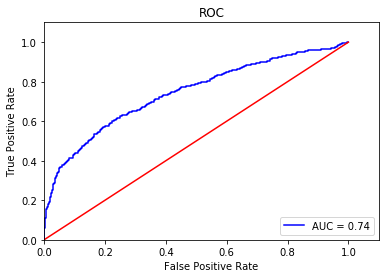

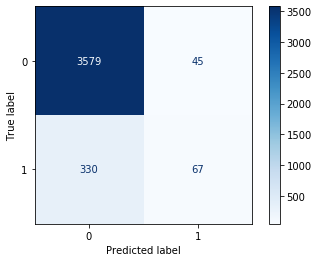

In [120]:
abc_cb_best = AdaBoostClassifier(base_estimator = cb_model.best_estimator_, random_state = ran_state)

abc_cb_best_model = abc_cb_best.fit(X_train, y_train)

# classify validation data
abc_cb_best_y_pred = abc_cb_best_model.predict(X_val)
abc_cb_best_y_pred_proba = abc_cb_best_model.predict_proba(X_val)[:, 1]

# get scores
auc_sco = roc_auc_score(y_val, abc_cb_best_y_pred_proba)
f1_sco = f1_score(y_val, abc_cb_best_y_pred)

print("AUC Score:", auc_sco)
print("F1 Score:", f1_sco)

# get roc curve
plot_roc_curve(abc_cb_best_y_pred_proba)

# get confusion matrix
plot_confusion_matrix(abc_cb_best_model, X_val, y_val, cmap=plt.cm.Blues)
plt.show()

# record scores
results_df.loc[len(results_df)] = ["ABC w/ CatBoost & Feature Creation", auc_sco, f1_sco]

F1 Score with proability of 0.65  : 0.010025062656641605


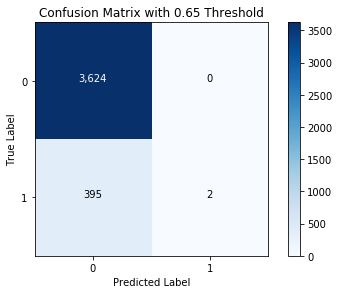

Test data predictions min churn probability: 0.14380600952557582
Test data predictions max churn probability: 0.7251764270571591
Number of churns predicted above threshold: 2


In [122]:
# set threshold for churn prediction
threshold = 0.65

# evaluate churn prediction at specified threshold of probability
eval_pred_threshold(abc_cb_best_y_pred_proba, y_val.values, threshold)

# predict on test set
y_pred = abc_cb_best_model.predict(test_clean)
y_pred_proba = abc_cb_best_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())
print("Number of churns predicted above threshold:", (pd.Series(y_pred_proba) > threshold).sum())

It seems like the hyperparameter tuning didn't result in a better model, so we will use the AdaBoost Classifier - CatBoost Parameter model for our predictions.

# Final Model

In [56]:
from sklearn.metrics import precision_score, recall_score

def eval_pred_threshold_detail (y_pred_proba, actual, threshold) :
    df = pd.DataFrame(y_pred_proba, columns = ["Churn Probability"])
    df["Churn Actual"] = actual
    df["Manual Predict"] = df["Churn Probability"]
    df["Manual Predict"] = df["Manual Predict"].apply(lambda x : 1 if (x >= threshold) else 0)
    
    f1_sco = f1_score(df["Churn Actual"], df["Manual Predict"])
    print("F1 Score with probability of", threshold, " :", f1_sco)
    
    precision_sco = precision_score(df["Churn Actual"], df["Manual Predict"], average = "binary", zero_division = 1)
    print("Precision with probability of", threshold, " :", precision_sco)
    
    recall_sco = recall_score(df["Churn Actual"], df["Manual Predict"], average = "binary", zero_division = 1)
    print("Recall with probability of", threshold, " :", recall_sco)
    
    plot_manual_confusion_matrix(df, threshold)

F1 Score with probability of 0.6  : 0.1643835616438356
Precision with probability of 0.6  : 0.8780487804878049
Recall with probability of 0.6  : 0.0906801007556675


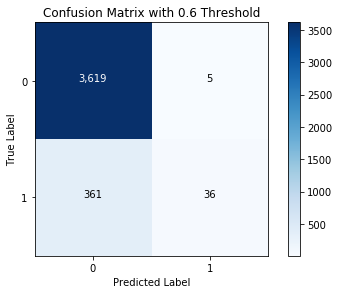

F1 Score with probability of 0.45  : 0.31578947368421056
Precision with probability of 0.45  : 0.564935064935065
Recall with probability of 0.45  : 0.21914357682619648


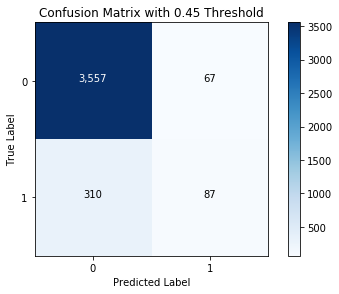

F1 Score with probability of 0.4  : 0.3420647149460709
Precision with probability of 0.4  : 0.44047619047619047
Recall with probability of 0.4  : 0.2795969773299748


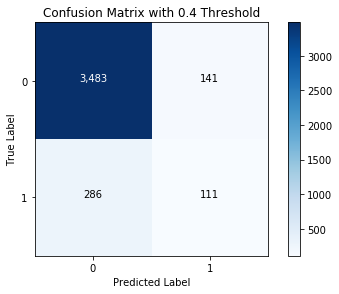

F1 Score with probability of 0.35  : 0.3941798941798942
Precision with probability of 0.35  : 0.415041782729805
Recall with probability of 0.35  : 0.37531486146095716


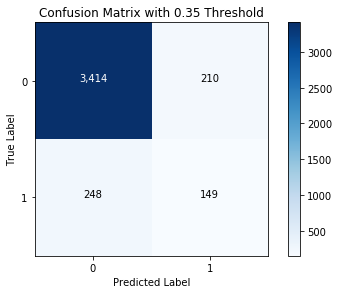

F1 Score with probability of 0.3  : 0.38125000000000003
Precision with probability of 0.3  : 0.325044404973357
Recall with probability of 0.3  : 0.4609571788413098


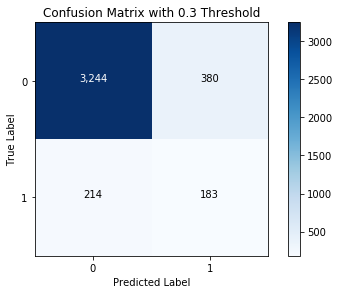

In [58]:
# evaluate different thresholds

threshold = [0.6, 0.45, 0.4, 0.35, 0.3]

for i in threshold :
    eval_pred_threshold_detail(abc_cb_clean_y_pred_proba, y_val.values, i)

In [61]:
# predict on test set
y_pred = abc_cb_clean_model.predict(test_clean)
y_pred_proba = abc_cb_clean_model.predict_proba(test_clean)[:, 1]

print("Test data predictions min churn probability:", y_pred_proba.min())
print("Test data predictions max churn probability:", y_pred_proba.max())

for i in threshold :
    print("Number of churns predicted above threshold of", i, ":", (pd.Series(y_pred_proba) > i).sum())

Test data predictions min churn probability: 0.003413374008140229
Test data predictions max churn probability: 0.9136623977857273
Number of churns predicted above threshold of 0.6 : 37
Number of churns predicted above threshold of 0.45 : 153
Number of churns predicted above threshold of 0.4 : 232
Number of churns predicted above threshold of 0.35 : 352
Number of churns predicted above threshold of 0.3 : 562


Considering the percentage of churn in the training set is 9.8%, we expect approximately 400 churners in the test set also. Therefore, the threshold of 35% should be a good cut-off for the classification. However, in a real-life situation, rather than depending on the classification of 0 and 1 to determine their actions, it is suggested that Power Co focus their retention efforts on the customers with the highest churn probability first and work down the list.

Of course, the gross margin made on the individual customers should also be factored in. If the company is making 0% margin on a high-churn-probability-customer, then they may choose to let go of that customer and focus on others who have both high churn probability and high margin.

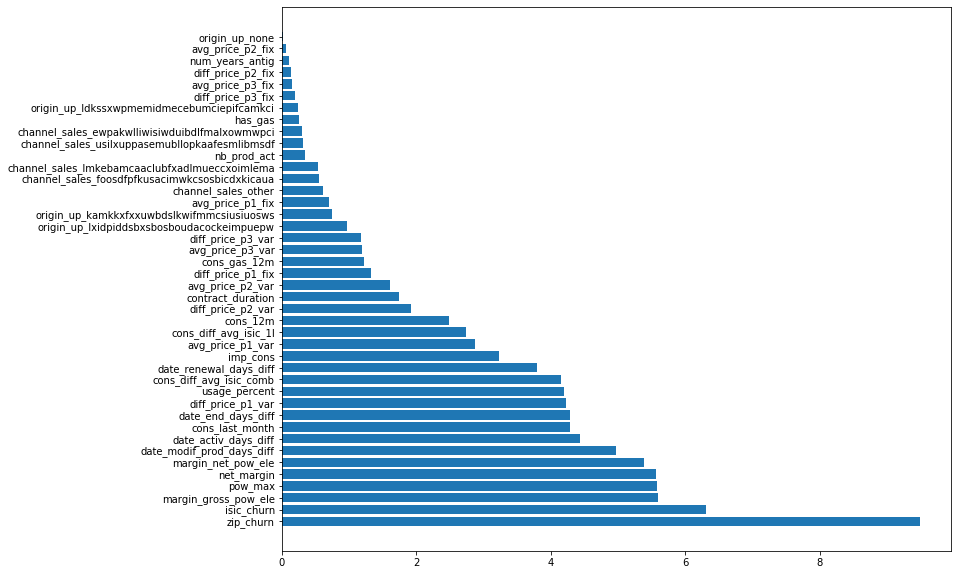

In [62]:
abc_cb_feature_imp = pd.DataFrame(abc_cb_clean_model.feature_importances_,
                              index = X_train.columns.tolist(),
                              columns = ["features"]
                             ).sort_values(["features"], ascending = False)

abc_cb_feature_imp = abc_cb_feature_imp[abc_cb_feature_imp["features"] != 0]

plt.figure(figsize=(12, 10))

plt.barh(range(len(abc_cb_feature_imp)), abc_cb_feature_imp["features"].tolist())
plt.yticks(range(len(abc_cb_feature_imp)), abc_cb_feature_imp["features"].index.tolist())

plt.show()

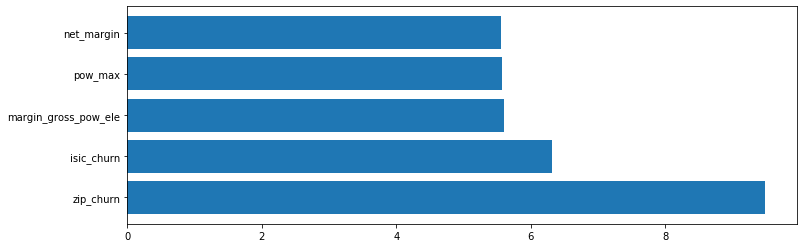

In [63]:
# plot only the top 5 most important features
abc_cb_feature_imp = abc_cb_feature_imp.head(5)

plt.figure(figsize=(12, 4))

plt.barh(range(len(abc_cb_feature_imp)), abc_cb_feature_imp["features"].tolist())
plt.yticks(range(len(abc_cb_feature_imp)), abc_cb_feature_imp["features"].index.tolist())

plt.show()

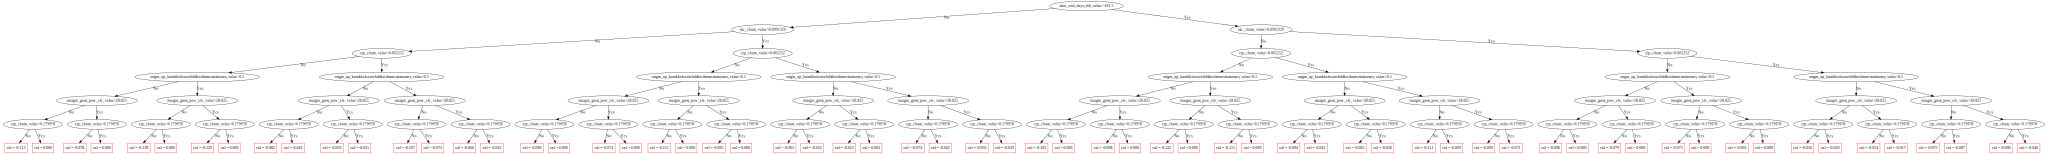

In [64]:
tree = abc_cb_clean_model.estimators_[0].plot_tree(0, pool = pool)

with open('output/abc_cb_tree.svg', 'w') as f:
    f.write(tree._repr_svg_())

tree

# Export Predictions

In [65]:
# import output template
test_output_template = pd.read_csv("input/Test_OUTPUT_template.csv",
                                   index_col = "id"
                                  ).drop(["Churn_prediction", "Churn_probability"],
                                         axis = 1
                                        )

In [67]:
y_pred_proba = abc_cb_clean_model.predict_proba(test_clean)[:, 1]

threshold = 0.35

test_clean["Churn_prediction"] = y_pred_proba
test_clean["Churn_probability"] = y_pred_proba
test_clean["Churn_prediction"] = test_clean["Churn_prediction"].apply(lambda x: 1 if (x >= threshold) else 0)


# join with test output template
test_output = test_output_template.join(test_clean[["Churn_prediction", "Churn_probability"]],
                                        how = "left",
                                        sort = False
                                       )
test_output = test_output.reset_index().set_index("Unnamed: 0").rename_axis("")

# join with test model output for financials
test_financial = pd.read_csv("input/test_df_clean_v2.csv", index_col = "id")
test_financial_output = test_financial.join(test_clean[["Churn_prediction", "Churn_probability"]],
                                            how = "left",
                                            sort = False
                                           )

In [68]:
# export prediction to csv
test_output.to_csv("output/Test_OUTPUT_v3.csv", index = True)
test_financial_output.to_csv("output/model_output_financials_v5.csv", index = True)

# Export Model

In [69]:
import joblib

joblib.dump(abc_cb_clean_model, "output/final_model_v2.joblib", compress = 5)

['output/final_model_v2.joblib']